In [1]:
import netCDF4
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from decimal import Decimal
import statistics as stats
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import skimage as ski
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import font_manager
from scipy.ndimage import label, binary_dilation, generate_binary_structure, filters, iterate_structure, binary_fill_holes, binary_erosion
from collections import deque
# mpl.rcParams['font.family'] = 'Roboto' # For Cumulus
mpl.rcParams['font.family'] = 'Arial' # For M1 MBP 
import holoviews as hv
from colorcet.plotting import swatch, swatches, candy_buttons
%pylab inline
from IPython.display import display, HTML
import xarray as xr
# import hvplot
import pint_xarray
import hvplot.xarray
from matplotlib.collections import LineCollection
from datetime import datetime, timedelta
import colorcet
import matplotlib.image as mpimg
import sklearn as sk
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor,LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error, confusion_matrix, r2_score
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
from imblearn.metrics import specificity_score
import itertools
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest, mannwhitneyu
from scipy.stats import pearsonr
import matplotlib.colors as mcolors
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Zhe recommends xarray version 2023.5.0 for some issue
# xr.__version__

In [ ]:
# Downgraded sklearn from 1.3.2 to 1.1.2 to be able to use missingpy

# Extracting a "favorite" vertical profile

In [44]:
# sonde = '/gpfs/wolf2/arm/cli120/world-shared/d3m088/cacti/staged_runs/' 
# sonde1 = '20181129/gefs09/base/les/out_d4/corlasso_wrfout_2018112900gefs09d4_base_M1.m0.20181129.150000.nc'
# sonde1 = '20181204/gefs18/base/les/out_d4/corlasso_wrfout_2018120400gefs18d4_base_M1.m0.20181204.150000.nc'
# sonde = '/gpfs/wolf2/arm/cli120/world-shared/d3m088/cacti/staged_runs_2/' 
# sonde1 = '20190123/gefs18/base/les/out_d4/corlasso_wrfout_2019012300gefs18d4_base_M1.m0.20190123.150000.nc'
sonde = '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20190129/eda09/base/les/out_d4/'
sonde1 = 'wrfout_d02_2019-01-29_15_00_00'
sx1 = xr.open_dataset(sonde + sonde1)

In [45]:
sonde1 = np.zeros((4,149))

In [46]:
# CSAPR Location
radar_lat = -32.1264
radar_lon = -64.7284

In [47]:
ix = 617; iy = 1264
sonde1[0,:] = sx1['T'][:,:,iy,ix].load() + 300
sonde1[1,:] = sx1['P'][:,:,iy,ix].load() + sx1['PB'][:,:,iy,ix].load() 
tmp1 = sx1['PH'][:,:,iy,ix].load() + sx1['PHB'][:,:,iy,ix].load() 
tmp2 = (tmp1[0,:-1] + tmp1[0,1:])/2
sonde1[2,:] = tmp2/9.81
sonde1[3,:] = sx1['QVAPOR'][:,:,iy,ix].load()

In [48]:
# np.savetxt("/gpfs/wolf2/arm/atm131/proj-shared/enochjo/gift/20181129_15Z.txt", sonde1.T, delimiter=',')
# np.savetxt("/gpfs/wolf2/arm/atm131/proj-shared/enochjo/gift/20181204_15Z.txt", sonde1.T, delimiter=',')
# np.savetxt("/gpfs/wolf2/arm/atm131/proj-shared/enochjo/gift/20190123_15Z.txt", sonde1.T, delimiter=',')
np.savetxt("/gpfs/wolf2/arm/atm131/proj-shared/enochjo/gift/20190129_15Z.txt", sonde1.T, delimiter=',')

# (1) Read in data, and isolate 2D masks

In [2]:
# fname1 = '/gpfs/wolf/atm131/proj-shared/enochjo/20190129_eda09_tracks/stats/trackstats_20190129.1500_20190129.1800.nc' # For Cumulus
# fname2 = '/gpfs/wolf/atm131/proj-shared/enochjo/20190129_eda09_tracks/stats/stats_3d_w_20190129.1500_20190129.1800.nc'
# fname3 = '/gpfs/wolf/atm131/proj-shared/enochjo/20190129_eda09_tracks/stats/stats_3d_env_20190129.1500_20190129.1800.nc'
# prefix = '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/'
prefix = '/Users/joen589/Downloads/stats/'
fname1 = \
    prefix+'/20181129/gefs09/base/les/tracks/stats/trackstats_20181129.1300_20181129.1800.nc',\
    prefix+'/20181204/gefs18/base/les/tracks/stats/trackstats_20181204.1500_20181204.1900.nc',\
    prefix+'/20190123/gefs18/base/les/tracks/stats/trackstats_20190123.1400_20190123.1800.nc',\
    prefix+'/20190129/eda09/base/les/tracks/stats/trackstats_20190129.1500_20190129.1800.nc'

fname2 = \
    prefix+'/20181129/gefs09/base/les/tracks/stats/stats_3d_w_20181129.1300_20181129.1800.nc',\
    prefix+'/20181204/gefs18/base/les/tracks/stats/stats_3d_w_20181204.1500_20181204.1900.nc',\
    prefix+'/20190123/gefs18/base/les/tracks/stats/stats_3d_w_20190123.1400_20190123.1800.nc',\
    prefix+'/20190129/eda09/base/les/tracks/stats/stats_3d_w_20190129.1500_20190129.1800.nc'

fname3 = \
    prefix+'/20181129/gefs09/base/les/tracks/stats/stats_3d_env_20181129.1300_20181129.1800.nc',\
    prefix+'/20181204/gefs18/base/les/tracks/stats/stats_3d_env_20181204.1500_20181204.1900.nc',\
    prefix+'/20190123/gefs18/base/les/tracks/stats/stats_3d_env_20190123.1400_20190123.1800.nc',\
    prefix+'/20190129/eda09/base/les/tracks/stats/stats_3d_env_20190129.1500_20190129.1800.nc'

fname4 = \
    prefix+'/20181129/gefs09/base/les/tracks/stats/stats_2d_env_20181129.1300_20181129.1800.nc',\
    prefix+'/20181204/gefs18/base/les/tracks/stats/stats_2d_env_20181204.1500_20181204.1900.nc',\
    prefix+'/20190123/gefs18/base/les/tracks/stats/stats_2d_env_20190123.1400_20190123.1800.nc',\
    prefix+'/20190129/eda09/base/les/tracks/stats/stats_2d_env_20190129.1500_20190129.1800.nc'

fname5 = \
    prefix+'/20181129/gefs09/base/les/tracks/stats/EnvMetrics_20181129_gefs09_base_d4.nc',\
    prefix+'/20181204/gefs18/base/les/tracks/stats/EnvMetrics_20181204_gefs18_base_d4.nc',\
    prefix+'/20190123/gefs18/base/les/tracks/stats/EnvMetrics_20190123_gefs18_base_d4.nc',\
    prefix+'/20190129/eda09/base/les/tracks/stats/EnvMetrics_20190129_eda09_base_d4.nc'

In [349]:
# xr.__version__

In [4]:
sx1 = xr.open_mfdataset(fname1[:],combine='nested',concat_dim='tracks')
sx2 = xr.open_mfdataset(fname2[:],combine='nested',concat_dim='tracks')
sx3 = xr.open_mfdataset(fname3[:],combine='nested',concat_dim='tracks')
sx4 = xr.open_mfdataset(fname4[:],combine='nested',concat_dim='tracks')
sx5 = xr.open_mfdataset(fname5[:],combine='nested',concat_dim='cell') # JM named tracks as cells # rename

In [5]:
mlen = len(sx2.coords['tracks'].load().data)
sx1 = sx1.assign_coords(tracks=np.arange(0,mlen,1))
sx2 = sx2.assign_coords(tracks=np.arange(0,mlen,1))
sx3 = sx3.assign_coords(tracks=np.arange(0,mlen,1))
sx4 = sx4.assign_coords(tracks=np.arange(0,mlen,1))
sx5 = sx5.assign_coords(cell=np.arange(0,mlen,1))

In [6]:
# Redo coordiates of sx3
# Time 240 corresponds to time 0, therefore removing and adjusting slice limit to 239
# sx3_mod = sx3.isel(times=slice(0,239)).assign_coords(times=np.arange(-239,0))
sx3_mod = sx3.isel(times=slice(0,119)).assign_coords(times=np.arange(-119,0))
ds_tmp = xr.concat([sx3_mod,sx2], dim='times',combine_attrs='drop_conflicts')
ds_d4 = xr.combine_by_coords([sx1, ds_tmp], combine_attrs='drop_conflicts')
ds_d4['times'] = ds_d4['times']*15/60
ds_d4['times'].attrs['units'] = 'min'

In [7]:
# sx5.isel(t=slice(0,15)).assign_coords(t=np.arange(-15,0))
# sx5.isel(t=slice(0,121)).assign_coords(t=np.arange(-120,1))

In [8]:
# sx5 = sx5.isel(t=slice(0,121)).assign_coords(t=np.arange(-120,1)) # Before when JM was outputting every 15 s
sx5 = sx5.isel(t=slice(0,15)).assign_coords(t=np.arange(-15,0)) # Now, when JM is outputting every 1 min
# sx4['times'] = sx4['times']*15/60
# sx4['times'].attrs['units'] = 'min'

In [9]:
start_basetime = ds_d4['start_basetime']
cell_meanlon = ds_d4['cell_meanlon'].mean(dim='times')
cell_meanlat = ds_d4['cell_meanlat'].mean(dim='times')
split = ds_d4['start_split_tracknumber']
merge = ds_d4['end_merge_tracknumber']
track_duration = ds_d4['track_duration']

In [10]:
track_duration.hvplot.hist(bins=30)

:NdOverlay   [Element]
   :Histogram   [track_duration]   (track_duration_count)

In [11]:
ntracks = ds_d4.dims['tracks']
ntimes = ds_d4.dims['times']
ncores = ds_d4.dims['core']
nz = ds_d4.dims['z']
CoreMaxW_up = ds_d4['CoreMaxW_up'].load()
CoreArea_up = ds_d4['CoreArea_up'].load()
maxETH_10dbz = ds_d4['maxETH_10dbz'].load().loc[dict(times = slice(-15,None))].max(dim='times')

In [12]:
# Eliminated 10dbz ETH threshold
subset = np.where((track_duration >= 5)\
                  & (np.isnan(split)) & (np.isnan(merge))  )[0]
len(subset)

2313

In [13]:
binary_w = np.zeros_like(CoreArea_up)
binary_w[CoreMaxW_up>0]=1
mask_all = np.zeros_like(CoreArea_up)*np.nan
mask_plt = np.zeros_like(CoreArea_up) # Just for plotting purposes
istart = np.zeros_like(subset)
iend = np.zeros_like(subset)

In [14]:
tlim = np.zeros_like(subset)
chgt = np.zeros_like(subset)
c_times = CoreMaxW_up.coords["times"].data
c_z = CoreMaxW_up.coords["z"].data
c_core = CoreMaxW_up.coords["core"].data

# for Tracks
# within time range of -15 to + infty
# create a new array with value of 1 where value is greater than 0
# do connected components
for tr in range(0,len(subset)):
    track = subset[tr]
    label_image = label(binary_w[track,:,:,:])


    da_label_image = xr.DataArray(label_image[0], coords=[c_times, c_z, c_core], dims=['times', 'z','core']) 
    # list_ind = np.trim_zeros(np.unique(da_label_image.loc[dict(times = slice(-5,+5))])) # 
    # Adam: mask regions after maxETH time, then determine largest object (potential solution for later)
    list_ind = np.trim_zeros(np.unique(da_label_image.loc[dict(times = slice(0.25,5))]))
    list_size = np.zeros_like(list_ind)

    if len(list_size)>0:
        for i in range(0,len(list_size)):
            ind = np.where(label_image[0] == list_ind[i])
            list_size[i] = len(ind[0])
    
        big_cell = list_ind[np.argmax(list_size)]
    
        mask_small = np.zeros_like(label_image[0])*np.nan
        mask_small[label_image[0]==big_cell] = 1
        
        mask_small_plt = np.zeros_like(label_image[0]) # Just for Plotting
        mask_small_plt[label_image[0]==big_cell] = 1
        
        tind = np.where(label_image[0]==big_cell)
        istart[tr] = min(tind[0])
        iend[tr] = max(tind[0])
    
        mask_all[track,:,:,:] = mask_small
        mask_plt[track,:,:,:] = mask_small_plt
    
da_mask = xr.DataArray(mask_all, coords=CoreMaxW_up.coords, dims=CoreMaxW_up.dims) 
da_mplt = xr.DataArray(mask_plt, coords=CoreMaxW_up.coords, dims=CoreMaxW_up.dims) 

In [15]:
da_mask.loc[dict(times = slice(None,-15))] = np.nan
da_mplt.loc[dict(times = slice(None,-15))] = np.nan

In [16]:
# Maybe Not even necessary to do here
tooshort = np.where(iend-istart<40)[0] # (10 mins)
len(tooshort)

387

In [17]:
# First Chopping
subset = np.delete(subset,tooshort)
# tlim = np.delete(tlim,tooshort)
# chgt = np.delete(chgt,tooshort)
istart = np.delete(istart,tooshort)
iend = np.delete(iend,tooshort)
len(subset)

1926

In [18]:
# max ETH was used to constrain when to analyze updraft
# But, we are analyzing clouds, so why not use max cloud top height?
# And, we are already imposing a constraint that the updraft needs to exist after CI.
# So, imposing this "must be after CI-time" is not very useful 

In [19]:
maxETH = ds_d4['maxETH_10dbz'].load()
mask_ETH = np.ones(maxETH.shape)
for i in range(0,len(subset)):
    mask_ETH[subset[i],iend[i]+1:] = np.nan
    mask_ETH[subset[i],:istart[i]-1] = np.nan
da_mask_ETH = xr.DataArray(mask_ETH, coords=ds_d4['maxETH_10dbz'].coords, dims=ds_d4['maxETH_10dbz'].dims) 
# da_mask_ETH.loc[dict(times = slice(None,-0.25))] = np.nan
mask = da_mask.data

In [20]:
# Need to restructure arrays to line up the different CB
# Per-updraft-core cloud base
iupdr_top = np.zeros((ntracks,ntimes))

CoreArea_tmp = CoreArea_up.data

for itime in np.arange(0,ntimes):
    for itracks in np.arange(0,ntracks):
        # for icore in np.arange(0,ncores):
            # vprof = np.where( isnan(  CoreArea_up[itracks,itime,:,icore]*mask[itracks,itime,:,icore] )==False )[0] # Edited
        vprof = np.where( isnan(  CoreArea_tmp[itracks,itime,:,:]*mask[itracks,itime,:,:] )==False )[0] # Edited
        if len(vprof) !=0:
            iupdr_top[itracks,itime] = int(vprof[-1])

iupdr_top = iupdr_top.astype(int)

In [21]:
# cldtp = np.max(iupdr_top,axis=2).astype(float)
cldtp = iupdr_top.astype(float)
cldtp[np.where(cldtp==0)] = NaN # get rid of zeros to prevent skewing of calculation

for i in range(0,len(subset)):
    cldtp[subset[i],:istart[i]] = np.nan
    cldtp[subset[i],iend[i]:] = np.nan

da_cldtp = xr.DataArray(cldtp, coords=ds_d4['maxETH_10dbz'].coords, dims=ds_d4['maxETH_10dbz'].dims) 

In [22]:
# Max Height
hgt_max = np.zeros_like(subset)
hgt_max_idx = np.zeros_like(subset)
hgt_min = np.zeros_like(subset)
hgt_min_idx = np.zeros_like(subset)


tpre = 120

for i in range(0,len(subset)):
    # val = (da_mask_ETH*maxETH).isel(tracks=subset[i]).max(dim='times').item()
    # time_dbz = np.where((da_mask_ETH*maxETH).isel(tracks=subset[i])==val)[0][-1] # Finding the time when maxETH peaks (after CI) 
    # BUT, you need to limit to the times when the current updraft object exists
    # Then limiting the cldtp range to before the point when maxETH peaks

    # val = da_cldtp.isel(tracks=subset[i]).loc[dict(times = slice(-0.25,None))].max(dim='times').item()
    # val = da_cldtp.isel(tracks=subset[i]).max(dim='times').item()
    # time_dbz = np.where(da_cldtp.isel(tracks=subset[i])==val)[0][-1] # Finding the time when maxETH peaks (after CI) 
    if nansum(cldtp[subset[i],:tpre]) > 0:
        hgt_min[i] = np.nanmin(cldtp[subset[i],:tpre]) # Find min value before t = 0
        hgt_min_idx[i] = np.nanargmin(cldtp[subset[i],:tpre]) 
        hgt_max[i] = np.nanmax(cldtp[subset[i],hgt_min_idx[i]:hgt_min_idx[i]+120]) # Giving a 30 minute window after the min time to find max
        cldtp[subset[i],:hgt_min_idx[i]] = np.nan # Set everything before min time to nan
        cldtp[subset[i],hgt_min_idx[i]+120:] = np.nan # Set everything after max time to nan
        hgt_max_idx[i] = np.where(cldtp[subset[i],:]==hgt_max[i])[0][-1] # Choosing the last duplicate value, in case there are multiple maxima.
    
    
    # hgt_max[i] = np.nanmax(cldtp[subset[i],:]) # Temporarily padding by 2 just to make the damn code work.
    # hgt_max_idx[i] = np.where(cldtp[subset[i],:]==hgt_max[i])[0][-1] # Choosing the last duplicate value, in case there are multiple maxima.
    # hgt_min[i] = np.nanmin(cldtp[subset[i],:hgt_max_idx[i]])
    # hgt_min_idx[i] = np.nanargmin(cldtp[subset[i],:hgt_max_idx[i]])
    
    
hgt_max = xr.DataArray(hgt_max,coords=[subset],dims=['tracks'])
hgt_max_idx = xr.DataArray(hgt_max_idx,coords=[subset],dims=['tracks']) # Has to be converted to minutes OR just keep in mind later.
hgt_min = xr.DataArray(hgt_min,coords=[subset],dims=['tracks'])
hgt_min_idx = xr.DataArray(hgt_min_idx,coords=[subset],dims=['tracks'])

In [23]:
tlim = hgt_max_idx - hgt_min_idx
chgt = np.copy(hgt_max)
tooshort = np.where( (tlim < 20) | (hgt_max == 99) )[0]
len(tooshort)

103

In [24]:
hgt_max = np.delete(hgt_max,tooshort)
hgt_max_idx = np.delete(hgt_max_idx,tooshort)
hgt_min = np.delete(hgt_min,tooshort)
hgt_min_idx = np.delete(hgt_min_idx,tooshort)
subset = np.delete(subset,tooshort)
tlim = np.delete(tlim,tooshort)
chgt = np.delete(chgt,tooshort)
len(subset)

1823

In [25]:
max_dbz = ds_d4['max_dbz'].load()
CoreMaxW = ds_d4['CoreMaxW_up'].load()
frac_ent = ds_d4['Entr_up'].load()/ds_d4['CoreMassFlux_up'].load()*10; frac_ent.name = 'Frac Entrainment'

In [26]:
# This mask is just for calculating hlne.
tmask_tmp = np.ones_like(da_mask.data)
for i in range(0,len(subset)):
    tmask_tmp[subset[i],:hgt_min_idx[i].item(),:] = np.nan
    tmask_tmp[subset[i],hgt_min_idx[i].item()+120:,:] = np.nan # Before
da_tmask_tmp = xr.DataArray(tmask_tmp,coords=da_mask.coords,dims=da_mask.dims)

In [27]:
# New alternative way to calculate CB
tmp = (CoreMaxW*da_tmask_tmp).isel(tracks=subset).data
hlne = np.zeros_like(subset)
for i in range(0,len(subset)):
# i = 0
    ind = np.zeros((tmp.shape[1],))
    for j in range(hgt_min_idx[i].item(),hgt_min_idx[i].item()+120):
        if np.nansum(tmp[i,j,:,0]>0)>0:
            ind[j] = np.where(tmp[i,j,:,0]>1)[0][0]
            ind[np.where(ind==0)] = np.nan
    
            hlne[i] = int(np.nanmedian(ind))

In [28]:
# Height Limit to 4 km aCB
cc = da_cldtp.data
hgt_lim_idx = np.zeros_like(subset)

for i in range(0,len(subset)):
    cc[subset[i],:hgt_min_idx[i].item()] = np.nan
    cc[subset[i],hgt_max_idx[i].item():] = np.nan
    value = np.where(cc[subset[i],:]-hlne[i]>40)[0]
    if len(value)>0:
        hgt_lim_idx[i] = value[0]
    else:
        hgt_lim_idx[i] = hgt_max_idx[i]
    
hgt_lim_idx = xr.DataArray(hgt_lim_idx,coords=[subset],dims=['tracks'])
mask1 = da_mask.data
da_mask1 = xr.DataArray(mask1,coords=da_mask.coords,dims=da_mask.dims)

In [29]:
tmask = da_mask.data
for i in range(0,len(subset)):
    tmask[subset[i],:hgt_min_idx[i].item(),:] = np.nan
    tmask[subset[i],hgt_lim_idx[i].item():,:] = np.nan # Before
    # tmask[subset[i],half_lim_idx[i].item():,:,:] = np.nan
    tmask[subset[i],:,:hlne[i]] = np.nan

da_tmask = xr.DataArray(tmask,coords=da_mask.coords,dims=da_mask.dims)

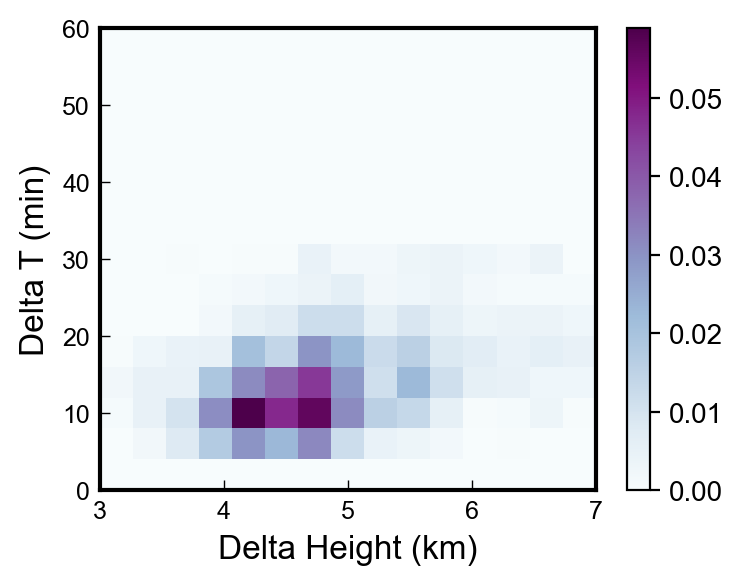

In [30]:
y1 = np.copy(tlim/4) # Time difference between min and max height
x1 = np.copy(chgt/10) # Growth Rate

fig = figure(figsize=(4, 3))
axs = plt.gca()

bad_indices = np.isnan(x1) | np.isnan(y1)
good_indices = ~bad_indices
good_x = x1[good_indices]
good_y = y1[good_indices]
pm1 = axs.hist2d(good_x, good_y, bins=(15, 15),range=[[3, 7],[0, 60]], cmap=cmx.BuPu, density=True) # density = True or something
axs.set_xlabel('Delta Height (km)',fontsize = 12)
axs.set_ylabel('Delta T (min)',fontsize = 12)
fig.colorbar(pm1[3], ax=axs)

axs.tick_params(direction='in')
axs.yaxis.set_tick_params(width=.5)
axs.xaxis.set_tick_params(width=.5)
axs.spines['top'].set_linewidth(1.5)
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['left'].set_linewidth(1.5)
axs.spines['right'].set_linewidth(1.5)
axs.tick_params(labelsize=9)    

[43. 47. 53.]
412 466 459 486


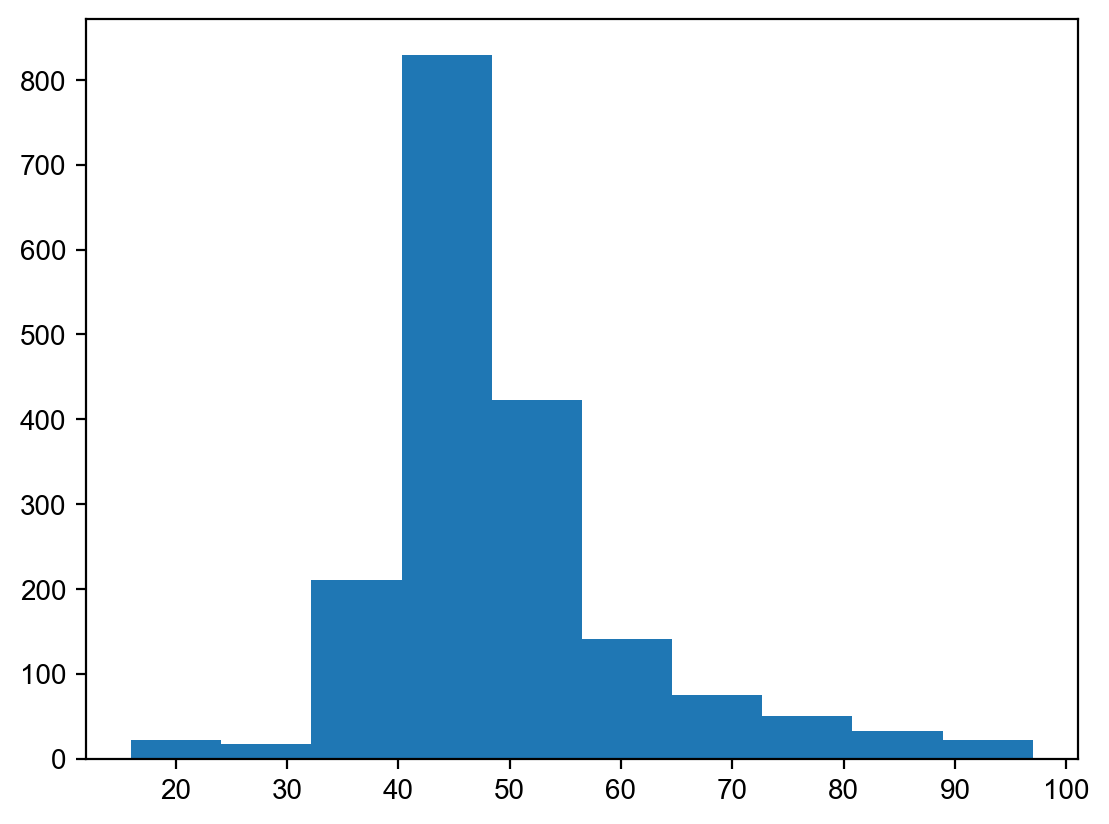

In [31]:
# Now do the sorting
isort = np.copy(chgt)
pct = np.quantile(isort,[.25,.5,.75])
print(pct)

i1 = np.where((isort<pct.data[0]))[0]
i2 = np.where((isort>=pct.data[0]) & (isort<pct.data[1]))[0]
i3 = np.where((isort>=pct.data[1]) & (isort<pct.data[2]))[0]
i4 = np.where((isort>=pct.data[2]))[0]
print(len(i1),len(i2),len(i3),len(i4))

cats = [i1,i2,i3,i4]
# Check the distribution
plt.hist(isort);

In [32]:
def cell_base_norm(da_array, subset, hlne):
    da_array_data = da_array.data
    np_array = np.zeros_like(da_array)*nan
    
    for i in range(0,len(subset)):
        tmp = da_array_data[subset[i],:,hlne[i]:]
        np_array[subset[i],:,:tmp.shape[1]] = tmp
                
    da_norm = xr.DataArray(np_array, coords=da_array.coords, dims=da_array.dims)
    return da_norm

In [33]:
da_tmask_cb = cell_base_norm(da_tmask,subset,hlne)

ct_max = zeros_like(subset)
for i in range(0,len(subset)):
    ct_max[i] = da_cldtp.isel(tracks=subset[i]).max(dim='times').item()

# (2) Isolating the entrainment detrainment couplet

In [34]:
frac_det = ds_d4['Detr_up'].load()/ds_d4['CoreMassFlux_up'].load()*10; frac_det.name = 'Frac Detrainment'
frac_ent = ds_d4['Entr_up'].load()/ds_d4['CoreMassFlux_up'].load()*10; frac_ent.name = 'Frac Entrainment'
net_ent = frac_ent + frac_det
da_entr = net_ent>0
da_detr = net_ent<0

In [35]:
da_entr_cb = cell_base_norm(da_entr,subset,hlne)
da_detr_cb = cell_base_norm(da_detr,subset,hlne)

In [36]:
# Find where sign changes from E to D
np_net_ent = net_ent.data
th_zero = np.zeros_like(net_ent)*np.NaN
th_belw = np.zeros_like(net_ent)*np.NaN
th_belw_inf = np.zeros_like(net_ent)*np.NaN
th_abve = np.zeros_like(net_ent)*np.NaN

for itrack in np.arange(0,ntracks):
    for itime in np.arange(0,ntimes):
        plus_minus = np.sign(np_net_ent[itrack,itime,:-4,0]) # -4 to prevent exceeding array bounds.
        
        d_pm = plus_minus[1:]-plus_minus[:-1]
        e_d = np.where(d_pm == -2)[0]
        # e_d = e_d[1:] # Removing the fist couplet
        
        th_zero[itrack,itime,e_d,:] = 1 # 200 m region straddling the area of net entrainment = 0
        th_zero[itrack,itime,e_d+1,:] = 1
        
        th_belw[itrack,itime,e_d-1,:] = 1 # 400 m region below last point of entrainment
        th_belw[itrack,itime,e_d-2,:] = 1
        th_belw[itrack,itime,e_d-3,:] = 1
        th_belw[itrack,itime,e_d-4,:] = 1

        th_abve[itrack,itime,e_d+2,:] = 1 # 400 m region above area of net entrainment
        th_abve[itrack,itime,e_d+3,:] = 1
        th_abve[itrack,itime,e_d+4,:] = 1
        th_abve[itrack,itime,e_d+5,:] = 1

        th_belw_inf[itrack,itime,e_d-1,:] = 1 # 400 m region below last point of entrainment
        th_belw_inf[itrack,itime,e_d-2,:] = 1
        th_belw_inf[itrack,itime,e_d-3,:] = 1
        th_belw_inf[itrack,itime,e_d-4,:] = 1

        cond1 = np.where(plus_minus==1)[0]
        if sum(cond1) > 0:
            z_bot = cond1[0] # bottom of updraft
            # th_belw[itrack,itime,z_bot:z_bot+3,:] = np.NaN # Zero out bottom 300 m of updraft

In [37]:
th_belw[net_ent<0] = np.NaN # Removing regions that correspond to detrainment
th_belw_inf[net_ent<0] = np.NaN # Removing regions that correspond to detrainment
th_abve[net_ent>0] = np.NaN # Removing regions that correspond to entrainment

da_belw = xr.DataArray(th_belw, coords=frac_ent.coords, dims=frac_ent.dims)
da_belw_inf = xr.DataArray(th_belw_inf, coords=frac_ent.coords, dims=frac_ent.dims)
da_abve = xr.DataArray(th_abve, coords=frac_ent.coords, dims=frac_ent.dims)
da_midl = xr.DataArray(th_zero, coords=frac_ent.coords, dims=frac_ent.dims)

da_belw_cb = cell_base_norm(da_belw,subset,hlne)
da_belw_inf_cb = cell_base_norm(da_belw_inf,subset,hlne)
da_abve_cb = cell_base_norm(da_abve,subset,hlne)
da_midl_cb = cell_base_norm(da_midl,subset,hlne)

In [38]:
# remove the bottom 400 m of da_belw_cb
da_belw_cb[:,:,:4,:] = np.NaN
da_special = xr.DataArray(th_belw, coords=frac_ent.coords, dims=frac_ent.dims)

In [39]:
# Converting some key pressure levels to height
# Conversion equation taken from NWS website
c1 = 0.190284
c2 = 145366.45*0.3048
P00 = 1013.25
h850 = round( (1 - (850/P00)**c1)*c2/100)
h700 = round( (1 - (700/P00)**c1)*c2/100)
h650 = round( (1 - (650/P00)**c1)*c2/100)
h600 = round( (1 - (600/P00)**c1)*c2/100)
h500 = round( (1 - (500/P00)**c1)*c2/100)

# (Optional) 2D time-height plots

In [98]:
tmp1 = abs(net_ent.data * da_mplt.data)

for i in range(0,len(subset)):
    tmp1[subset[i],:,:hlne[i]+4,0] = np.NaN

stuff = xr.DataArray(tmp1,coords = net_ent.coords,dims = net_ent.dims)
binary_data = xr.where(stuff >= 0.0000001, 1, 0)

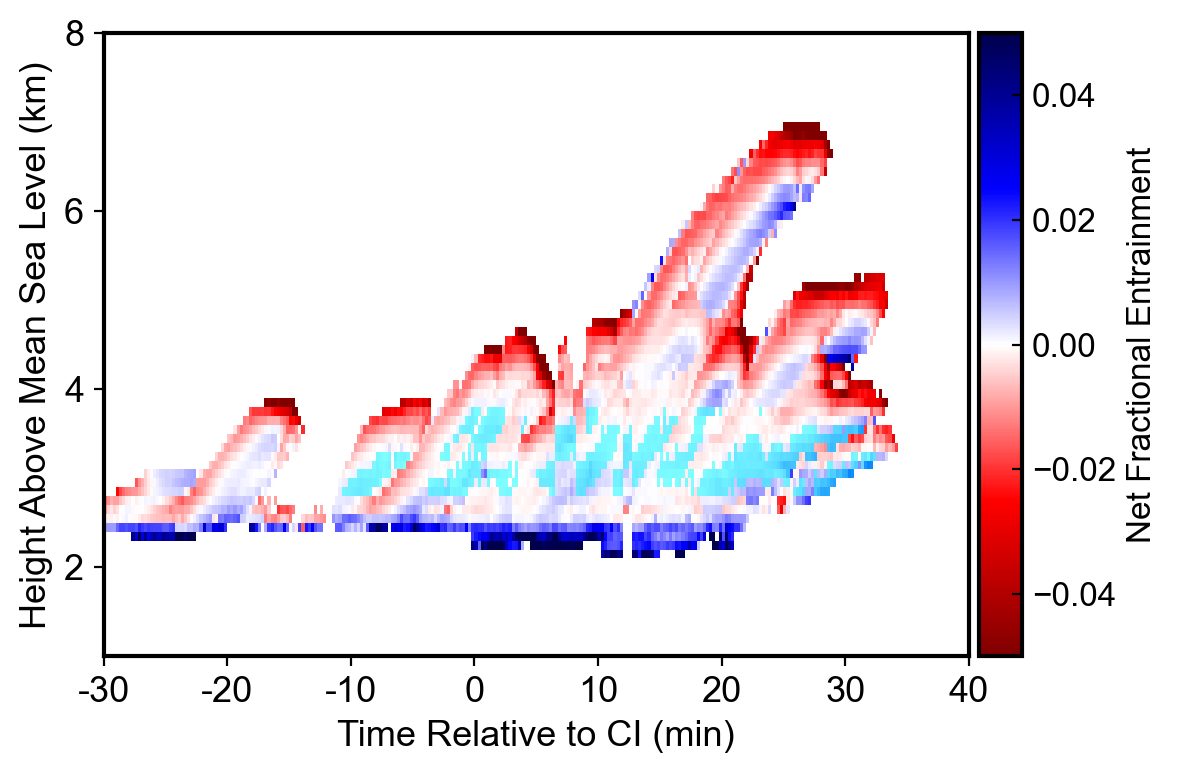

In [100]:
# The following box is just a testbed for the actual plotting code later
sub = np.copy(i4)

pt = (net_ent).loc[dict(times = slice(None,None))]
pte = da_belw.loc[dict(times = slice(None,None))]



for num in np.arange(8,9):
    fig = figure(figsize=(6, 4))
    axs = plt.gca()

    p1 = (net_ent).isel(tracks=subset[sub][num]).squeeze()
    pm = axs.pcolormesh(p1.T,vmin=-.05,vmax=.05,cmap='seismic_r') # net ent

    pte[subset[sub][num],:,hlne[num]:hlne[num]+4,:] = np.nan
    pe = pte.where(binary_data).isel(tracks=subset[sub][num]).squeeze()
    cmap = mpl.colors.ListedColormap(['cyan'])
    pe[:,hlne[num]+14:] = np.NaN
    pme = axs.pcolormesh(pe.T,vmin=1,vmax=1,cmap=cmap,alpha=0.5)
    
    divider = make_axes_locatable(axs)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb1 = plt.colorbar(pm, cax=cax, orientation='vertical')
    cb1.ax.tick_params(axis='y', direction='in',labelsize=12)
    cb1.set_label(label='Net Fractional Entrainment',size=12)
    cb1.outline.set_linewidth(1.5) 
    
    axs.set_yticks(np.arange(0, 101, 20))
    axs.set_yticklabels(np.arange(0, 11, 2), fontsize=13)
    axs.set_ylim([10, 80])

    axs.set_xticks(np.arange(0, 210*4, 40))
    axs.set_xticklabels(np.arange(-30, 180, 10), fontsize=13)
    axs.set_xlim([0, 280])

    axs.set_ylabel('Height Above Mean Sea Level (km)', fontsize=13)
    axs.set_xlabel('Time Relative to CI (min)', fontsize=13)

    for spine in axs.spines.values():
        spine.set_linewidth(1.5)


    plt.tight_layout()
    plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure5.png',dpi=300)

In [1067]:
# pd_CoreThteMax = CoreThteMax_cb.isel(core=0).isel(tracks=subset).isel(z=10).median(dim='times').to_pandas()

In [953]:
pd_CoreBuoyThtv = cell_base_norm((ds_d4['CoreBuoyThtv_up'].load()),subset,hlne).isel(core=0).isel(tracks=subset).isel(z=9).median(dim='times').to_pandas()

In [954]:
pd_CoreMaxW = cell_base_norm(ds_d4['CoreMaxW_up'].load(),subset,hlne).isel(core=0).isel(tracks=subset).isel(z=9).median(dim='times').to_pandas()

In [955]:
# May need log distribution
pd_CoreWidth = cell_base_norm(2*np.sqrt(ds_d4['CoreArea_up'].load()/np.pi),subset,hlne).isel(core=0).isel(tracks=subset).isel(z=4).median(dim='times').to_pandas()

In [956]:
# Needs log distribution
pd_CoreMassFlux = cell_base_norm(ds_d4['CoreMassFlux_up'].load(),subset,hlne).isel(core=0).isel(tracks=subset).isel(z=9).median(dim='times').to_pandas()

In [1080]:
# pd_CoreReflMax = cell_base_norm(ds_d4['CoreReflMax_up'].load(),subset,hlne).isel(core=0).isel(tracks=subset).isel(z=10).median(dim='times').to_pandas()

In [1055]:
# May need log distribution
pd_Entr = cell_base_norm(ds_d4['Entr_up'].load()/ds_d4['CoreMassFlux_up'].load()*10,subset,hlne).isel(core=0).isel(tracks=subset).isel(z=14).min(dim='times').to_pandas()

In [958]:
# May need log distribution
pd_Detr = cell_base_norm(ds_d4['Detr_up'].load()/ds_d4['CoreMassFlux_up'].load()*10,subset,hlne).isel(core=0).isel(tracks=subset).isel(z=14).max(dim='times').to_pandas()

In [959]:
# Give simple labels to individual dates for plotting later
sub_time = ds_d4['base_time'].isel(times=120).isel(tracks=subset).load()
ind1 = (sub_time>=np.datetime64('2018-11-29T13:00:00')) & (sub_time<=np.datetime64('2018-11-29T18:00:00'))
ind2 = (sub_time>=np.datetime64('2018-12-04T15:00:00')) & (sub_time<=np.datetime64('2018-12-04T19:00:00'))
ind3 = (sub_time>=np.datetime64('2019-01-23T14:00:00')) & (sub_time<=np.datetime64('2019-01-23T18:00:00'))
ind4 = (sub_time>=np.datetime64('2019-01-29T15:00:00')) & (sub_time<=np.datetime64('2019-01-29T18:00:00'))
ct = np.zeros_like(subset)
ct[ind1] = 0
ct[ind2] = 1
ct[ind3] = 2
ct[ind4] = 3

In [103]:
# pd_ct

In [961]:
df_ct = xr.DataArray(ct,coords=[subset],dims=['tracks'])
pd_ct = df_ct.to_pandas()

In [ ]:
pd_rh_700mb = sx5['rh_700mb'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()

In [962]:
df_up = pd.DataFrame({"MassFlux": pd_CoreMassFlux\
                       ,"CoreBuoyThtv": pd_CoreBuoyThtv\
                       ,"CoreMaxW": pd_CoreMaxW\
                       ,"CoreWidth": pd_CoreWidth\
                       ,"F.Entrainment": pd_Entr\
                       ,"F.Detrainment": pd_Detr\
                      ,"CellHeight": np.copy(ct_max)/10\
                      ,"Date": pd_ct\
                  })

In [1057]:
df_tmp = pd.DataFrame({"F.Ent": pd_Entr\
                       ,"CoreWidth": pd_CoreWidth\
                       ,"RH700mb": pd_rh_700mb\
                       })

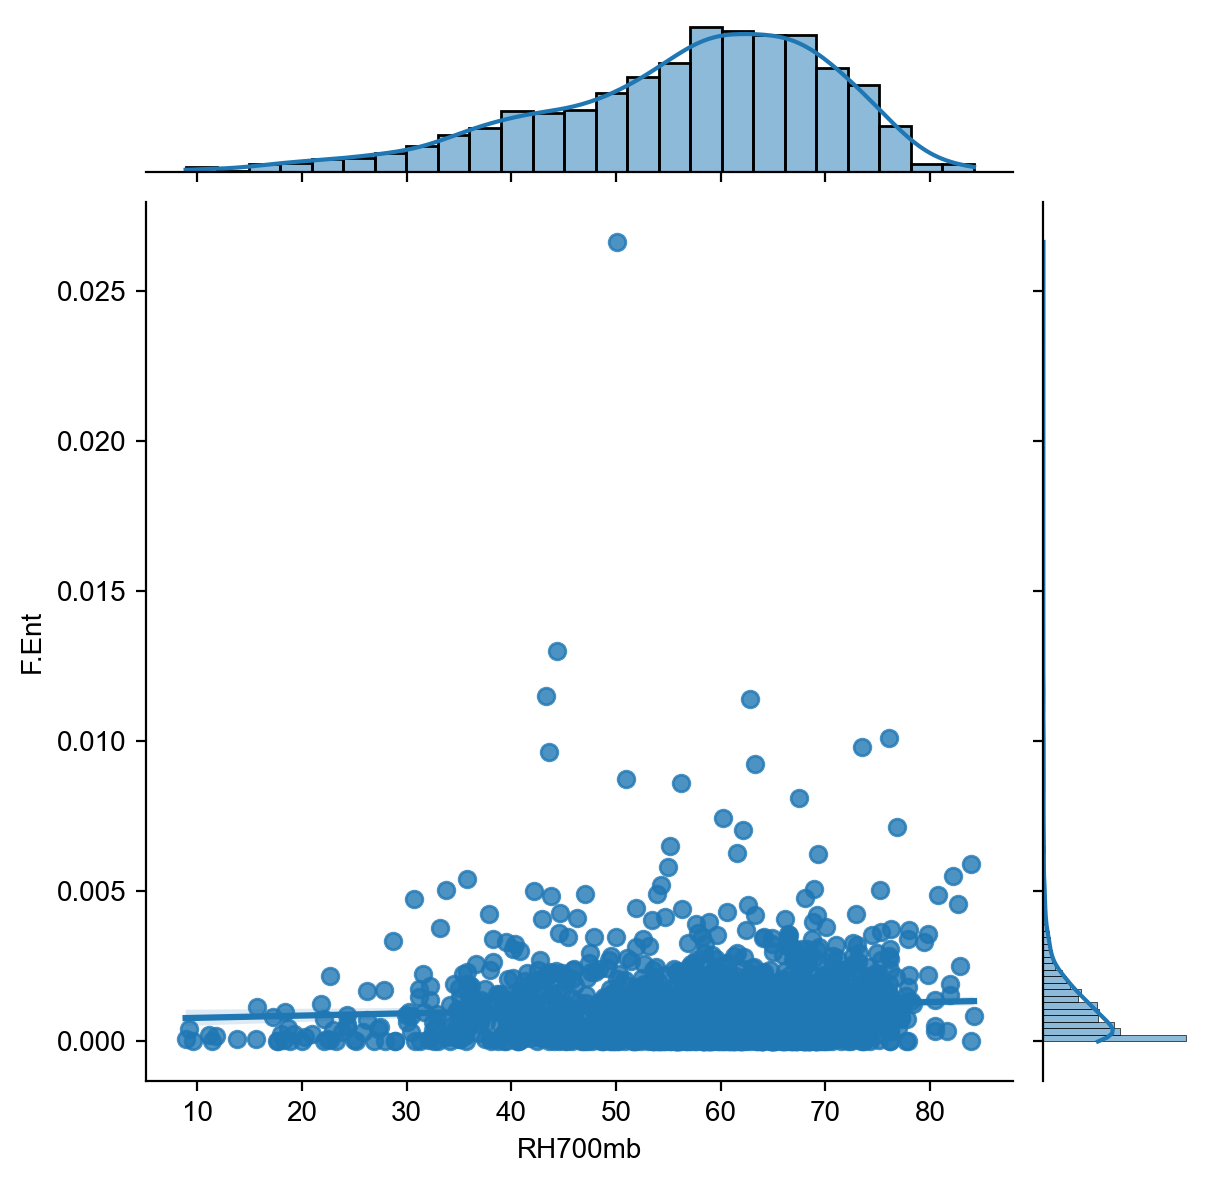

In [1060]:
sns.jointplot(y="F.Ent", x="RH700mb", data=df_tmp, kind="reg");

In [975]:
np.corrcoef(pd_CoreWidth.to_numpy(),pd_CoreWidth.to_numpy())

array([[nan, nan],
       [nan, nan]])

In [973]:
pd_CoreWidth.to_numpy()

array([1.0280024 , 1.0764052 , 0.6180387 , ..., 0.7091611 , 0.85934794,
       0.90621585], dtype=float32)

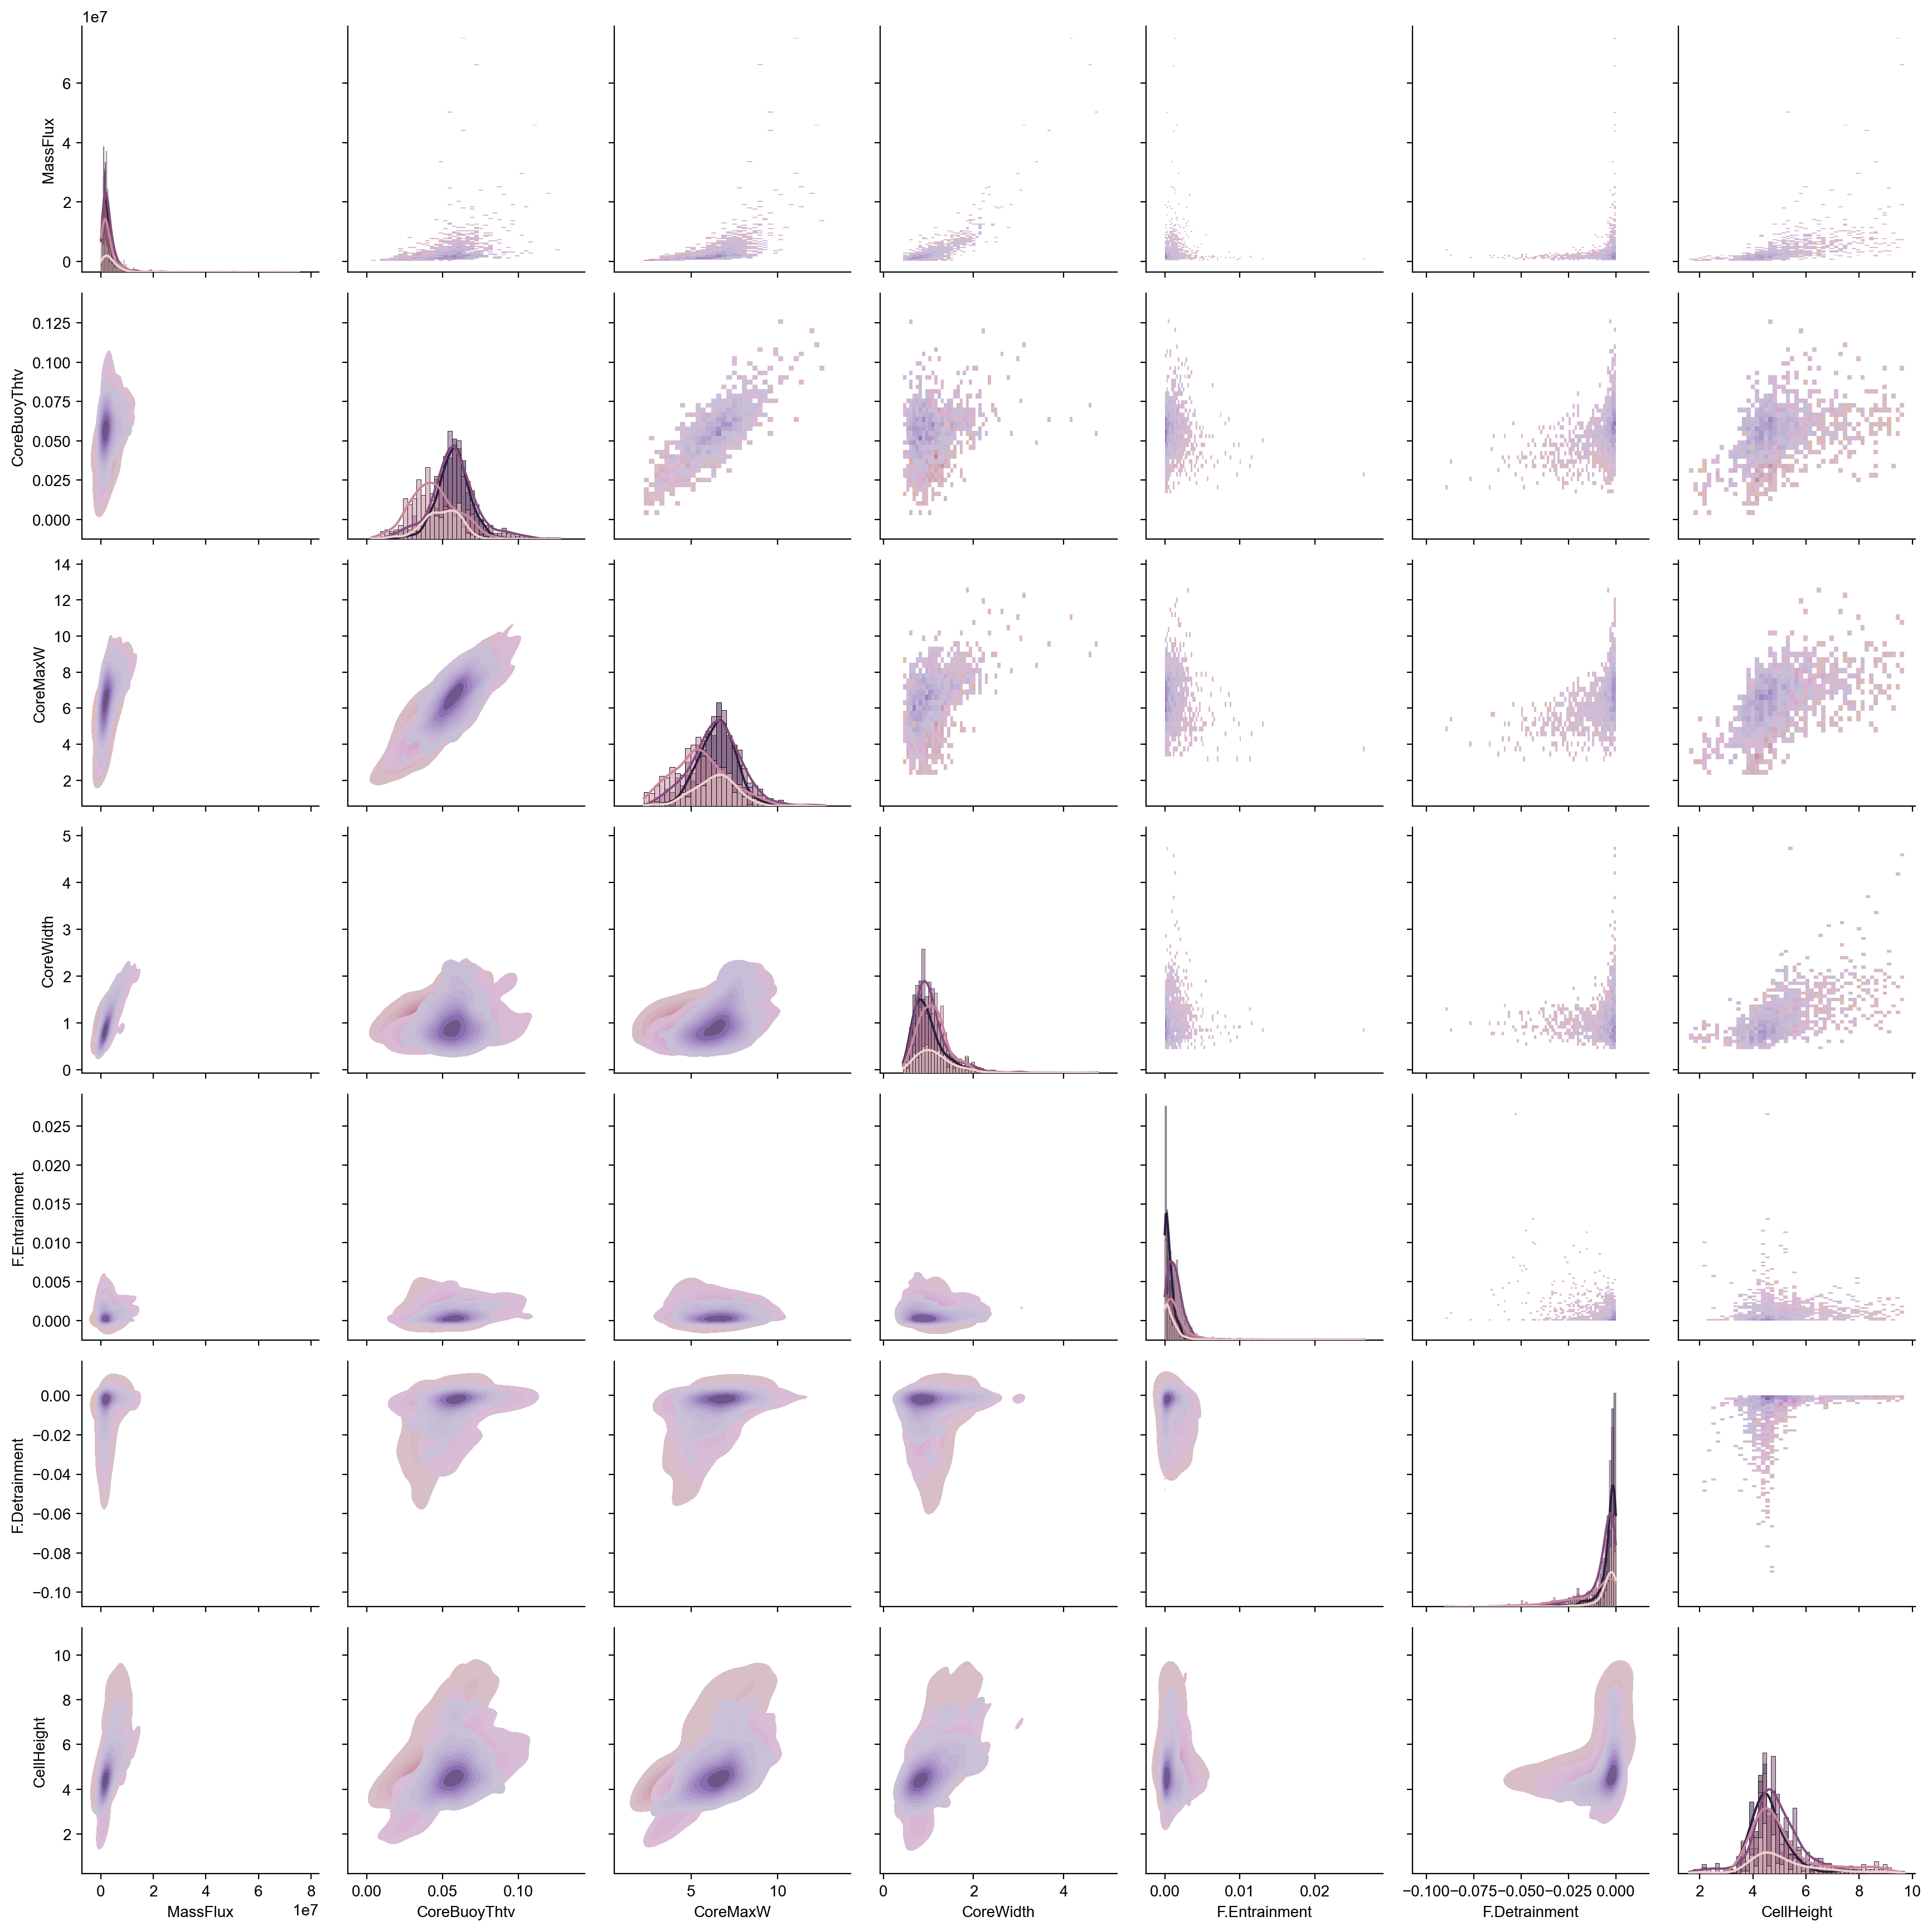

In [963]:
p1 = sns.PairGrid(df_up,hue="Date")
p1.map_upper(sns.histplot)
p1.map_lower(sns.kdeplot, fill=True)
p1.map_diag(sns.histplot, kde=True)

In [1054]:
# sx5
pd_rh_700mb = sx5['rh_700mb'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()

In [59]:
warnings.filterwarnings("ignore")
rel_time = -15
pd_MUCAPE = sx5['CAPE_mu'].loc[dict(t = rel_time )].max({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()
pd_MUCIN = sx5['CIN_mu'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()
pd_LCL = sx5['LCL_height_mu'].loc[dict(t = rel_time )].median({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()
pd_LFC = sx5['LFC_height_mu'].loc[dict(t = rel_time )].median({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()
pd_EL = sx5['EL_height_mu'].loc[dict(t = rel_time )].max({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()
pd_RHLCL = sx5['rh_at_muLCLplus1500m'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()
pd_RHLFC = sx5['rh_at_muLFCplus1500m'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()
pd_rh_500mb = sx5['rh_500mb'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()
pd_rh_600mb = sx5['rh_600mb'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()
pd_rh_700mb = sx5['rh_700mb'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()
pd_BlkShr_0to6km = sx5['shear_mag_bulk_0to6km'].loc[dict(t = rel_time )].median({'x','y'},skipna='true').isel(cell=subset).load().to_pandas()

In [65]:
df_env = pd.DataFrame({"MUCAPE": pd_MUCAPE\
                      ,"MUCIN": pd_MUCIN\
                       ,"LCL": pd_LCL\
                       ,"LFC": pd_LFC\
                       ,"EL": pd_EL\
                       ,'RHLCL': pd_RHLCL\
                       ,'RHLFC': pd_RHLFC\
                       ,"rh500": pd_rh_500mb\
                       ,"rh600": pd_rh_600mb\
                       ,"rh700": pd_rh_700mb\
                       ,"BlkShr0to6km": pd_BlkShr_0to6km\
                       ,"Date": pd_ct\
                      })

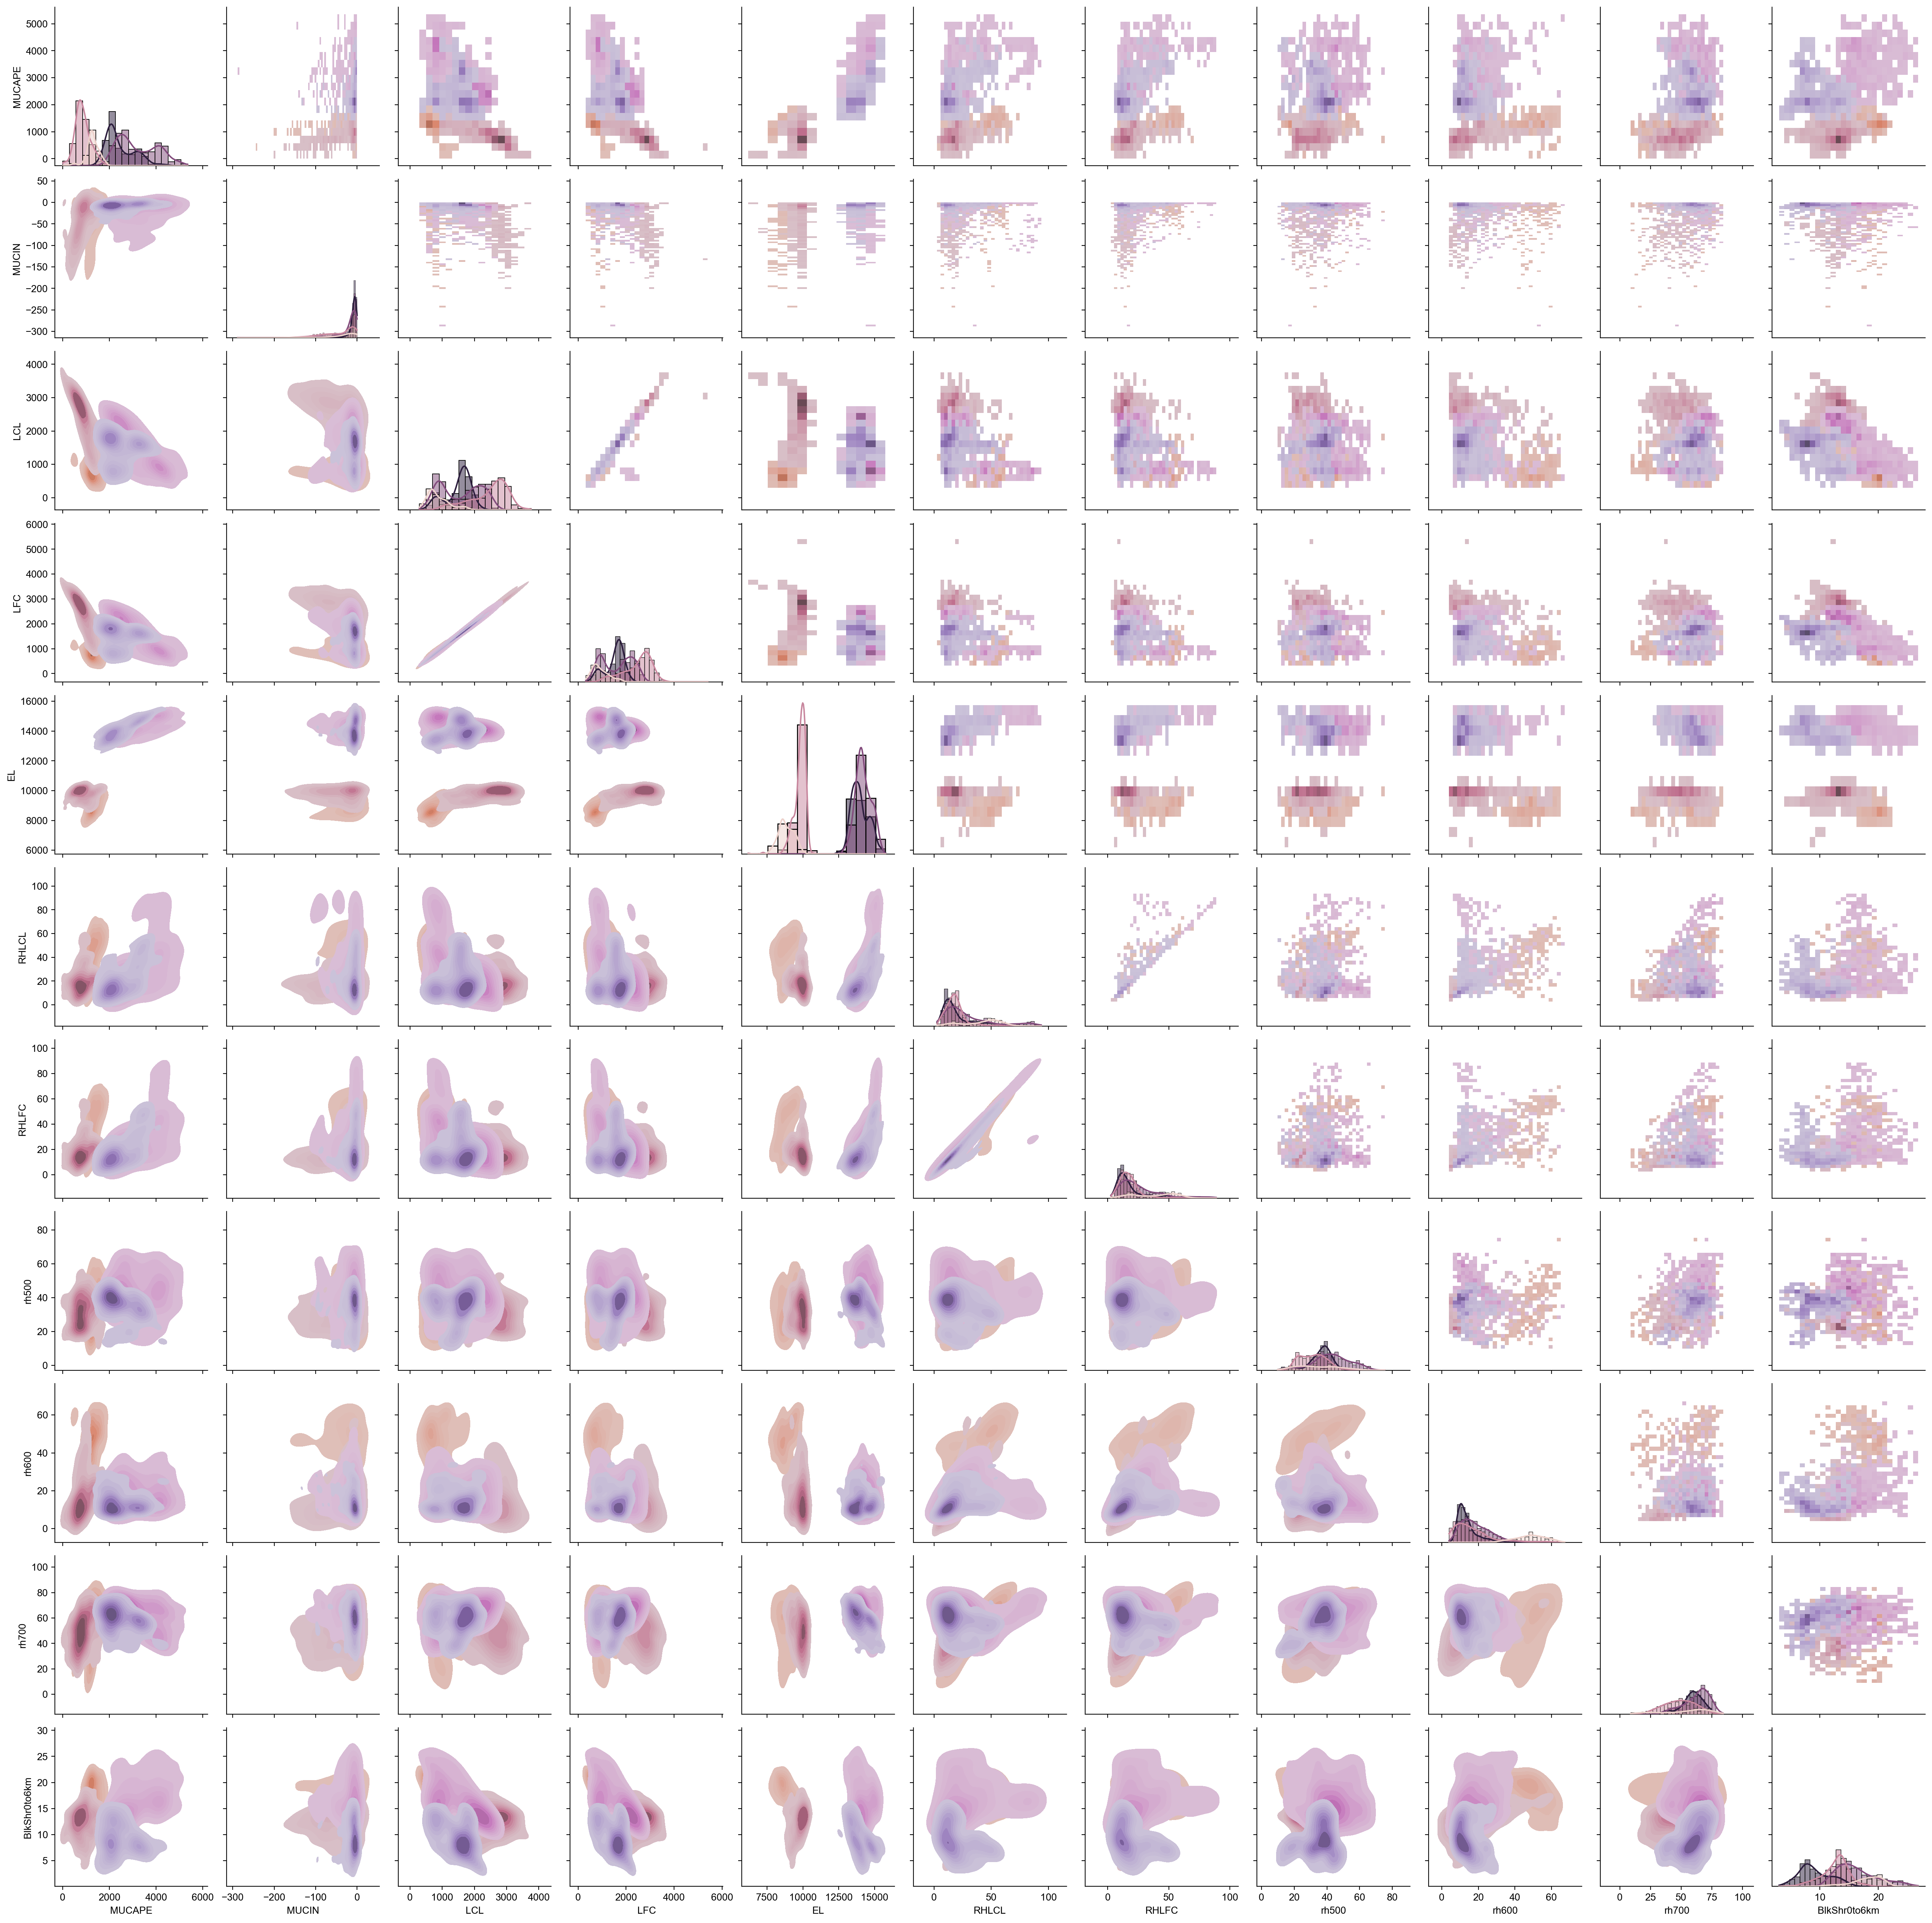

In [66]:
# sns.pairplot(df_env,dropna=True)
p2 = sns.PairGrid(df_env,dropna=True,hue="Date")
p2.map_upper(sns.histplot)
p2.map_lower(sns.kdeplot, fill=True)
p2.map_diag(sns.histplot, kde=True)

In [44]:
def nonans(x1,y1):
    bad_indices = np.isnan(x1) | np.isnan(y1)
    good_indices = ~bad_indices
    good_x = x1[good_indices]
    good_y = y1[good_indices]
    
    return good_x, good_y

def r2e(xx,yy):
    model = LinearRegression()
    model.fit( xx.data.reshape(-1, 1), yy.data.reshape(-1, 1))
    y_pred = model.predict(xx.data.reshape(-1, 1))
    r2 = r2_score(yy.data.reshape(-1, 1), y_pred)

    return r2

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [68]:
# Re-format the time-dimension of a couple of netcdf files to minutes.
# Make sure not to run these more than once per Jupyter Notebook session.
# sx4['times'] = sx4['times']*15/60
# sx4['times'].attrs['units'] = 'min'

In [43]:
# sx5 = sx5.isel(t=slice(0,121)).assign_coords(t=np.arange(-120,1)*15/60)

# (3) Read in the needed data

In [40]:
# Read in Ambient (environmental) Variables (JM)
warnings.filterwarnings("ignore")
rel_time = -15

# Convert LCL/LFC/EL heights to above HAMSL
HAMSL = sx4['hamsl'].loc[dict(times = rel_time )].isel(tracks=subset).load()
LCL = sx5['LCL_height_mu'].loc[dict(t = rel_time )].isel(cell=subset).load()
LFC = sx5['LFC_height_mu'].loc[dict(t = rel_time )].isel(cell=subset).load()
EL = sx5['EL_height_mu'].loc[dict(t = rel_time )].isel(cell=subset).load()

In [41]:
# Testing Means
MULCL = xr.DataArray(LCL.data + HAMSL.data,dims=HAMSL.dims,coords=HAMSL.coords).mean({'x','y'},skipna='true')
MULFC = xr.DataArray(LFC.data + HAMSL.data,dims=HAMSL.dims,coords=HAMSL.coords).mean({'x','y'},skipna='true')
MUEL =   xr.DataArray(EL.data + HAMSL.data,dims=HAMSL.dims,coords=HAMSL.coords).mean({'x','y'},skipna='true')
MUCAPE =                      sx5['CAPE_mu'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
MUCAPE_acbl =             sx5['CAPEacbl_mu'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
RHLFC1500 =      sx5['RH_mean_ACBL'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
rh_600mb =                   sx5['rh_600mb'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
rh_700mb =                   sx5['rh_700mb'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
PW_tmp = sx5['PW'].loc[dict(t = rel_time )].load()
PW =                            PW_tmp.where(PW_tmp != -911., np.nan).mean({'x','y'},skipna='true').isel(cell=subset).load()
BlkShr_acbl =  sx5['shear_mag_bulk_ACBL_mu'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
BlkShr_0to6km = sx5['shear_mag_bulk_0to6km'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
BlkShr_0to3km = sx5['shear_mag_bulk_0to3km'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
BlkShr_0to1km = sx5['shear_mag_bulk_0to1km'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()

In [42]:
# Read in Updraft and Shell Variables
CoreWidth_cb = cell_base_norm(2*np.sqrt(ds_d4['CoreArea_up'].load()/np.pi),subset,hlne)
CoreBuoyThtv_up_cb = cell_base_norm((ds_d4['CoreBuoyThtv_up'].load()),subset,hlne)
frac_ent_cb = cell_base_norm((ds_d4['Entr_up'].load()/ds_d4['CoreMassFlux_up'].load()*1000), subset, hlne);
CoreMaxW_up = cell_base_norm((ds_d4['CoreMaxW_up'].load()),subset,hlne)
CoreMassFlux_up = cell_base_norm((ds_d4['CoreMassFlux_up'].load()),subset,hlne)
CoreMeanW_up = cell_base_norm((ds_d4['CoreMeanW_up'].load()),subset,hlne)
CoreRHMean_prm = cell_base_norm((ds_d4['CoreRHMean_prm'].load()),subset,hlne)
# CoreThtePert_cb = cell_base_norm(ds_d4['CoreThteMean_prm'].load()-ds_d4['CoreThteMean_up'].load(),subset,hlne)
CoreThteMax_up = ds_d4['CoreThteMax_up'].load()
CoreThtePert_cb = cell_base_norm(ds_d4['CoreThteMean_prm'].load()-CoreThteMax_up,subset,hlne)
CoreRHMean_pr6 = cell_base_norm((ds_d4['CoreRHMean_pr6'].load()),subset,hlne)
CoreThtePert_c6 = cell_base_norm(ds_d4['CoreThteMean_pr6'].load()-CoreThteMax_up,subset,hlne)

In [ ]:
# Maybe plot the bottom 25 and top 25? Nah, the flow of text suggests that you should just plot all the things

1435 388


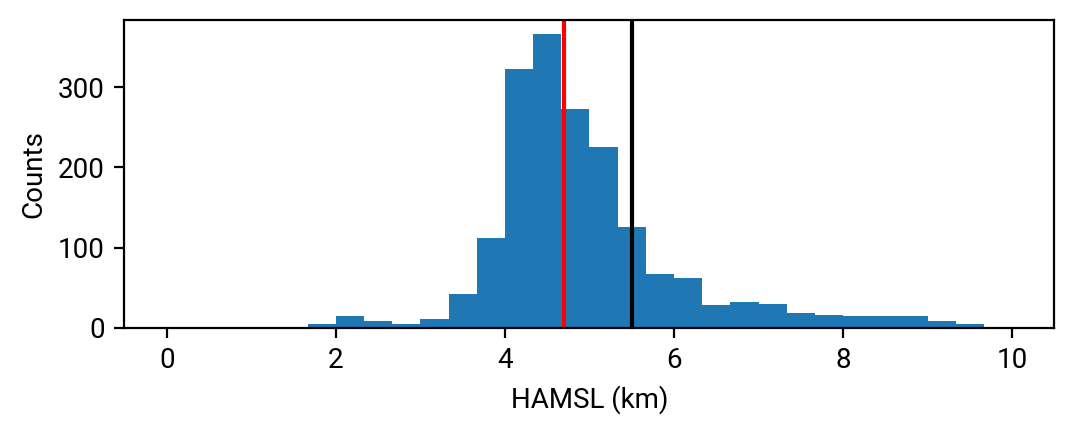

In [55]:
# HAMSL heights
ch = np.copy(ct_max)/10
plt.figure(figsize=(6,2))
plt.hist(ch,bins=30,range=(0,10))
plt.axvline(np.median(ch),color='red')
plt.xlabel('HAMSL (km)')
plt.ylabel('Counts')

thresh = 5.5
# thresh = np.median(ch)
plt.axvline(thresh,color='k')
ind_small = ch<thresh
ind_large = ch>=thresh
chb = np.zeros_like(subset)
chb[ind_small] = 0
chb[ind_large] = 1
print(sum(ind_small),sum(ind_large))

In [66]:
sum(ind_small)

1435

In [43]:
cu = (CoreMaxW_up*da_tmask_cb).isel(z=slice(0,4)).mean(dim={'times','z'}).isel(tracks=subset).squeeze();
cmu = (CoreMeanW_up*da_tmask_cb).isel(z=slice(0,4)).mean(dim={'times','z'}).isel(tracks=subset).squeeze();
cmf = (CoreMassFlux_up*da_tmask_cb).isel(z=slice(0,4)).mean(dim={'times','z'}).isel(tracks=subset).squeeze();
cw = (CoreWidth_cb*da_tmask_cb).isel(z=slice(0,4)).mean(dim={'times','z'}).isel(tracks=subset).squeeze();
cb = (CoreBuoyThtv_up_cb*da_tmask_cb).isel(z=slice(0,4)).mean(dim={'times','z'}).isel(tracks=subset).squeeze();
csrh = (CoreRHMean_prm*da_tmask_cb*da_belw_cb).isel(z=slice(4,14)).mean(dim={'times','z'}).isel(tracks=subset).squeeze(); 
cp = (CoreThtePert_cb*da_tmask_cb*da_belw_cb).isel(z=slice(4,14)).mean(dim={'times','z'}).isel(tracks=subset).squeeze();
csr6 = (CoreRHMean_pr6*da_tmask_cb*da_belw_cb).isel(z=slice(4,14)).mean(dim={'times','z'}).isel(tracks=subset).squeeze();
cp6 = (CoreThtePert_c6*da_tmask_cb*da_belw_cb).isel(z=slice(4,14)).mean(dim={'times','z'}).isel(tracks=subset).squeeze(); 
cf = (frac_ent_cb*da_tmask_cb*da_belw_cb).isel(z=slice(4,14)).mean(dim={'times','z'}).isel(tracks=subset).squeeze();

ch = np.copy(ct_max)/10
chrel = (ct_max - hlne)/10
sind = np.arange(0,len(subset),1)

# (5) One-Hot encoding of Dates

In [44]:
# Give simple labels to individual dates for plotting later
sub_time = ds_d4['base_time'].isel(times=120).isel(tracks=subset).load()
ind1 = (sub_time>=np.datetime64('2018-11-29T13:00:00')) & (sub_time<=np.datetime64('2018-11-29T18:00:00'))
ind2 = (sub_time>=np.datetime64('2018-12-04T15:00:00')) & (sub_time<=np.datetime64('2018-12-04T19:00:00'))
ind3 = (sub_time>=np.datetime64('2019-01-23T14:00:00')) & (sub_time<=np.datetime64('2019-01-23T18:00:00'))
ind4 = (sub_time>=np.datetime64('2019-01-29T15:00:00')) & (sub_time<=np.datetime64('2019-01-29T18:00:00'))
ct = np.zeros_like(subset)
ct[ind1] = 0
ct[ind2] = 1
ct[ind3] = 2
ct[ind4] = 3

In [45]:
# # CB-relative heights
# plt.figure(figsize=(6,2))
# plt.hist(chrel,bins=30)
# plt.axvline(np.median(chrel),color='red')

# thresh = 2.9
# plt.axvline(thresh,color='k')

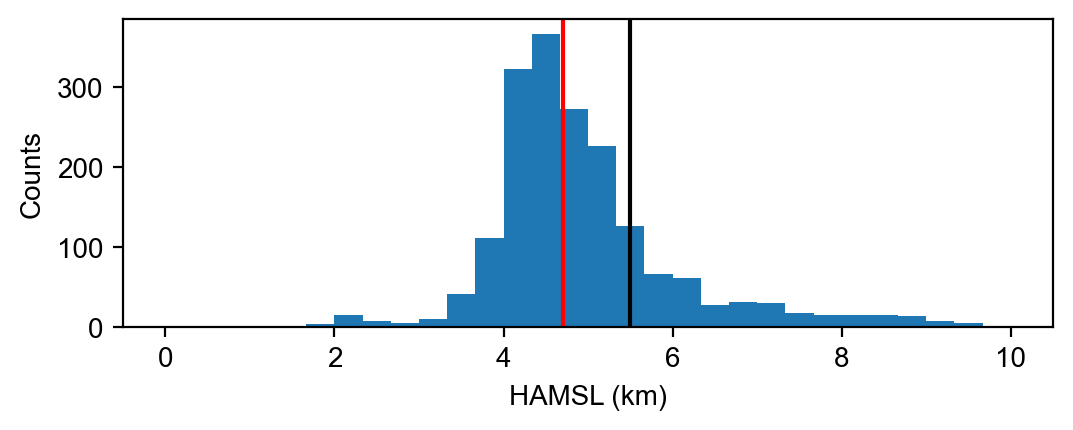

In [46]:
# HAMSL heights
# ind = ct == 3
plt.figure(figsize=(6,2))
plt.hist(ch,bins=30,range=(0,10))
plt.axvline(np.median(ch),color='red')
plt.xlabel('HAMSL (km)')
plt.ylabel('Counts')

thresh = 5.5
plt.axvline(thresh,color='k')

In [47]:
ind_small = ch<thresh
ind_large = ch>=thresh
chb = np.zeros_like(subset)
chb[ind_small] = 0
chb[ind_large] = 1
print(sum(ind_small),sum(ind_large))

1435 388


# (6) Organize data and fill in missing values

In [514]:
# Stitch together the array to be inserted into the RF function

feature_list = ['Width',r'$w_{max}$',r'$w_{mean}$','VMF','B',r'$\epsilon$'\
                ,'Shell RH',r'Shell $\theta_e^{\prime}$','600 hPa RH','700 hPa RH','ACBL RH'\
                ,'LCL','LFC','EL','CAPE','ACBL CAPE'\
                ,'0-1 km BWD','0-3 km BWD','0-6 km BWD','ACBL BWD']
X = np.array([cw.data,cu.data,cmu.data,cmf.data,cb.data,cf.data\
              ,csr6.data, cp6.data,rh_600mb.data,rh_700mb.data,RHLFC1500.data\
              ,MULCL.data,MULFC.data,MUEL.data,MUCAPE.data,MUCAPE_acbl.data\
              ,BlkShr_0to1km.data,BlkShr_0to3km.data,BlkShr_0to6km.data,BlkShr_acbl.data]).T

# y = np.array([ch.data]).T
y = np.array([chb.data]).T # Binary form

# Find data that have bad indices
chk = np.sum(X,axis=1)
bad_indices = np.isnan(chk) | np.isinf(chk) == 1
good_indices = np.isnan(chk) | np.isinf(chk) == 0
sum(good_indices)

# Option 1: Filter data by good indices (i.e., get rid of all rows that have at least one NaN)
x = X[good_indices]
y = y[good_indices]
Ct = ct[good_indices]

In [515]:
for i in np.arange(0,4):
    date1 = Ct == i
    short = sum(ch[good_indices][date1]<5.5)
    tall = sum(ch[good_indices][date1]>=5.5)
    print('Pct Tall: ',round( tall/sum(date1)*100,3),'Pct Short: ',round( short/sum(date1)*100,3),\
          ' # Tall: ',tall,' # Short: ',short, ' total',sum(date1))

print("missing: ",sum(bad_indices), "total tracked: ",sum(good_indices))

Pct Tall:  30.964 Pct Short:  69.036  # Tall:  61  # Short:  136  total 197
Pct Tall:  32.095 Pct Short:  67.905  # Tall:  121  # Short:  256  total 377
Pct Tall:  24.09 Pct Short:  75.91  # Tall:  139  # Short:  438  total 577
Pct Tall:  11.921 Pct Short:  88.079  # Tall:  54  # Short:  399  total 453
missing:  219 total tracked:  1604


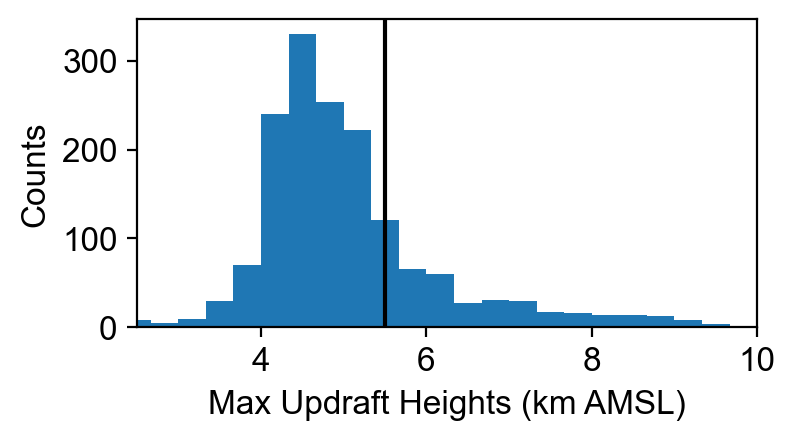

In [70]:
# HAMSL heights
# ind = ct == 3
plt.figure(figsize=(4,2))
plt.hist(ch[good_indices],bins=30,range=(0,10));
# plt.axvline(np.median(ch),color='red')
plt.xlabel('Max Updraft Heights (km AMSL)',fontsize=12)
plt.ylabel('Counts',fontsize=12)

thresh = 5.5
plt.axvline(thresh,color='k')
axs = plt.gca()

axs.set_xlim([2.5,10]);
axs.tick_params(labelsize=12)

plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/S_max_updr_hgt.png',dpi=300, bbox_inches="tight")

# Mean Median test

In [342]:
# Testing For Supplementary Material
mean_RH = sx5['rh_600mb'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
mean_BWD = sx5['shear_mag_bulk_0to6km'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
mean_CAPE = sx5['CAPEacbl_mu'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
mean_width = (CoreWidth_cb*da_tmask_cb).isel(z=slice(0,4)).mean(dim={'times','z'}).isel(tracks=subset).squeeze();
mean_frac = (frac_ent_cb*da_tmask_cb*da_belw_cb).isel(z=slice(4,14)).mean(dim={'times','z'}).isel(tracks=subset).squeeze();

median_RH = sx5['rh_600mb'].loc[dict(t = rel_time )].median({'x','y'},skipna='true').isel(cell=subset).load()
median_BWD = sx5['shear_mag_bulk_0to6km'].loc[dict(t = rel_time )].median({'x','y'},skipna='true').isel(cell=subset).load()
median_CAPE = sx5['CAPEacbl_mu'].loc[dict(t = rel_time )].median({'x','y'},skipna='true').isel(cell=subset).load()
median_width = (CoreWidth_cb*da_tmask_cb).isel(z=slice(0,4)).median(dim={'times','z'}).isel(tracks=subset).squeeze();
median_frac = (frac_ent_cb*da_tmask_cb*da_belw_cb).isel(z=slice(4,14)).median(dim={'times','z'}).isel(tracks=subset).squeeze();

max_RH = sx5['rh_600mb'].loc[dict(t = rel_time )].max({'x','y'},skipna='true').isel(cell=subset).load()
max_BWD = sx5['shear_mag_bulk_0to6km'].loc[dict(t = rel_time )].max({'x','y'},skipna='true').isel(cell=subset).load()
max_CAPE = sx5['CAPEacbl_mu'].loc[dict(t = rel_time )].max({'x','y'},skipna='true').isel(cell=subset).load()
max_width = (CoreWidth_cb*da_tmask_cb).isel(z=slice(0,4)).max(dim={'times','z'}).isel(tracks=subset).squeeze();
max_frac = (frac_ent_cb*da_tmask_cb*da_belw_cb).isel(z=slice(4,14)).max(dim={'times','z'}).isel(tracks=subset).squeeze();

min_RH = sx5['rh_600mb'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load()
min_BWD = sx5['shear_mag_bulk_0to6km'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load()
min_CAPE = sx5['CAPEacbl_mu'].loc[dict(t = rel_time )].min({'x','y'},skipna='true').isel(cell=subset).load()
min_width = (CoreWidth_cb*da_tmask_cb).isel(z=slice(0,4)).min(dim={'times','z'}).isel(tracks=subset).squeeze();
min_frac = (frac_ent_cb*da_tmask_cb*da_belw_cb).isel(z=slice(4,14)).min(dim={'times','z'}).isel(tracks=subset).squeeze();

In [343]:
# Stitch together the array to be inserted into the RF function
feature_list = ['mean Width','mean Ent','mean RH','mean CAPE','mean BWD'\
               ,'med Width','med Ent','med RH','med CAPE','med BWD'\
               ,'max Width','max Ent','max RH','max CAPE','max BWD'\
               ,'min Width','min Ent','min RH','min CAPE','min BWD']

Xt = np.array([mean_width.data,mean_frac.data,mean_RH.data,mean_CAPE.data,mean_BWD.data\
              ,median_width.data,median_frac.data,median_RH.data,median_CAPE.data,median_BWD.data\
              ,max_width.data,max_frac.data,max_RH.data,max_CAPE.data,max_BWD.data\
              ,min_width.data,min_frac.data,min_RH.data,min_CAPE.data,min_BWD.data]).T


In [344]:
# subsets=[(1,2,0,3),(6,7,5,8),(11,12,10,13),(16,17,15,18)]
# subsets=[(1,2,0,3,4),(6,7,5,8,9),(1,2,0,3,14),(6,7,5,8,14)]
subsets=[(1,2,3),(6,7,8),(11,12,13),(16,17,18)]

In [345]:
# OG Method
n_bootstraps = 100
bootstrap_F1 = np.zeros((n_bootstraps))
F1 = np.zeros((2,len(subsets)))
Nc = np.zeros((len(subsets),))
Coef = np.zeros((2,len(ordah),len(subsets)))*np.nan
StdC = np.zeros((2,len(ordah),len(subsets)))*np.nan
SgnC = np.zeros((len(ordah),len(subsets)))*np.nan

scaler = StandardScaler()
logmodel = LogisticRegression(penalty='l2',solver='newton-cholesky',fit_intercept=True, max_iter=100, class_weight='balanced')

for i in np.arange(0,len(subsets)):
    bootstrap_coefs = np.zeros((n_bootstraps,len(subsets[i])))
    for c in np.arange(0,n_bootstraps):
        X_train, X_test, y_train, y_test = train_test_split(Xt[good_indices],y, train_size=0.7,test_size=0.3,random_state=c,stratify=y)
        X_train_sc = scaler.fit_transform(X_train)
        X_test_sc = scaler.fit_transform(X_test)
        logmodel.fit(X_train_sc[:,subsets[i]],y_train);
        y_pred = logmodel.predict(X_test_sc[:,subsets[i]])

        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        bootstrap_F1[c] = tp/(tp+fp+fn)
        bootstrap_coefs[c,:] = logmodel.coef_[0]
    
    # Calculate 2.5th and 97.5th percentile to form the 95% CI
    Coef[0,:len(subsets[i]),i] = np.percentile(bootstrap_coefs, 2.5, axis=0)
    Coef[1,:len(subsets[i]),i] = np.percentile(bootstrap_coefs, 97.5, axis=0)
    
    F1[0,i] = np.percentile(bootstrap_F1, 2.5, axis=0)
    F1[1,i] = np.percentile(bootstrap_F1, 97.5, axis=0)
    Nc[i] = len(subsets[i])
    StdC[0,:len(logmodel.coef_[0]),i] = Coef[0,:len(subsets[i]),i] / sum(abs(  Coef[0,:len(subsets[i]),i]  ))*100
    StdC[1,:len(logmodel.coef_[0]),i] = Coef[1,:len(subsets[i]),i] / sum(abs(  Coef[1,:len(subsets[i]),i]  ))*100
    SgnC[:len(logmodel.coef_[0]),i] = np.sign(logmodel.coef_[0])

In [346]:
# ascending_indices = np.argsort(F1[1,icorrect]) # This is when you want to only display information about the physically correct LR models
ascending_indices = np.array([0,1,2,3])
descending_indices = ascending_indices
# ind2 = np.where(icorrect)[0]
ind2 = np.where(np.array([ True,  True,  True, True]))[0] # Override

values = np.zeros((len(ascending_indices),len(subsets[0])))
lower_errors = np.zeros((len(ascending_indices),len(subsets[0])))
upper_errors = np.zeros((len(ascending_indices),len(subsets[0])))
f1s = np.zeros((len(ascending_indices),3))

for oo in np.arange(0,len(ind2)):
    print('{:<17} {:>10} {:>10} {:>10}'.format('Var','2.5%','50%','97.5%' ))
    c = 0
    for i in subsets[ind2[descending_indices][oo]]:
        p1 = round(StdC[0,c,ind2[descending_indices][oo]],4)
        p2 = round(StdC[1,c,ind2[descending_indices][oo]],4)
        ph = round((p1+p2)/2,4)
        pp = round(ph-p2,4)
        pn = round(ph-p1,4)
        values[oo,c] = ph
        lower_errors[oo,c] = abs(pn)
        upper_errors[oo,c] = abs(pp)
        
        print('{:<17} {:>10} {:>10} {:>10} {:>10} {:>10}'.format( feature_list[i], p1, ph, p2, pn, pp))
        c = c + 1

    p1 = round(F1[0,ind2[descending_indices][oo]],3)
    p2 = round(F1[1,ind2[descending_indices][oo]],3)
    ph = round((p1+p2)/2,3)
    print('{:<17} {:>10} {:>10} {:>10}'.format(' ', p1, ph, p2))
    print(' ')

    f1s[oo,0] = p1
    f1s[oo,1] = ph
    f1s[oo,2] = p2

Var                     2.5%        50%      97.5%
mean Ent             -27.209   -21.6212   -16.0334     5.5878    -5.5878
mean RH               45.503     48.316     51.129      2.813     -2.813
mean CAPE             27.288    30.0628    32.8376     2.7748    -2.7748
                        0.51      0.555        0.6
 
Var                     2.5%        50%      97.5%
med Ent             -33.8003   -26.9287   -20.0571     6.8716    -6.8716
med RH               40.2707    43.5642    46.8577     3.2935    -3.2935
med CAPE              25.929    29.5071    33.0852     3.5781    -3.5781
                       0.465      0.512      0.559
 
Var                     2.5%        50%      97.5%
max Ent                3.449     5.5364     7.6239     2.0874    -2.0875
max RH               68.4768    66.9179     65.359    -1.5589     1.5589
max CAPE             28.0742    27.5456    27.0171    -0.5286     0.5285
                       0.381      0.408      0.436
 
Var                     2.5%   

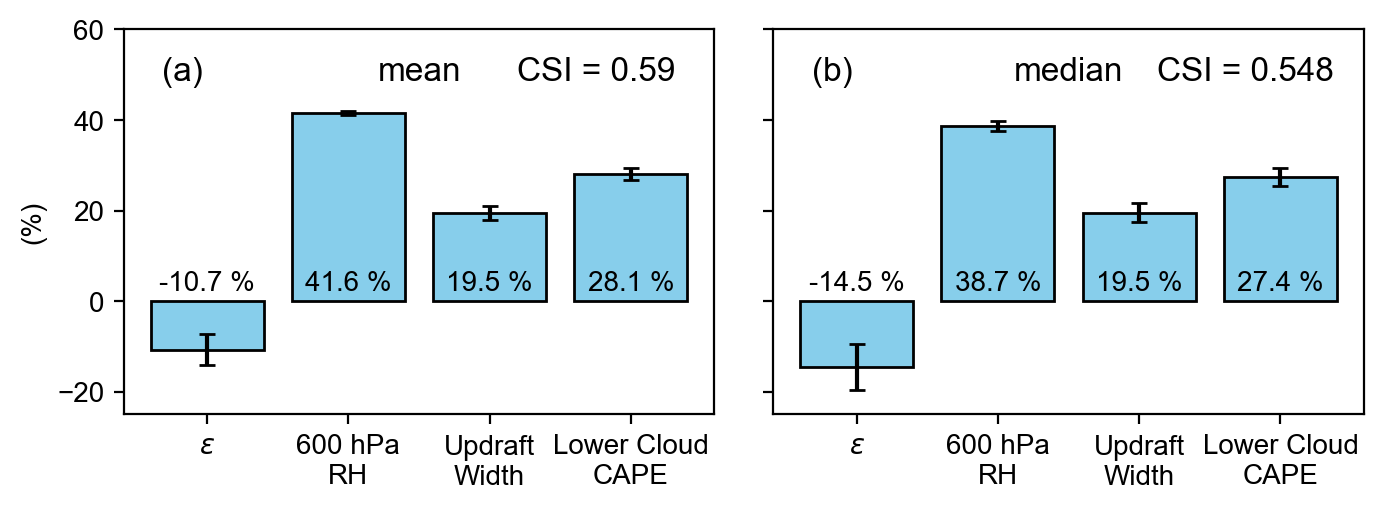

In [200]:
categories = ['$\epsilon$', '600 hPa\nRH','Updraft\nWidth','Lower Cloud\nCAPE']
crit =  ['mean','median','max','min']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2.5))
axs = axes.ravel()

format_func = np.vectorize(lambda x: f'{x:.3g}')
formatted_val = format_func(values)

alp = ['(a)','(b)']

for i in range(2):
    asymmetric_error = [lower_errors[i,:], upper_errors[i,:]]
    bars = axs[i].bar(categories, formatted_val[i,:].astype(float), yerr=asymmetric_error, capsize=3, color='skyblue', edgecolor='black')
    axs[i].set_ylim([-25, 60])
    for bar in bars:
        yval = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2, 1, f'{yval}'+' %', ha='center', va='bottom')
    axs[i].text(0.8,0.85,'CSI = '+str(f1s[i,1]),transform=axs[i].transAxes,fontsize=12, ha='center', va='bottom')
    axs[i].text(0.5,0.85,crit[i],transform=axs[i].transAxes,fontsize=12, ha='center', va='bottom')
    axs[i].text(0.1,0.85,alp[i],transform=axs[i].transAxes,fontsize=12, ha='center', va='bottom')

# axs[0].set_ylabel('(%)');
# axs[2].set_ylabel('(%)');
# axs[0].set_xticklabels('');
# axs[1].set_xticklabels('');
# axs[1].set_yticklabels('');
# axs[3].set_yticklabels('');
axs[0].set_ylabel('(%)');
axs[1].set_yticklabels('');

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=0.1)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureS4.png',dpi=300, bbox_inches="tight")

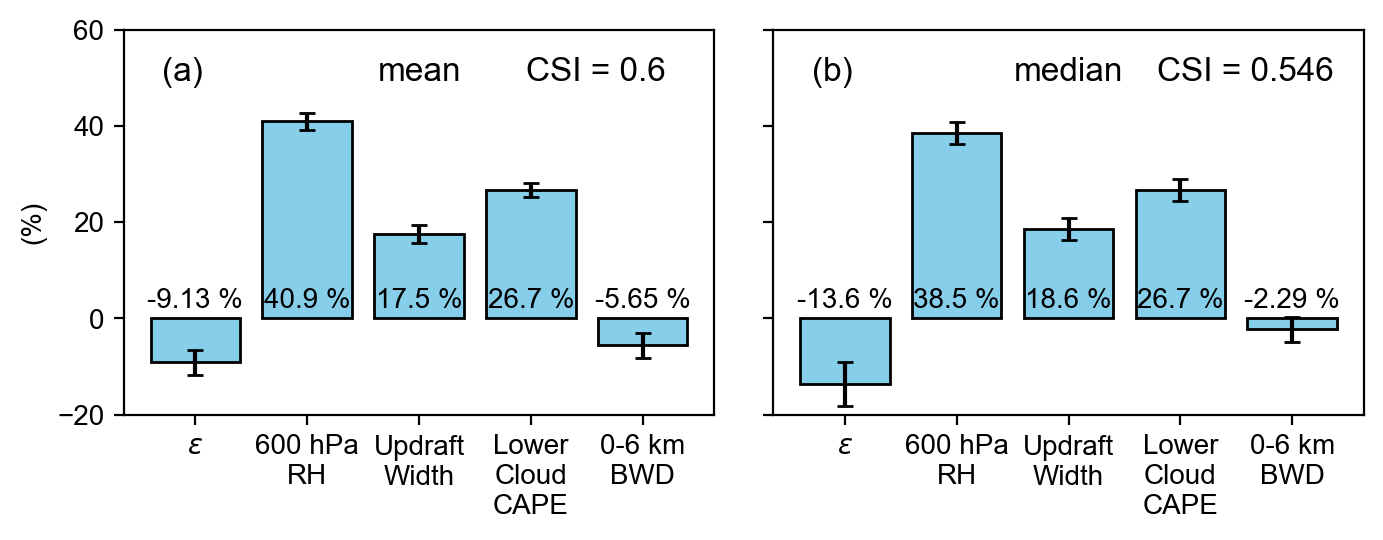

In [204]:
categories = ['$\epsilon$', '600 hPa\nRH', 'Updraft\nWidth', 'Lower\nCloud\nCAPE', '0-6 km\nBWD']
crit =  ['mean','median','max','min']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2.5))
axs = axes.ravel()

format_func = np.vectorize(lambda x: f'{x:.3g}')
formatted_val = format_func(values)
alp = ['(a)','(b)']

for i in range(2):
    asymmetric_error = [lower_errors[i,:], upper_errors[i,:]]
    bars = axs[i].bar(categories, formatted_val[i,:].astype(float), yerr=asymmetric_error, capsize=3, color='skyblue', edgecolor='black')
    axs[i].set_ylim([-20, 60])
    for bar in bars:
        yval = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2, 1, f'{yval}'+' %', ha='center', va='bottom')
    axs[i].text(0.8,0.85,'CSI = '+str(f1s[i,1]),transform=axs[i].transAxes,fontsize=12, ha='center', va='bottom')
    axs[i].text(0.5,0.85,crit[i],transform=axs[i].transAxes,fontsize=12, ha='center', va='bottom')
    axs[i].text(0.1,0.85,alp[i],transform=axs[i].transAxes,fontsize=12, ha='center', va='bottom')

axs[0].set_ylabel('(%)');
# axs[2].set_ylabel('(%)');
# axs[0].set_xticklabels('');
# axs[1].set_xticklabels('');
axs[1].set_yticklabels('');
# axs[3].set_yticklabels('');

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=0.1)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureS6.png',dpi=300, bbox_inches="tight")

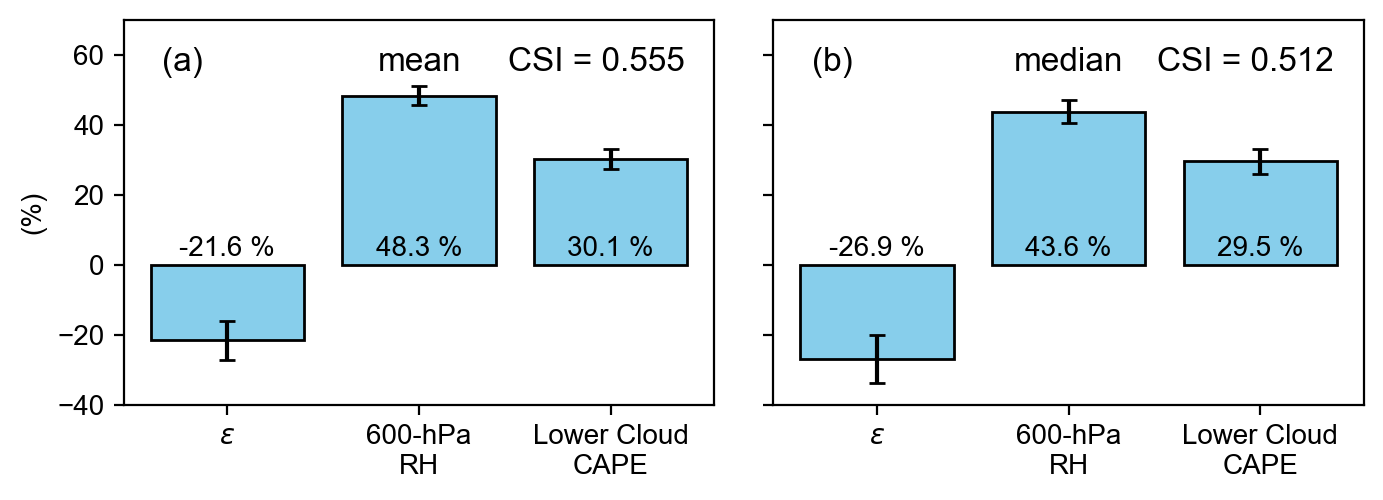

In [347]:
categories = ['$\epsilon$', '600-hPa\nRH', 'Lower Cloud\nCAPE']
crit =  ['mean','median','max','min']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2.5))
axs = axes.ravel()

format_func = np.vectorize(lambda x: f'{x:.3g}')
formatted_val = format_func(values)
alp = ['(a)','(b)']

for i in range(2):
    asymmetric_error = [lower_errors[i,:], upper_errors[i,:]]
    bars = axs[i].bar(categories, formatted_val[i,:].astype(float), yerr=asymmetric_error, capsize=3, color='skyblue', edgecolor='black')
    axs[i].set_ylim([-40, 70])
    for bar in bars:
        yval = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2, 1, f'{yval}'+' %', ha='center', va='bottom')
    axs[i].text(0.8,0.85,'CSI = '+str(f1s[i,1]),transform=axs[i].transAxes,fontsize=12, ha='center', va='bottom')
    axs[i].text(0.5,0.85,crit[i],transform=axs[i].transAxes,fontsize=12, ha='center', va='bottom')
    axs[i].text(0.1,0.85,alp[i],transform=axs[i].transAxes,fontsize=12, ha='center', va='bottom')

axs[0].set_ylabel('(%)');
# axs[2].set_ylabel('(%)');
# axs[0].set_xticklabels('');
# axs[1].set_xticklabels('');
axs[1].set_yticklabels('');
# axs[3].set_yticklabels('');

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=0.1)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureS7.png',dpi=300, bbox_inches="tight")

In [348]:
asymmetric_error

[array([6.8716, 3.2935, 3.5781]), array([6.8716, 3.2935, 3.5781])]

In [92]:
mean_Shr4 =  sx5['shear_mag_bulk_ACBL_mu'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
mean_Shr3 = sx5['shear_mag_bulk_0to6km'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
mean_Shr2 = sx5['shear_mag_bulk_0to3km'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
mean_Shr1 = sx5['shear_mag_bulk_0to1km'].loc[dict(t = rel_time )].mean({'x','y'},skipna='true').isel(cell=subset).load()
max_Shr4 =  sx5['shear_mag_bulk_ACBL_mu'].loc[dict(t = rel_time )].max({'x','y'},skipna='true').isel(cell=subset).load()
max_Shr3 = sx5['shear_mag_bulk_0to6km'].loc[dict(t = rel_time )].max({'x','y'},skipna='true').isel(cell=subset).load()
max_Shr2 = sx5['shear_mag_bulk_0to3km'].loc[dict(t = rel_time )].max({'x','y'},skipna='true').isel(cell=subset).load()
max_Shr1 = sx5['shear_mag_bulk_0to1km'].loc[dict(t = rel_time )].max({'x','y'},skipna='true').isel(cell=subset).load()

In [93]:
# Stitch together the array to be inserted into the RF function
feature_list = ['mean Lower Cloud','mean 0 to 1','mean 0 to 3','mean 0 to 6'\
               ,'max Lower Cloud','max 0 to 1','max 0 to 3','max 0 to 6']

Xt = np.array([mean_Shr1.data,mean_Shr2.data,mean_Shr3.data,mean_Shr4.data\
              ,max_Shr1.data,max_Shr2.data,mean_Shr3.data,max_Shr4.data]).T


In [94]:
n_bootstraps = 100
bootstrap_coefs = np.zeros((n_bootstraps,))
bootstrap_F1 = np.zeros((n_bootstraps))
F1 = np.zeros((2,X.shape[1]))
Coef = np.zeros((2,X.shape[1]))



scaler = StandardScaler()
# logmodel = LogisticRegression(penalty='l2',solver='newton-cg',fit_intercept=True, max_iter=5000, class_weight='balanced')
logmodel = LogisticRegression(penalty='l2',solver='newton-cholesky',fit_intercept=True, max_iter=100, class_weight='balanced')
# Apparently you need to standardize when you add a penalty option.

for i in np.arange(0,X.shape[1]):
    for c in np.arange(0,n_bootstraps):
        X_train, X_test, y_train, y_test = train_test_split(Xt[good_indices],y, train_size=0.7,test_size=0.3,random_state=c,stratify=y)
        X_train_sc = scaler.fit_transform(X_train)
        X_test_sc = scaler.fit_transform(X_test)
        logmodel.fit(X_train_sc[:,i].reshape(-1,1),y_train)
        y_pred = logmodel.predict(X_test_sc[:,i].reshape(-1,1))

        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        bootstrap_F1[c] = tp/(tp+fp+fn)
        # bootstrap_F1[c] = sk.metrics.f1_score(y_test,y_pred).flatten() # For F1 score
        bootstrap_coefs[c] = logmodel.coef_[0]

    Coef[0,i] = np.percentile(bootstrap_coefs, 2.5, axis=0)
    Coef[1,i] = np.percentile(bootstrap_coefs, 97.5, axis=0)
    F1[0,i] = np.percentile(bootstrap_F1, 2.5, axis=0)
    F1[1,i] = np.percentile(bootstrap_F1, 97.5, axis=0)

IndexError: index 8 is out of bounds for axis 1 with size 8

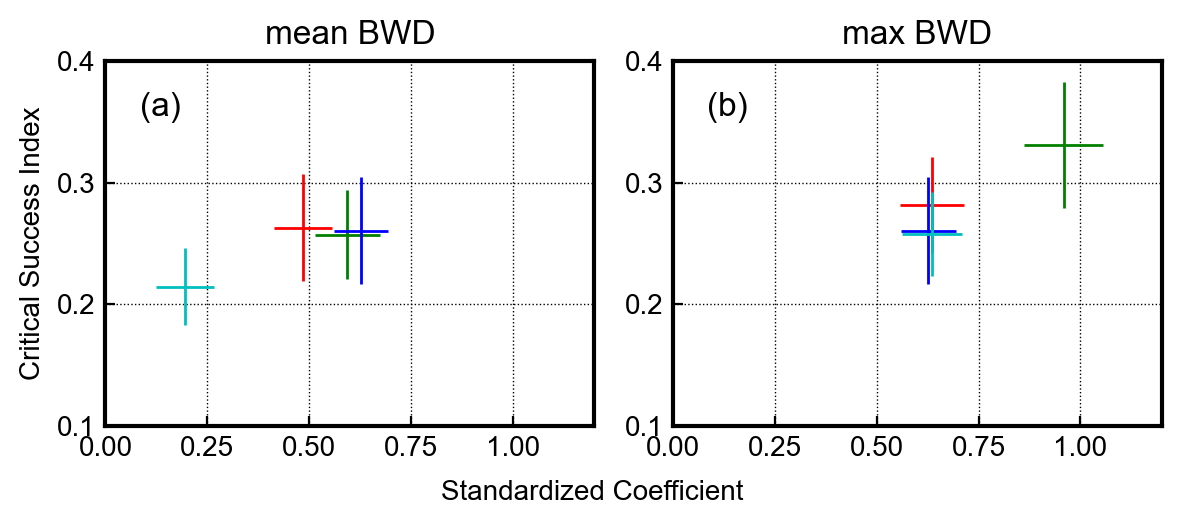

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5))
axes = axes.ravel()

# cc = ['#ffb3ba','#ffdfba','#ffffba','#baffc9','#bae1ff']
cc = ['r','g','b','c']
# cc = ['b','b','b','b','b','b','b']


for i in range(0,4):
    # axes[0].annotate(feature_list[i], ( (Coef[0,i]+Coef[1,i])/2, (F1[0,i]+F1[1,i])/2 ));
    axes[0].hlines((F1[0,i]+F1[1,i])/2, Coef[0,i],Coef[1,i],linewidth=1,colors=cc[i],zorder=3,label=feature_list[i])
    axes[0].vlines((Coef[0,i]+Coef[1,i])/2, F1[0,i],F1[1,i],linewidth=1,colors=cc[i],zorder=3)

for i in range(4,8):
    # axes[1].annotate(feature_list[i], ( (Coef[0,i]+Coef[1,i])/2, (F1[0,i]+F1[1,i])/2 ));
    axes[1].hlines((F1[0,i]+F1[1,i])/2, Coef[0,i],Coef[1,i],linewidth=1,colors=cc[i-4],zorder=3,label=feature_list[i])
    axes[1].vlines((Coef[0,i]+Coef[1,i])/2, F1[0,i],F1[1,i],linewidth=1,colors=cc[i-4],zorder=3)


alp = ['(a)','(b)','(c)','(d)']
tit = ['mean BWD','max BWD']
for c in range(0,2):
    axes[c].text(0.07,0.85,alp[c],transform=axes[c].transAxes,fontsize=12)
    axes[c].set_title(tit[c],fontsize=12)
    axes[c].axvline(0,linestyle=':',color='k',linewidth=1,zorder=1)
    axes[c].set_ylim([0.1,0.4])
    axes[c].set_xlim([0,1.2])
    # axes[c].set_yticks(np.arange(0,0.51,0.1))
    axes[c].tick_params(direction='in')
    # axes[c].grid('on')
    axes[c].grid(color = 'k', linestyle = ':', linewidth = .5)
    for spine in axes[c].spines.values():
            spine.set_linewidth(1.5)
    # axes[c].legend(frameon=False,handlelength=1,loc='upper left', bbox_to_anchor=(1, 1))

# fig.subplots_adjust(right=0.75)
# axs = plt.gca
# axes[2].set_xlabel('Standardized Coefficient');
fig.text(0.5, -0.02, 'Standardized Coefficient', ha='center')
# axes[3].set_xlabel('Standardized Coefficient');
axes[0].set_ylabel('Critical Success Index');
# axes[2].set_ylabel('Critical Success Index');




subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=0.3)

plt.tight_layout()
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureS5.png',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure8_reduced_samples.png',dpi=300)

# Subsampling and Oversampling

In [167]:
X0_train, X0_test, y0_train, y_test = train_test_split(x_0,y_0, train_size=0.957,test_size=0.01,random_state=c,stratify=y_0)
# X1_train, X1_test, y1_train, y_test = train_test_split(x_1,y[ind1], train_size=1,test_size=0.02,random_state=c,stratify=y[ind1])
X2_train, X2_test, y2_train, y_test = train_test_split(x_2,y[ind2], train_size=0.655,test_size=0.01,random_state=c,stratify=y[ind2])
X3_train, X3_test, y3_train, y_test = train_test_split(x_3,y[ind3], train_size=0.833,test_size=0.01,random_state=c,stratify=y[ind3])

In [168]:
X0_train.shape,X1_train.shape,X2_train.shape,X3_train.shape

((377, 20), (373, 20), (377, 20), (377, 20))

In [177]:
# Override "subsets"
# subsets=[(0,8,15),(5,8,15),(0,5,8,15),(0,5,8,15,17)]
subsets=[(8,0,15),(5,8,15),(5,8,0,15),(5,8,0,15,17)]
# subsets=[(0,9,15),(5,9,15),(0,5,9,15),(0,5,9,15,17)]

In [178]:
# Subsampling Method

ind0 = Ct == 0
ind1 = Ct == 1
ind2 = Ct == 2
ind3 = Ct == 3

x_0 = x[ind0,:]
x_1 = x[ind1,:]
x_2 = x[ind2,:]
x_3 = x[ind3,:]

x_0 = np.concatenate((x_0,x_0),axis=0)
y_0 = np.concatenate((y[ind0],y[ind0]),axis=0)

n_bootstraps = 100
bootstrap_F1 = np.zeros((n_bootstraps))
F1 = np.zeros((2,len(subsets)))
Nc = np.zeros((len(subsets),))
Coef = np.zeros((2,len(ordah),len(subsets)))*np.nan
StdC = np.zeros((2,len(ordah),len(subsets)))*np.nan
SgnC = np.zeros((len(ordah),len(subsets)))*np.nan

scaler = StandardScaler()
logmodel = LogisticRegression(penalty='l2',solver='newton-cholesky',fit_intercept=True, max_iter=100, class_weight='balanced')

for i in np.arange(0,len(subsets)):
    bootstrap_coefs = np.zeros((n_bootstraps,len(subsets[i])))
    for c in np.arange(0,n_bootstraps):
        X0_train, X0_test, y0_train, y_test = train_test_split(x_0,y_0, train_size=0.957,test_size=0.01,random_state=c,stratify=y_0)
        # X1_train, X1_test, y1_train, y_test = train_test_split(x_1,y[ind1], train_size=0.99,test_size=0.01,random_state=c,stratify=y[ind1])
        X2_train, X2_test, y2_train, y_test = train_test_split(x_2,y[ind2], train_size=0.655,test_size=0.01,random_state=c,stratify=y[ind2])
        X3_train, X3_test, y3_train, y_test = train_test_split(x_3,y[ind3], train_size=0.833,test_size=0.01,random_state=c,stratify=y[ind3])
        x_sub = np.concatenate((X0_train,x_1,X2_train,X3_train),axis=0)
        y_sub = np.concatenate((y0_train,y[ind1],y2_train,y3_train),axis=0)
        
        X_train, X_test, y_train, y_test = train_test_split(x_sub,y_sub, train_size=0.7,test_size=0.3,random_state=c,stratify=y_sub)
        X_train_sc = scaler.fit_transform(X_train)
        X_test_sc = scaler.fit_transform(X_test)
        logmodel.fit(X_train_sc[:,subsets[i]],y_train);
        y_pred = logmodel.predict(X_test_sc[:,subsets[i]])

        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        bootstrap_F1[c] = tp/(tp+fp+fn)
        # bootstrap_F1[c] = sk.metrics.f1_score(y_test,y_pred).flatten()
        bootstrap_coefs[c,:] = logmodel.coef_[0]
    
    # Calculate 2.5th and 97.5th percentile to form the 95% CI
    Coef[0,:len(subsets[i]),i] = np.percentile(bootstrap_coefs, 2.5, axis=0)
    Coef[1,:len(subsets[i]),i] = np.percentile(bootstrap_coefs, 97.5, axis=0)
    
    F1[0,i] = np.percentile(bootstrap_F1, 2.5, axis=0)
    F1[1,i] = np.percentile(bootstrap_F1, 97.5, axis=0)
    Nc[i] = len(subsets[i])
    StdC[0,:len(logmodel.coef_[0]),i] = Coef[0,:len(subsets[i]),i] / sum(abs(  Coef[0,:len(subsets[i]),i]  ))*100
    StdC[1,:len(logmodel.coef_[0]),i] = Coef[1,:len(subsets[i]),i] / sum(abs(  Coef[1,:len(subsets[i]),i]  ))*100
    SgnC[:len(logmodel.coef_[0]),i] = np.sign(logmodel.coef_[0])

In [181]:
# ascending_indices = np.argsort(F1[1,icorrect]) # This is when you want to only display information about the physically correct LR models
ascending_indices = np.array([0,1,2,3])
descending_indices = ascending_indices[::-1]
# ind2 = np.where(icorrect)[0]
ind2 = np.where(np.array([ True,  True,  True, True]))[0] # Override

values = np.zeros((len(ascending_indices),5))
lower_errors = np.zeros((len(ascending_indices),5))
upper_errors = np.zeros((len(ascending_indices),5))
f1s = np.zeros((len(ascending_indices),4))

for oo in np.arange(0,len(ind2)):
    print('{:<17} {:>10} {:>10} {:>10}'.format('Var','2.5%','50%','97.5%' ))
    c = 0
    for i in subsets[ind2[descending_indices][oo]]:
        p1 = round(StdC[0,c,ind2[descending_indices][oo]],4)
        p2 = round(StdC[1,c,ind2[descending_indices][oo]],4)
        ph = round((p1+p2)/2,4)
        pp = round(ph-p2,4)
        pn = round(ph-p1,4)
        values[oo,c] = ph
        lower_errors[oo,c] = abs(pn)
        upper_errors[oo,c] = abs(pp)
        
        print('{:<17} {:>10} {:>10} {:>10} {:>10} {:>10}'.format( feature_list[i], p1, ph, p2, pn, pp))
        c = c + 1

    p1 = round(F1[0,ind2[descending_indices][oo]],4)
    p2 = round(F1[1,ind2[descending_indices][oo]],4)
    ph = round((p1+p2)/2,3)
    print('{:<17} {:>10} {:>10} {:>10}'.format(' ', p1, ph, p2))
    print(' ')

    f1s[oo,0] = p1
    f1s[oo,1] = ph
    f1s[oo,2] = p2

Var                     2.5%        50%      97.5%
$\epsilon$           -9.1976    -6.3165    -3.4355     2.8811     -2.881
600 mb RH            40.4558    42.6572    44.8585     2.2014    -2.2013
Width                  15.07      17.02    18.9699       1.95    -1.9499
ACBL CAPE            26.8372    28.7449    30.6526     1.9077    -1.9077
0-3 km BWD           -8.4395    -5.2615    -2.0835      3.178     -3.178
                      0.5427      0.604     0.6645
 
Var                     2.5%        50%      97.5%
$\epsilon$          -11.0461    -7.8071    -4.5681      3.239     -3.239
600 mb RH            41.8978    42.4954     43.093     0.5976    -0.5976
Width                17.3237    18.9424    20.5612     1.6187    -1.6188
ACBL CAPE            29.7324     30.755    31.7776     1.0226    -1.0226
                      0.5386      0.596     0.6526
 
Var                     2.5%        50%      97.5%
$\epsilon$          -23.0787   -17.4162   -11.7536     5.6625    -5.6626
600 mb RH  

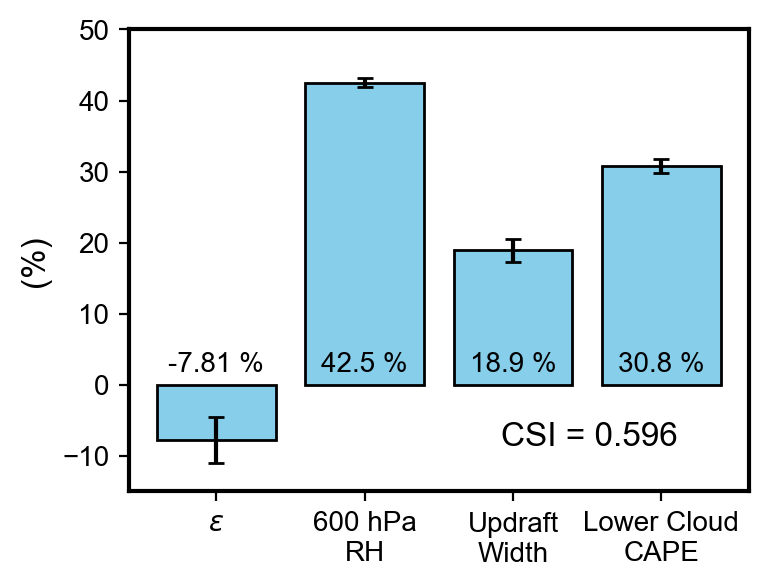

In [186]:
# Subsampling Plot
runn = 1
categories = ['$\epsilon$', '600 hPa\nRH', 'Updraft\nWidth', 'Lower Cloud\nCAPE']


# asymmetric_error = [lower_errors[runn,:-1], upper_errors[runn,:-1]]

format_func = np.vectorize(lambda x: f'{x:.3g}')
formatted_val = format_func(values)

plt.figure(figsize=(4, 3))
asymmetric_error = [lower_errors[runn,:-1], upper_errors[runn,:-1]]
bars = plt.bar(categories, formatted_val[runn,:-1].astype(float), yerr=asymmetric_error, capsize=3, color='skyblue', edgecolor='black')

# Create bar plot

# bars = plt.bar(categories, np.round(values[runn,:-1],2), yerr=asymmetric_error, capsize=3, color='skyblue', edgecolor='black')
# bars = plt.bar(categories, [19.1,-6.83,42.8,31.3], yerr=asymmetric_error, capsize=3, color='skyblue', edgecolor='black')
# plt.title('Coefficients')
plt.ylabel('(%)',fontsize=12);
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
# plt.ylim([-25, 55])
plt.ylim([-15, 50])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 1, f'{yval}'+' %', ha='center', va='bottom')

axs = plt.gca()
for spine in axs.spines.values():
    spine.set_linewidth(1.5)


plt.text(0.6,0.1,'CSI = '+str(f1s[runn,1]),transform=axs.transAxes,fontsize=12)
# plt.text(0.4,0.05,'F1 = '+str(f1s[runn,:]),transform=axs.transAxes,fontsize=12)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureS2.png',dpi=300, bbox_inches="tight")

# (7) Vertical Profiles

In [316]:
# ind_small = (y==0)[:,0]
# ind_large = (y==1)[:,0]
cind0 = ind_small & good_indices
cind1 = ind_large & good_indices

In [317]:
ts1 = (frac_ent_cb*da_tmask_cb*da_belw_cb).mean(dim={'times'}).isel(tracks=subset[cind0]).squeeze()
ts2 = (CoreWidth_cb*da_tmask_cb).mean(dim={'times'}).isel(tracks=subset[cind0]).squeeze()
ts3 = (CoreMeanW_up*da_tmask_cb).mean(dim={'times'}).isel(tracks=subset[cind0]).squeeze()
ts4 = (CoreMaxW_up*da_tmask_cb).mean(dim={'times'}).isel(tracks=subset[cind0]).squeeze()
ts5 = (CoreMassFlux_up*da_tmask_cb).mean(dim={'times'}).isel(tracks=subset[cind0]).squeeze()
ts6 = (CoreBuoyThtv_up_cb*da_tmask_cb).mean(dim={'times'}).isel(tracks=subset[cind0]).squeeze()
ts7 = (CoreRHMean_pr6*da_tmask_cb*da_belw_cb).mean(dim={'times'}).isel(tracks=subset[cind0]).squeeze()
ts8 = (CoreThtePert_c6*da_tmask_cb*da_belw_cb).mean(dim={'times'}).isel(tracks=subset[cind0]).squeeze()

td1 = (frac_ent_cb*da_tmask_cb*da_belw_cb).mean(dim={'times'}).isel(tracks=subset[cind1]).squeeze()
td2 = (CoreWidth_cb*da_tmask_cb).mean(dim={'times'}).isel(tracks=subset[cind1]).squeeze()
td3 = (CoreMeanW_up*da_tmask_cb).mean(dim={'times'}).isel(tracks=subset[cind1]).squeeze()
td4 = (CoreMaxW_up*da_tmask_cb).mean(dim={'times'}).isel(tracks=subset[cind1]).squeeze()
td5 = (CoreMassFlux_up*da_tmask_cb).mean(dim={'times'}).isel(tracks=subset[cind1]).squeeze()
td6 = (CoreBuoyThtv_up_cb*da_tmask_cb).mean(dim={'times'}).isel(tracks=subset[cind1]).squeeze()
td7 = (CoreRHMean_pr6*da_tmask_cb*da_belw_cb).mean(dim={'times'}).isel(tracks=subset[cind1]).squeeze()
td8 = (CoreThtePert_c6*da_tmask_cb*da_belw_cb).mean(dim={'times'}).isel(tracks=subset[cind1]).squeeze()

In [318]:
tmp1 = ts1.to_dataframe(name='fE')
tmp2 = ts2.to_dataframe(name='Width')
tmp3 = ts3.to_dataframe(name='MeanW')
tmp4 = ts4.to_dataframe(name='MaxW')
tmp5 = ts5.to_dataframe(name='MassFlux')
tmp6 = ts6.to_dataframe(name='Buoyancy')
tmp7 = ts7.to_dataframe(name='Shell RH')
tmp8 = ts8.to_dataframe(name='Shell Thte')

tmp11 = td1.to_dataframe(name='fE')
tmp22 = td2.to_dataframe(name='Width')
tmp33 = td3.to_dataframe(name='MeanW')
tmp44 = td4.to_dataframe(name='MaxW')
tmp55 = td5.to_dataframe(name='MassFlux')
tmp66 = td6.to_dataframe(name='Buoyancy')
tmp77 = td7.to_dataframe(name='Shell RH')
tmp88 = td8.to_dataframe(name='Shell Thte')

In [319]:
alpha = 0.05

stat1, p1 = mannwhitneyu(ts1, td1, axis=0, nan_policy='omit')
stat2, p2 = mannwhitneyu(ts2, td2, axis=0, nan_policy='omit')
stat3, p3 = mannwhitneyu(ts3, td3, axis=0, nan_policy='omit')
stat4, p4 = mannwhitneyu(ts4, td4, axis=0, nan_policy='omit')
stat5, p5 = mannwhitneyu(ts5, td5, axis=0, nan_policy='omit')
stat6, p6 = mannwhitneyu(ts6, td6, axis=0, nan_policy='omit')
stat7, p7 = mannwhitneyu(ts7, td7, axis=0, nan_policy='omit')
stat8, p8 = mannwhitneyu(ts8, td8, axis=0, nan_policy='omit')

p1 = [1 if x < alpha else 0 for x in p1]
p2 = [1 if x < alpha else 0 for x in p2]
p3 = [1 if x < alpha else 0 for x in p3]
p4 = [1 if x < alpha else 0 for x in p4]
p5 = [1 if x < alpha else 0 for x in p5]
p6 = [1 if x < alpha else 0 for x in p6]
p7 = [1 if x < alpha else 0 for x in p7]
p8 = [1 if x < alpha else 0 for x in p8]

In [320]:
pp = np.array([p1,p2,p3,p4,p5,p6,p7,p8])
pp = pp[:,:40]
pp.shape

(8, 40)

In [321]:
f1 = tmp2.dropna(subset=['Width'])
hc1 = (f1.groupby('z').size()/f1.groupby('z').size().max()).reset_index(name='sample_count')
f2 = tmp22.dropna(subset=['Width'])
hc2 = (f2.groupby('z').size()/f2.groupby('z').size().max()).reset_index(name='sample_count')

In [322]:
f1 = tmp1.dropna(subset=['fE'])
hc3 = (f1.groupby('z').size()/f1.groupby('z').size().max()).reset_index(name='sample_count')
f2 = tmp11.dropna(subset=['fE'])
hc4 = (f2.groupby('z').size()/f2.groupby('z').size().max()).reset_index(name='sample_count')

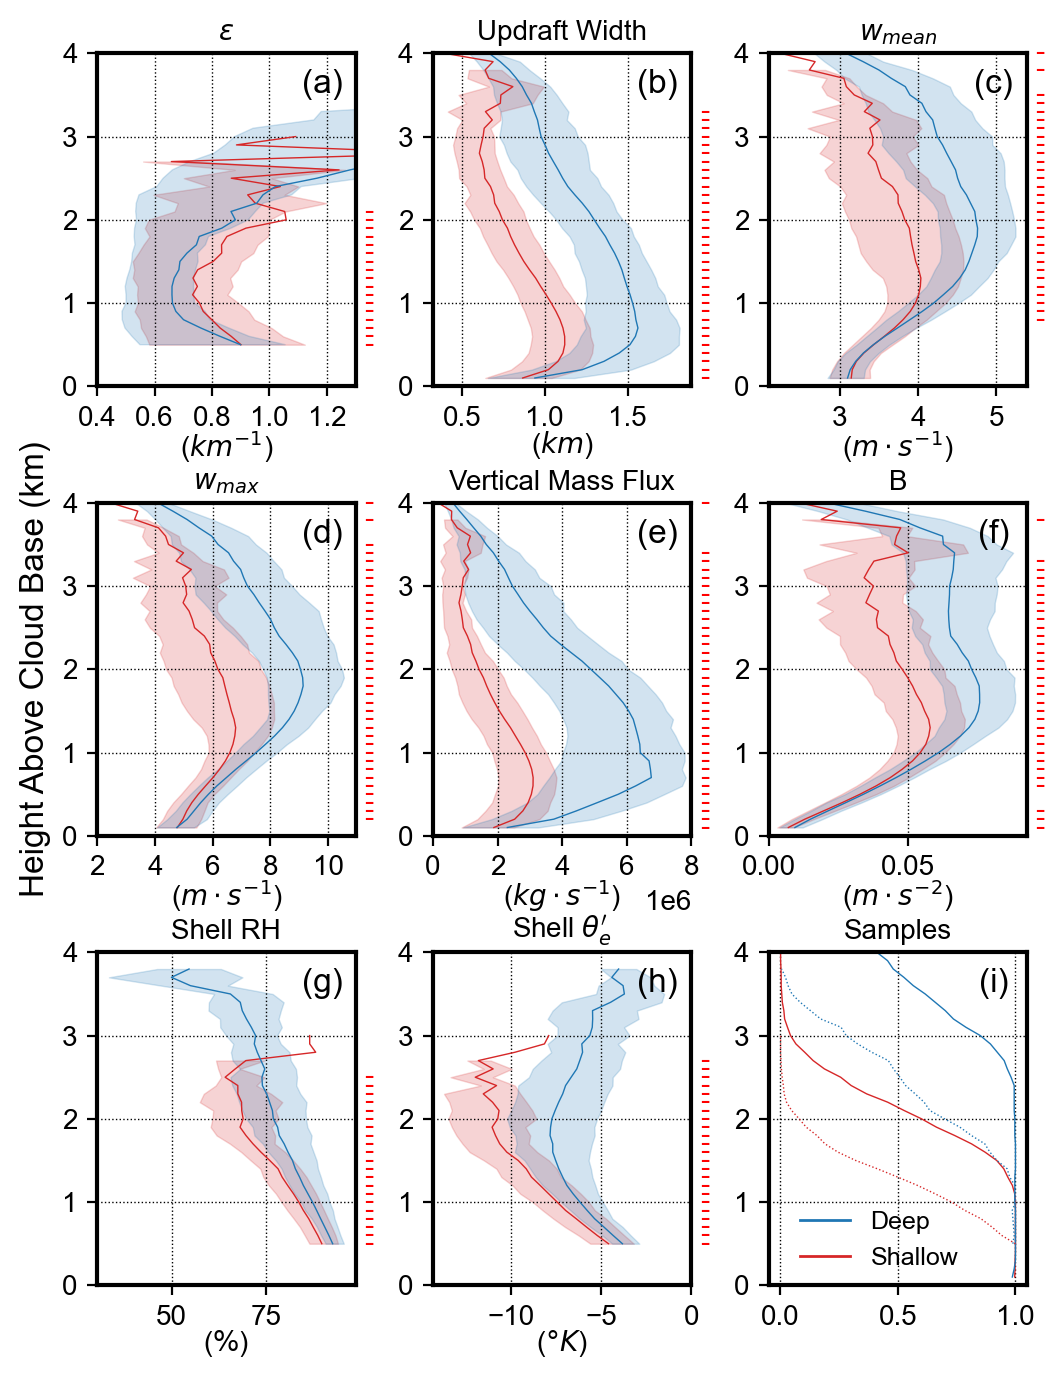

In [324]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 8))
axs = axes.ravel()

lw = .5
eb = 50
# sns.lineplot(data=tmp1, x="fE"   , y="z", orient="y",ax = axs[0],color='tab:red',errorbar=('pi',eb),err_kws={'edgecolor': 'none'});
sns.lineplot(data=tmp1, x="fE"   , y="z", orient="y",ax = axs[0],color='tab:red',errorbar=('pi',eb),linewidth=lw);
sns.lineplot(data=tmp11, x="fE"   , y="z", orient="y",ax = axs[0],color='tab:blue',errorbar=('pi',eb),linewidth=lw);

sns.lineplot(data=tmp2, x="Width"  , y="z", orient="y",ax = axs[1],color='tab:red',errorbar=('pi',eb),linewidth=lw);
sns.lineplot(data=tmp22, x="Width"  , y="z", orient="y",ax = axs[1],color='tab:blue',errorbar=('pi',eb),linewidth=lw);

sns.lineplot(data=tmp3, x="MeanW"  , y="z", orient="y",ax = axs[2],color='tab:red',errorbar=('pi',eb),linewidth=lw);
sns.lineplot(data=tmp33, x="MeanW"  , y="z", orient="y",ax = axs[2],color='tab:blue',errorbar=('pi',eb),linewidth=lw);

sns.lineplot(data=tmp4, x="MaxW"  , y="z", orient="y",ax = axs[3],color='tab:red',errorbar=('pi',eb),linewidth=lw);
sns.lineplot(data=tmp44, x="MaxW"  , y="z", orient="y",ax = axs[3],color='tab:blue',errorbar=('pi',eb),linewidth=lw);

sns.lineplot(data=tmp5, x="MassFlux"  , y="z", orient="y",ax = axs[4],color='tab:red',errorbar=('pi',eb),linewidth=lw);
sns.lineplot(data=tmp55, x="MassFlux"  , y="z", orient="y",ax = axs[4],color='tab:blue',errorbar=('pi',eb),linewidth=lw);

sns.lineplot(data=tmp6, x="Buoyancy"  , y="z", orient="y",ax = axs[5],color='tab:red',errorbar=('pi',eb),linewidth=lw);
sns.lineplot(data=tmp66, x="Buoyancy"  , y="z", orient="y",ax = axs[5],color='tab:blue',errorbar=('pi',eb),linewidth=lw);

sns.lineplot(data=tmp7, x="Shell RH" , y="z", orient="y",ax = axs[6],color='tab:red',errorbar=('pi',eb),linewidth=lw);
sns.lineplot(data=tmp77, x="Shell RH" , y="z", orient="y",ax = axs[6],color='tab:blue',errorbar=('pi',eb),linewidth=lw);

sns.lineplot(data=tmp8, x="Shell Thte"   , y="z", orient="y",ax = axs[7],color='tab:red',errorbar=('pi',eb),linewidth=lw);
sns.lineplot(data=tmp88, x="Shell Thte"   , y="z", orient="y",ax = axs[7],color='tab:blue',errorbar=('pi',eb),linewidth=lw);

sns.lineplot(data=hc1, x="sample_count"   , y="z", orient="y",ax = axs[8],color='tab:red',linewidth=lw);
sns.lineplot(data=hc2, x="sample_count"   , y="z", orient="y",ax = axs[8],color='tab:blue',linewidth=lw);
sns.lineplot(data=hc3, x="sample_count"   , y="z", orient="y",ax = axs[8],color='tab:red',linestyle=':',linewidth=lw);
sns.lineplot(data=hc4, x="sample_count"   , y="z", orient="y",ax = axs[8],color='tab:blue',linestyle=':',linewidth=lw);

axs[0].set_xlim([0,2])

for i in np.arange(0,8):
    for z in np.arange(0,40):
        if pp[i,z] == 1:
            axs[i].text(1.05,(z+1)/40,'-',color='r',transform=axs[i].transAxes,fontsize=10,ha='center',va='center')
        # else:
            #axs[i].text(1.05,(z+1)/40,'x',color='k',transform=axs[i].transAxes,fontsize=4,ha='center',va='center')

alp = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q']
cna = [r'$\epsilon$','Updraft Width',r'$w_{mean}$',r'$w_{max}$','Vertical Mass Flux','B','Shell RH',r'Shell $\theta_e^{\prime}$','Samples']
uni = [r'($km^{-1}$)',r'($km$)',r'($m \cdot s^{-1}$)',r'($m \cdot s^{-1}$)'\
      ,r'($kg\cdot s^{-1}$)',r'($m\cdot s^{-2}$)',r'($\%$)',r'($\degree K$)','']

for i in np.arange(0,9):
    axs[i].set_ylabel('')
    # axs[i].set_xlabel('')
    axs[i].set_xlabel(uni[i],labelpad=-1)
    axs[i].text(0.87,.88,'('+alp[i]+')',transform=axs[i].transAxes,fontsize=12,ha='center')
    axs[i].text(0.5,1.04,cna[i],transform=axs[i].transAxes,fontsize=10,ha='center')
    axs[i].grid(color = 'k', linestyle = ':', linewidth = 0.5)
    axs[i].set_ylim([0,4000])
    axs[i].set_yticks(np.arange(0,4100,1000))
    axs[i].set_yticklabels(np.arange(0,4.1,1).astype(int))
    # axs[i].tick_params(direction='in')
    # axs[i].lines[0].set_linewidth(2)
    # axs[i].lines[1].set_linewidth(2)
    for collection in axs[i].collections:
        collection.set_linewidth(.5)
    for spine in axs[i].spines.values():
            spine.set_linewidth(1.5)

axs[0].set_xlim([0.4,1.3])
axs[0].set_xticks(np.arange(0.4,1.3,0.2))

axs[3].set_xticks(np.arange(2,12,2))


axs[4].set_xticks(np.arange(0,10e6,2e6))
axs[4].set_xlim([0,8e6])

# axs[5].set_xticks(np.arange(0,0.11,0.025))
axs[5].set_xlim([0,None])

axs[3].set_ylabel('Height Above Cloud Base (km)',fontsize=12)



axs[7].set_xlim([None,0])

legend_labels = ['Deep', 'Shallow']
handles = [plt.Line2D([0], [0], color='tab:blue', lw=1),
           plt.Line2D([0], [0], color='tab:red', lw=1)]
axs[8].legend(handles=handles, labels=legend_labels,facecolor='none',edgecolor='none',loc='best', bbox_to_anchor=(.32, -.02, 0.5, 0.5),fontsize=9)

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=0.35)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure7.png',dpi=300, bbox_inches="tight")

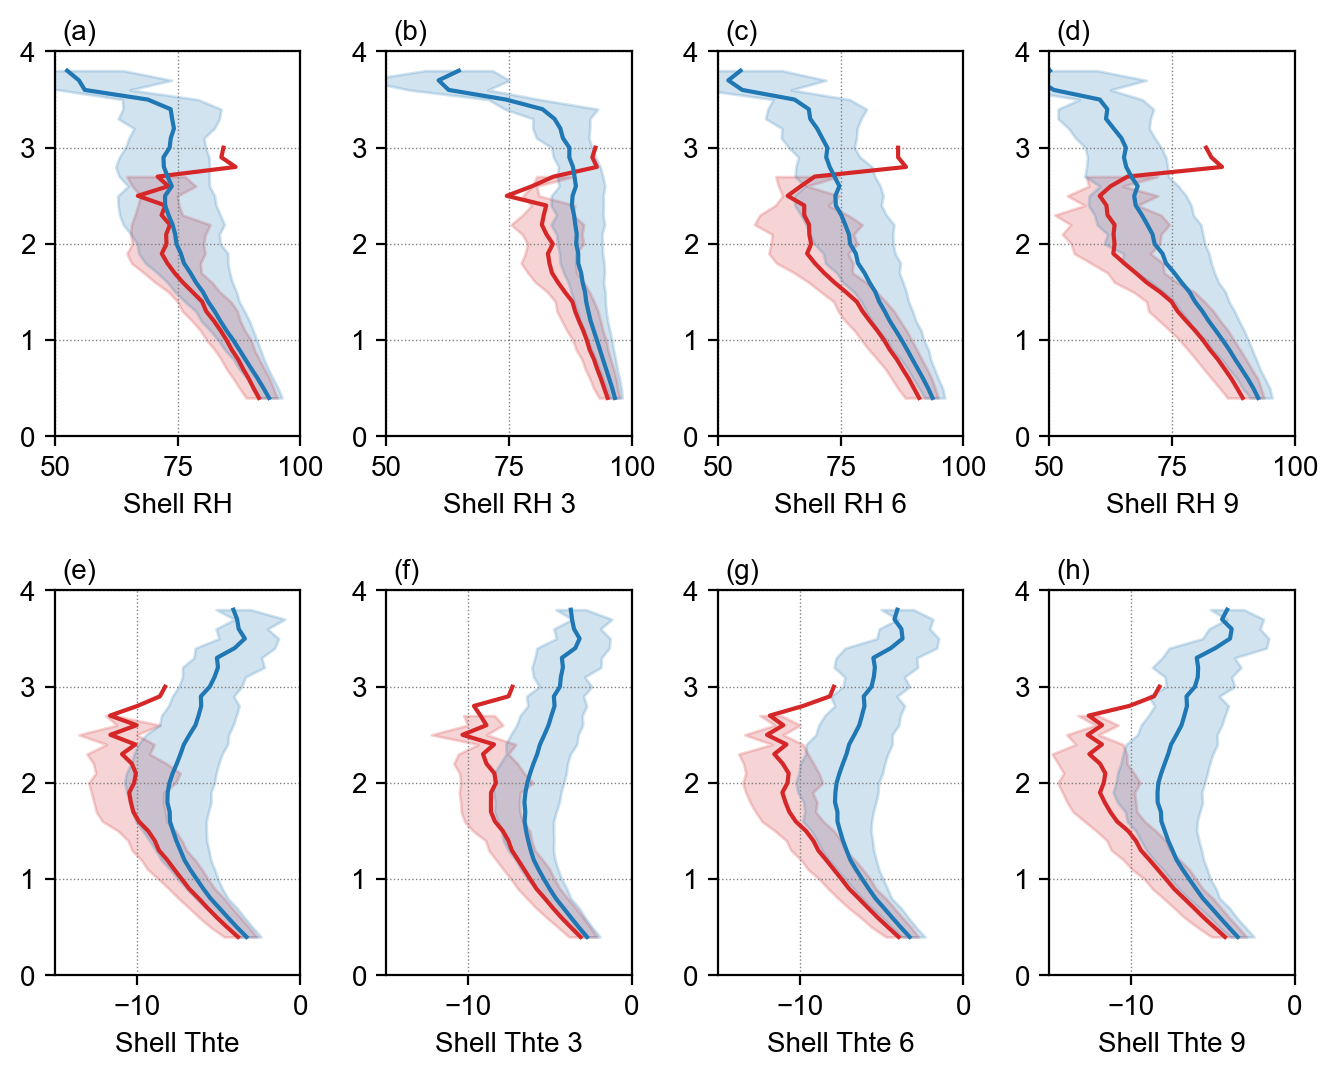

In [99]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 6))
axs = axes.ravel()

eb = 50

sns.lineplot(data=tmp7, x="Shell RH" , y="z", orient="y",ax = axs[0],color='tab:red',errorbar=('pi',eb));
sns.lineplot(data=tmp77, x="Shell RH" , y="z", orient="y",ax = axs[0],color='tab:blue',errorbar=('pi',eb));

sns.lineplot(data=rh3, x="Shell RH 3" , y="z", orient="y",ax = axs[1],color='tab:red',errorbar=('pi',eb));
sns.lineplot(data=rh33, x="Shell RH 3" , y="z", orient="y",ax = axs[1],color='tab:blue',errorbar=('pi',eb));

sns.lineplot(data=rh6, x="Shell RH 6" , y="z", orient="y",ax = axs[2],color='tab:red',errorbar=('pi',eb));
sns.lineplot(data=rh66, x="Shell RH 6" , y="z", orient="y",ax = axs[2],color='tab:blue',errorbar=('pi',eb));

sns.lineplot(data=rh9, x="Shell RH 9" , y="z", orient="y",ax = axs[3],color='tab:red',errorbar=('pi',eb));
sns.lineplot(data=rh99, x="Shell RH 9" , y="z", orient="y",ax = axs[3],color='tab:blue',errorbar=('pi',eb));

sns.lineplot(data=tmp8, x="Shell Thte"   , y="z", orient="y",ax = axs[4],color='tab:red',errorbar=('pi',eb));
sns.lineplot(data=tmp88, x="Shell Thte"   , y="z", orient="y",ax = axs[4],color='tab:blue',errorbar=('pi',eb));

sns.lineplot(data=th3, x="Shell Thte 3" , y="z", orient="y",ax = axs[5],color='tab:red',errorbar=('pi',eb));
sns.lineplot(data=th33, x="Shell Thte 3" , y="z", orient="y",ax = axs[5],color='tab:blue',errorbar=('pi',eb));

sns.lineplot(data=th6, x="Shell Thte 6" , y="z", orient="y",ax = axs[6],color='tab:red',errorbar=('pi',eb));
sns.lineplot(data=th66, x="Shell Thte 6" , y="z", orient="y",ax = axs[6],color='tab:blue',errorbar=('pi',eb));

sns.lineplot(data=th9, x="Shell Thte 9" , y="z", orient="y",ax = axs[7],color='tab:red',errorbar=('pi',eb));
sns.lineplot(data=th99, x="Shell Thte 9" , y="z", orient="y",ax = axs[7],color='tab:blue',errorbar=('pi',eb));


alp = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q']
# cna = [r'$\epsilon$','Width',r'$w_{mean}$',r'$w_{max}$','VMF','B','Shell RH',r'Shell $\theta_e^{\prime}$','Samples']
# uni = [r'($km^{-1}$)',r'($km$)',r'($m \cdot s^{-1}$)',r'($m \cdot s^{-1}$)'\
#       ,r'($kg\cdot s^{-1}$)',r'($m\cdot s^{-2}$)',r'($\%$)',r'($\degree K$)','']

for i in np.arange(0,8):
    axs[i].set_ylabel('')
    # axs[i].set_xlabel('')
    # axs[i].set_xlabel(uni[i])
    axs[i].text(0.03,1.03,'('+alp[i]+')',transform=axs[i].transAxes,fontsize=10)
    # axs[i].text(0.5,1.03,cna[i],transform=axs[i].transAxes,fontsize=10,ha='center')
    axs[i].grid(color = 'gray', linestyle = ':', linewidth = 0.5)
    axs[i].set_ylim([0,4000])
    axs[i].set_yticks(np.arange(0,4100,1000))
    axs[i].set_yticklabels(np.arange(0,4.1,1).astype(int))

for i in np.arange(0,4):
    axs[i].set_xlim([50,100])

for i in np.arange(4,8):
    axs[i].set_xlim([-15,0])
# axs[3].set_ylabel('Height Above Cloud Base (km)')
# axs[0].set_xlim([0.4,1.3])
# axs[4].set_xlim([0,None])
# axs[5].set_xlim([0,None])
# axs[7].set_xlim([None,0])

legend_labels = ['Deep', 'Shallow']
handles = [plt.Line2D([0], [0], color='tab:blue', lw=2),
           plt.Line2D([0], [0], color='tab:red', lw=2)]
# axs[6].legend(handles=handles, labels=legend_labels,facecolor='none',edgecolor='none',loc='best', bbox_to_anchor=(.32, -.02, 0.5, 0.5),fontsize=9)

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.35, hspace=0.4)

# Histograms

In [325]:
tmp1 = np.concatenate((x[:,8:],Ct[:,np.newaxis],ch[good_indices,np.newaxis],y),axis=1)
tmp1[:,(3,4,5)] = tmp1[:,(3,4,5)]/1000
tmp1[:,6] = tmp1[:,6]/1000
tmp1[:,7] = tmp1[:,7]/10

In [326]:
# column_names = ['Width (log)', 'Frac. Entr. (log)', 'RH 500mb', 'RH 600mb', 'RH 700mb', 'CAPE (w)', 'EL (log)', 'Date', 'Heights','Shallow/Deep']
# column_names = ['Width (log)', 'Frac. Entr. (log)', 'RH 600mb', 'ACBL CAPE (w)', 'Date', 'Heights','Shallow/Deep']
# column_names = ['RH ACBL','RH 600mb','CAPE ACBL (W)', 'Date', 'Heights','Shallow/Deep']
column_names = feature_list[8:]+['Date','Heights','Category']
df = pd.DataFrame(tmp1, columns=column_names)

In [327]:
date_mapping = {0: '29 Nov', 1: '4 Dec', 2: '23 Jan', 3: '29 Jan'}
df['Date'] = df['Date'].map(date_mapping)
df['Category'] = df['Category'].map({0: 'Shallow', 1: 'Deep'})

In [328]:
# Statistical Significance Test
a1 = df[(df['Category'] == 'Shallow')&(df['Date'] == '29 Nov')].iloc[:, 0:12]
a2 = df[(df['Category'] == 'Deep')&(df['Date'] == '29 Nov')].iloc[:, 0:12]

b2 = df[(df['Category'] == 'Shallow')&(df['Date'] == '4 Dec')].iloc[:, 0:12]
b1 = df[(df['Category'] == 'Deep')&(df['Date'] == '4 Dec')].iloc[:, 0:12]

c1 = df[(df['Category'] == 'Shallow')&(df['Date'] == '23 Jan')].iloc[:, 0:12]
c2 = df[(df['Category'] == 'Deep')&(df['Date'] == '23 Jan')].iloc[:, 0:12]

d1 = df[(df['Category'] == 'Shallow')&(df['Date'] == '29 Jan')].iloc[:, 0:12]
d2 = df[(df['Category'] == 'Deep')&(df['Date'] == '29 Jan')].iloc[:, 0:12]

# Perform the Mann-Whitney U test
stat1, p1 = mannwhitneyu(a1, a2)
stat2, p2 = mannwhitneyu(b1, b2)
stat3, p3 = mannwhitneyu(c1, c2)
stat4, p4 = mannwhitneyu(d1, d2)

# Interpretation
alpha = 0.05
pp1 = [1 if x < alpha else 0 for x in p1]
pp2 = [1 if x < alpha else 0 for x in p2]
pp3 = [1 if x < alpha else 0 for x in p3]
pp4 = [1 if x < alpha else 0 for x in p4]
pp = np.array([pp1,pp2,pp3,pp4])
# oo = np.arange(0,12,1)
oo = [3,4,0,1,2,8,9,10,11,5,6,7]

# Need to look carefully here.
for i in range(len(p1)):
    print("{:<15} {:>10}".format( column_names[oo[i]], str(pp[:,oo[i]]) ))


LCL              [0 0 1 1]
LFC              [0 0 1 1]
600 hPa RH       [1 1 1 1]
700 hPa RH       [1 1 1 1]
ACBL RH          [1 1 1 1]
0-1 km BWD       [1 1 1 1]
0-3 km BWD       [1 1 1 1]
0-6 km BWD       [0 1 1 1]
ACBL BWD         [1 0 1 1]
EL               [1 1 0 0]
CAPE             [1 1 1 0]
ACBL CAPE        [1 1 1 0]


In [329]:
pp = pp[:,oo]

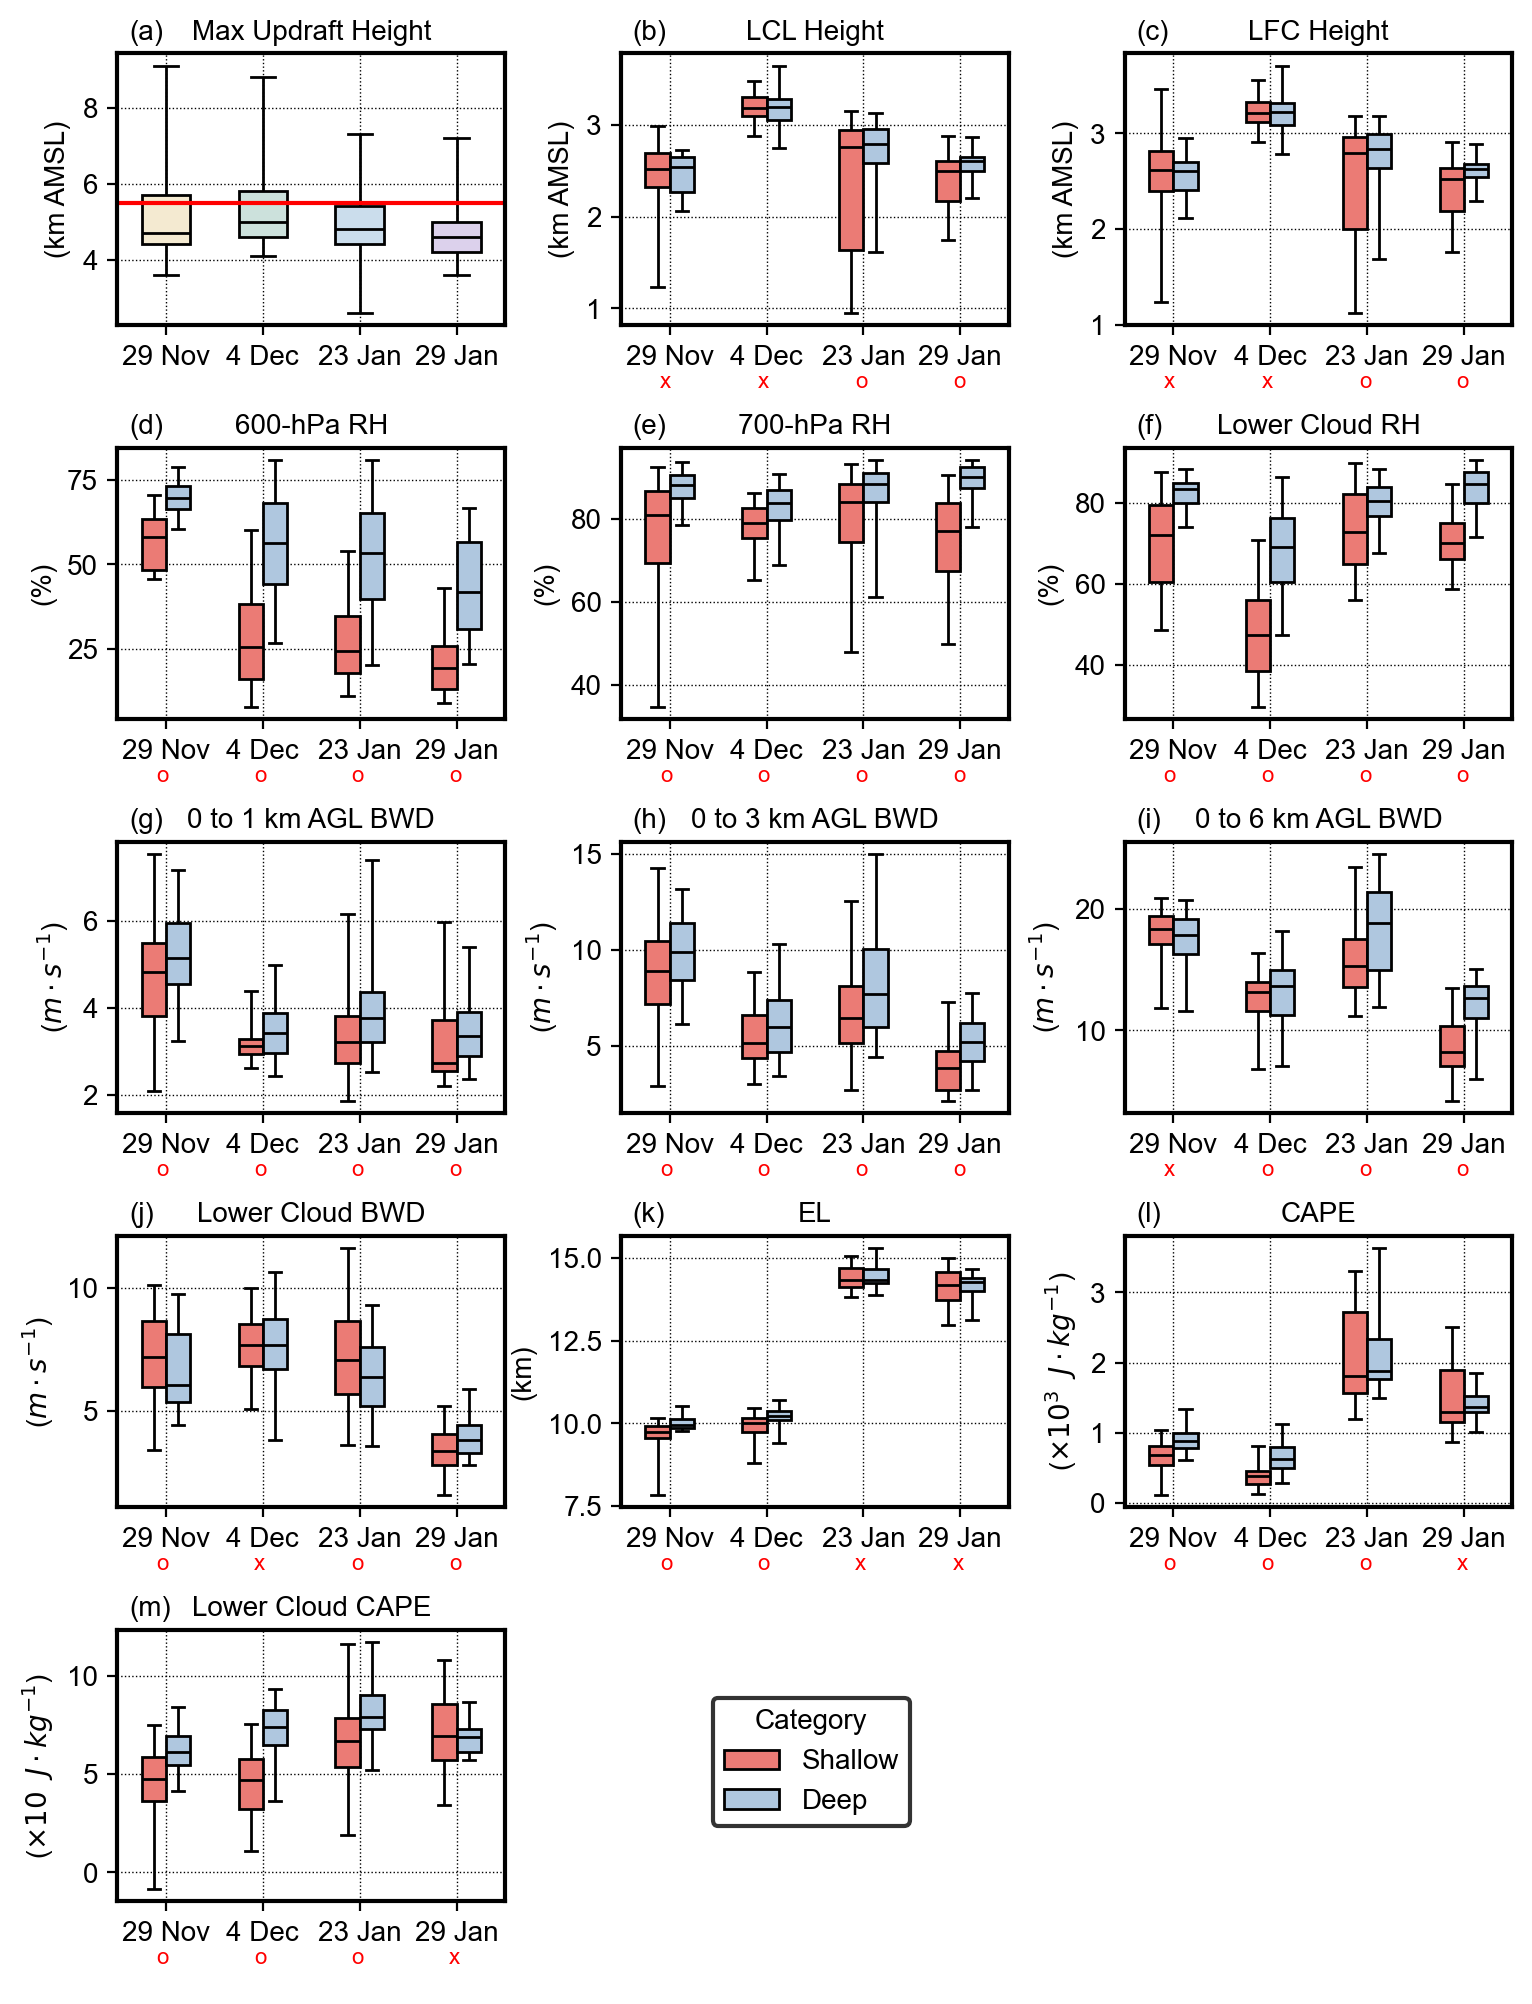

In [330]:
fig, axs = plt.subplots(5, 3, figsize=(9, 12))
axs = axs.ravel()

pal0 = ['#FAEDCB','#C9E4DE','#C6DEF1','#DBCDF0']
# pal = ['#FAEDCB','#C6DEF1']
pal = ['#FF6961','#A7C7E7']

# gs = GridSpec(5, 3, figure=fig)
# ax1 = fig.add_subplot(gs[0,:2])
# ax1.set_xlabel(' ')
# ax1.set_ylabel('(km)')
# ax1.set_title('Max Updraft Heights',fontsize=11)


# sns.violinplot(data=df, x='Date', y='Heights'      ,palette=pal0,ax=ax1,legend=False);

# Create a boxplot
# plt.figure(figsize=(8, 6))

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.boxplot(data=df, x='Date', y='Heights'      ,whis=(2.5, 97.5),showfliers=False, palette=pal0,width=.5,ax=axs[0],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='LCL'          ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[1],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='LFC'          ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[2],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='600 hPa RH'    ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[3],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='700 hPa RH'    ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[4],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='ACBL RH'      ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[5],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='0-1 km BWD'   ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[6],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='0-3 km BWD'   ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[7],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='0-6 km BWD'   ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[8],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='ACBL BWD'     ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[9],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='EL'           ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[10],legend=False,**PROPS);
# sns.boxplot(data=df, x='Date', y='TCWV'         ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[11],legend=False,**PROPS);
sns.boxplot(data=df, x='Date', y='CAPE'         ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[11],legend=False,**PROPS);
g = sns.boxplot(data=df, x='Date', y='ACBL CAPE',hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[12],**PROPS);

sns.move_legend(g, "upper left", bbox_to_anchor=(1.5, .8), frameon=True)
legend = g.legend_
legend.get_frame().set_edgecolor('black')  # Set the border color
legend.get_frame().set_linewidth(1.5) 

# sns.violinplot(data=df, x='Date', y='CAPE ACBL (W)',hue = 'Shallow/Deep',palette=pal,ax=axs[1],legend=False);
# sns.violinplot(data=df, x='Date', y='RH ACBL'      ,hue = 'Shallow/Deep',palette=pal,ax=axs[2],legend=False);
# sns.violinplot(data=df, x='Date', y='RH 600mb'     ,hue = 'Shallow/Deep',palette=pal,ax=axs[3],legend=False);

axs[0].axhline(5.5,color='red')

# axs[0].axis('off')
axs[-1].axis('off')
axs[-2].axis('off')

uni = ['(km AMSL)','(km AMSL)','(km AMSL)','(%)','(%)','(%)',r'($m\cdot s^{-1}$)',r'($m\cdot s^{-1}$)',r'($m\cdot s^{-1}$)',r'($m\cdot s^{-1}$)','(km)',r'($\times 10^{3}$  $J\cdot kg^{-1}$)',r'($\times 10$  $J\cdot kg^{-1}$)','s']
alp = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q']
cna = ['Max Updr. Hgt.','LCL Height','LFC Height'\
       ,'600-hPa RH','700-hPa RH','Lower Cloud RH'\
       ,'0 to 1 km AGL BWD','0 to 3 km AGL BWD','0 to 6 km AGL BWD'\
       ,'Lower Cloud BWD','EL'\
       ,'CAPE','Lower Cloud CAPE','Date','Heights','Shallow/Deep']

axs[0].set_ylabel('(km AMSL)')
axs[0].set_xlabel('')
axs[0].text(0.03,1.05,'(a)',transform=axs[0].transAxes,fontsize=10)
axs[0].text(0.5,1.05,'Max Updraft Height',transform=axs[0].transAxes,fontsize=10,ha='center')

for c in np.arange(1,13):
    axs[c].text(0.03,1.05,'('+alp[c]+')',transform=axs[c].transAxes,fontsize=10)
    axs[c].text(0.5,1.05,cna[c],transform=axs[c].transAxes,fontsize=10,ha='center')
    axs[c].set_xlabel(' ')
    axs[c].set_ylabel(uni[c])
    for d in range(4):
        if pp[d,c-1] == 1:
            axs[c].text(.1+0.252*d,-0.23,'o',transform=axs[c].transAxes,fontsize=8,color='r')
        else:
            axs[c].text(.1+0.252*d,-0.23,'x',transform=axs[c].transAxes,fontsize=8,color='r')

for c in np.arange(0,13):
    axs[c].grid(color = 'k', linestyle = ':', linewidth = 0.5)
    for spine in axs[c].spines.values():
        spine.set_linewidth(1.5)
    

# plt.xlabel('Date')
# plt.ylabel('Width')
# plt.title('Boxplot of Width by Date')
# plt.show()

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=0.45)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure6.png',dpi=300, bbox_inches="tight")

In [996]:
tmp1 = np.concatenate((x[:,:8],Ct[:,np.newaxis],ch[good_indices,np.newaxis],y),axis=1)

In [997]:
column_names = feature_list[:8]+['Date','Heights','Category']
df = pd.DataFrame(tmp1, columns=column_names)

In [998]:
date_mapping = {0: '29 Nov', 1: '4 Dec', 2: '23 Jan', 3: '29 Jan'}
df['Date'] = df['Date'].map(date_mapping)
df['Category'] = df['Category'].map({0: 'Shallow', 1: 'Deep'})

In [999]:
# Statistical Significance Test
a1 = df[(df['Category'] == 'Shallow')&(df['Date'] == '29 Nov')].iloc[:, :-3]
a2 = df[(df['Category'] == 'Deep')&(df['Date'] == '29 Nov')].iloc[:, :-3]

b2 = df[(df['Category'] == 'Shallow')&(df['Date'] == '4 Dec')].iloc[:, :-3]
b1 = df[(df['Category'] == 'Deep')&(df['Date'] == '4 Dec')].iloc[:, :-3]

c1 = df[(df['Category'] == 'Shallow')&(df['Date'] == '23 Jan')].iloc[:, :-3]
c2 = df[(df['Category'] == 'Deep')&(df['Date'] == '23 Jan')].iloc[:, :-3]

d1 = df[(df['Category'] == 'Shallow')&(df['Date'] == '29 Jan')].iloc[:, :-3]
d2 = df[(df['Category'] == 'Deep')&(df['Date'] == '29 Jan')].iloc[:, :-3]

# Perform the Mann-Whitney U test
stat1, p1 = mannwhitneyu(a1, a2)
stat2, p2 = mannwhitneyu(b1, b2)
stat3, p3 = mannwhitneyu(c1, c2)
stat4, p4 = mannwhitneyu(d1, d2)

# Interpretation
alpha = 0.05
pp1 = [1 if x < alpha else 0 for x in p1]
pp2 = [1 if x < alpha else 0 for x in p2]
pp3 = [1 if x < alpha else 0 for x in p3]
pp4 = [1 if x < alpha else 0 for x in p4]
pp = np.array([pp1,pp2,pp3,pp4])
# oo = [3,4,0,1,2,8,9,10,11,5,12,6,7]

# Need to look carefully here.
for i in range(len(p1)):
    # print("{:<15} {:>10}".format( column_names[oo[i]], str(pp[:,oo[i]]) ))
    print("{:<15} {:>10}".format( column_names[i], str(pp[:,i]) ))

# pp = pp[:,oo]

Width            [1 1 1 1]
$w_{max}$        [1 1 1 0]
$w_{mean}$       [1 0 1 1]
VMF              [1 1 1 1]
B                [0 1 1 0]
$\epsilon$       [0 1 1 1]
Shell RH         [0 1 1 1]
Shell $\theta_e^{\prime}$  [0 1 1 1]


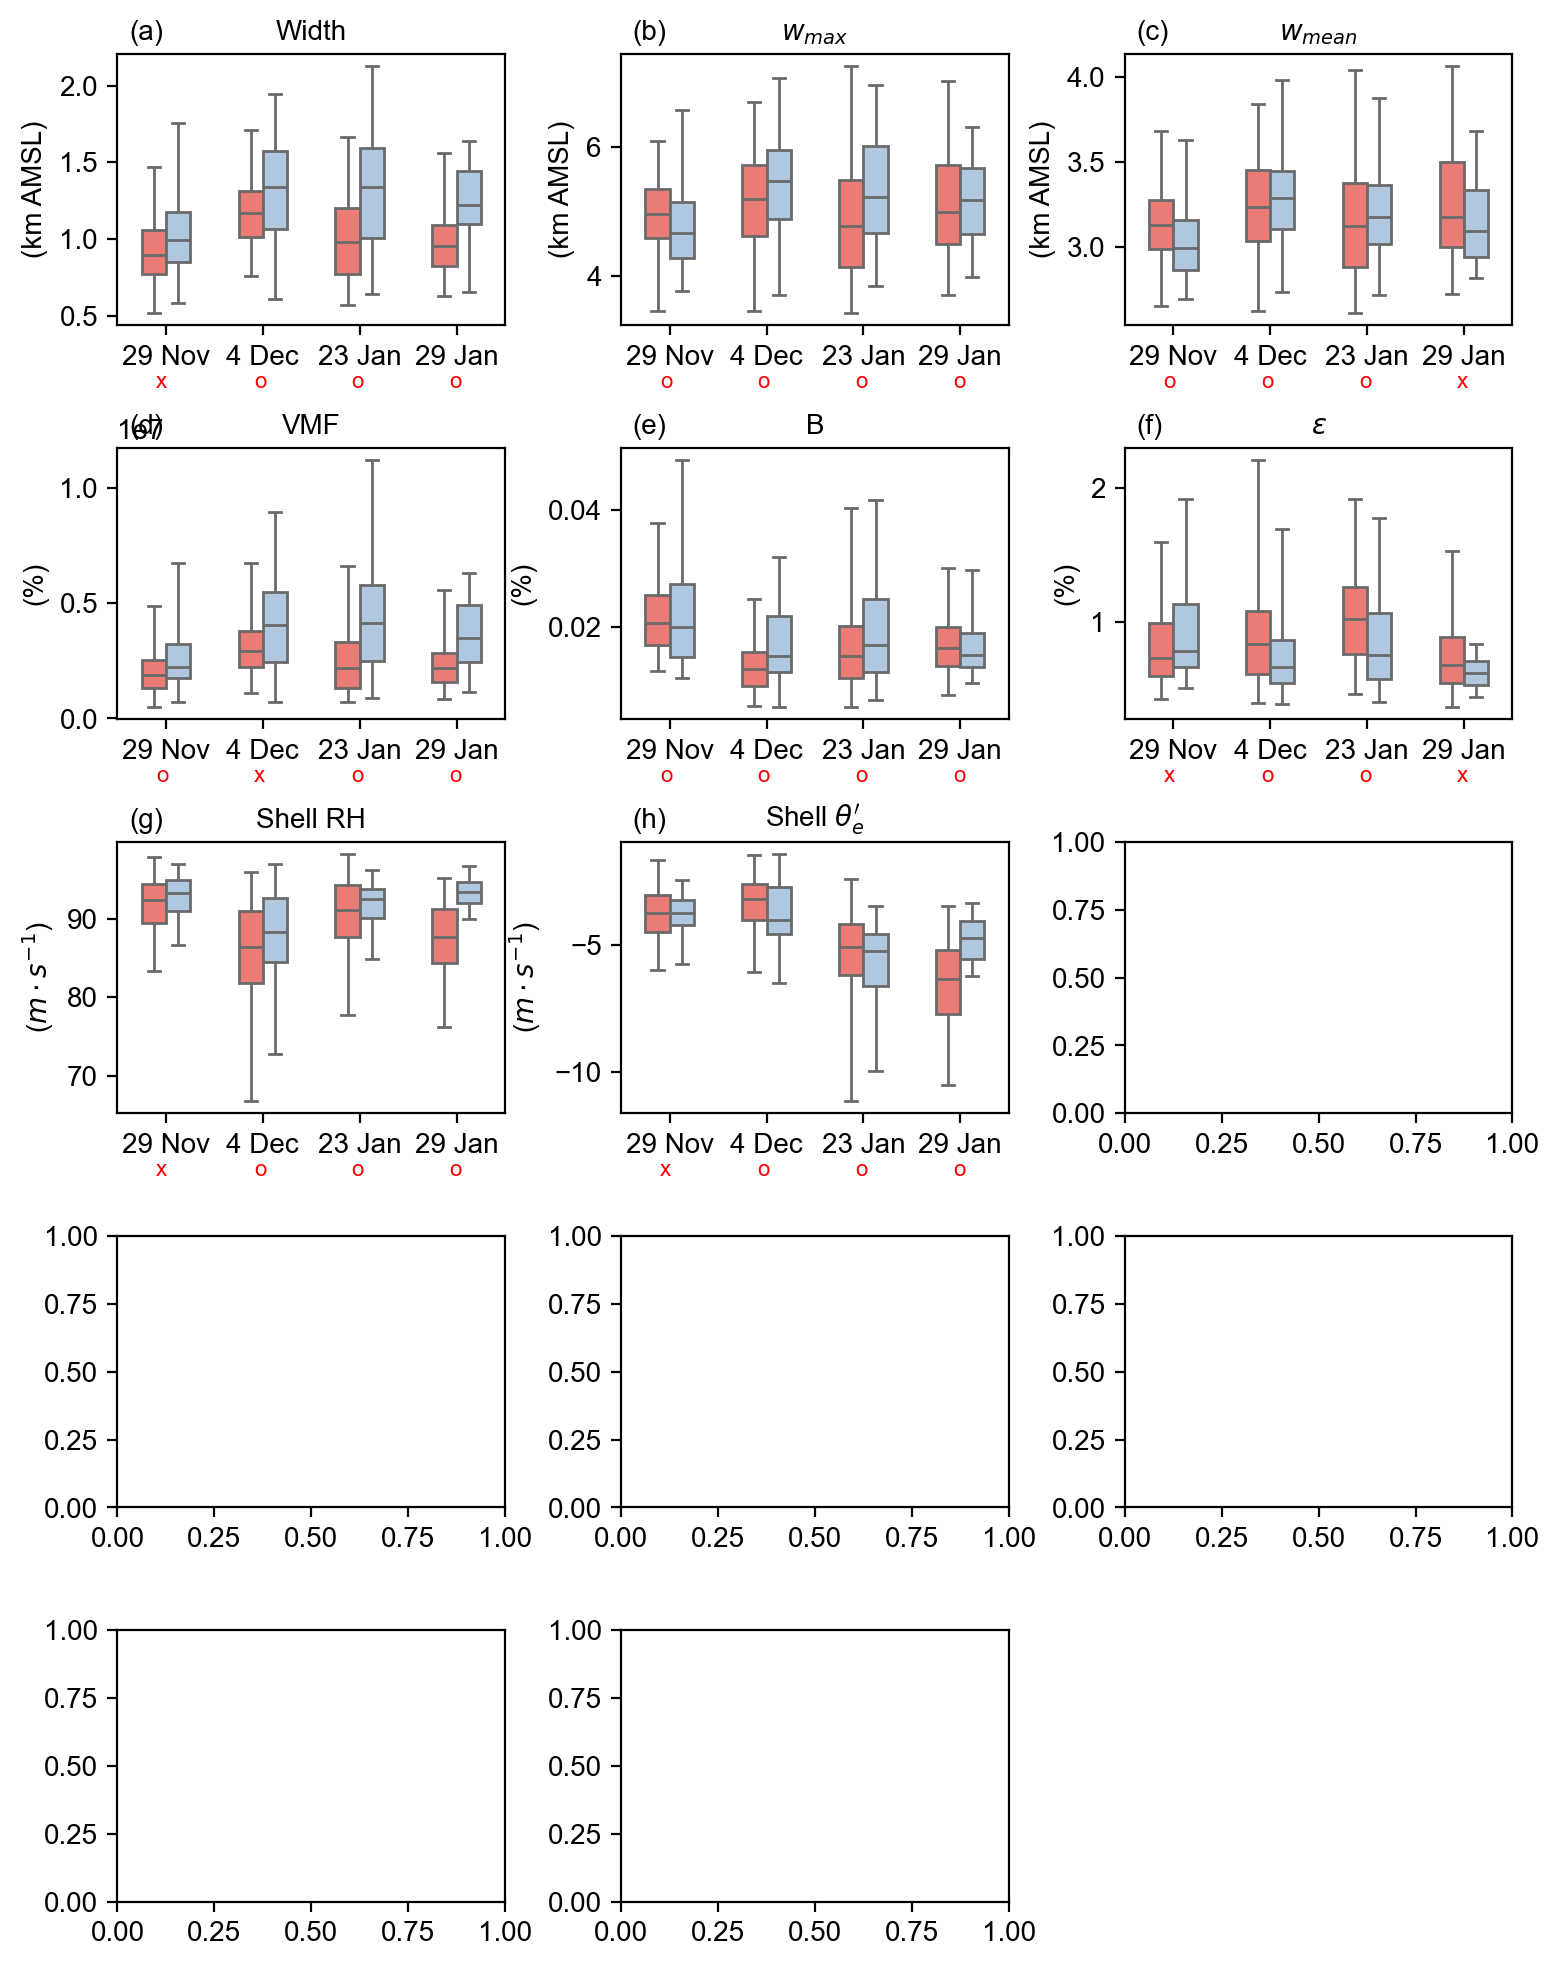

In [1006]:
fig, axs = plt.subplots(5, 3, figsize=(9, 12))
axs = axs.ravel()

pal0 = ['#FAEDCB','#C9E4DE','#C6DEF1','#DBCDF0']
# pal = ['#FAEDCB','#C6DEF1']
pal = ['#FF6961','#A7C7E7']

# gs = GridSpec(5, 3, figure=fig)
# ax1 = fig.add_subplot(gs[0,:2])
# ax1.set_xlabel(' ')
# ax1.set_ylabel('(km)')
# ax1.set_title('Max Updraft Heights',fontsize=11)


# sns.violinplot(data=df, x='Date', y='Heights'      ,palette=pal0,ax=ax1,legend=False);

# Create a boxplot
# plt.figure(figsize=(8, 6))

sns.boxplot(data=df, x='Date', y='Width'          ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[0],legend=False);
sns.boxplot(data=df, x='Date', y='$w_{max}$'      ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[1],legend=False);
sns.boxplot(data=df, x='Date', y='$w_{mean}$'     ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[2],legend=False);
sns.boxplot(data=df, x='Date', y='VMF'            ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[3],legend=False);
sns.boxplot(data=df, x='Date', y='B'              ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[4],legend=False);
sns.boxplot(data=df, x='Date', y='$\epsilon$'     ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[5],legend=False);
sns.boxplot(data=df, x='Date', y='Shell RH'       ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[6],legend=False);
sns.boxplot(data=df, x='Date', y=r'Shell $\theta_e^{\prime}$'   ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[7],legend=False);
# sns.boxplot(data=df, x='Date', y='0-6 km BWD'   ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[8],legend=False);
# sns.boxplot(data=df, x='Date', y='ACBL BWD'     ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[9],legend=False);
# sns.boxplot(data=df, x='Date', y='EL'           ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[10],legend=False);
# sns.boxplot(data=df, x='Date', y='TCWV'         ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[11],legend=False);
# sns.boxplot(data=df, x='Date', y='CAPE'         ,hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[12],legend=False);
# g = sns.boxplot(data=df, x='Date', y='ACBL CAPE',hue = 'Category',whis=(2.5, 97.5),showfliers=False, palette=pal,width=.5,ax=axs[13]);

sns.move_legend(g, "upper left", bbox_to_anchor=(1.5, .8), frameon=False)

# sns.violinplot(data=df, x='Date', y='CAPE ACBL (W)',hue = 'Shallow/Deep',palette=pal,ax=axs[1],legend=False);
# sns.violinplot(data=df, x='Date', y='RH ACBL'      ,hue = 'Shallow/Deep',palette=pal,ax=axs[2],legend=False);
# sns.violinplot(data=df, x='Date', y='RH 600mb'     ,hue = 'Shallow/Deep',palette=pal,ax=axs[3],legend=False);

# axs[0].axhline(5.5,color='red')

# axs[0].axis('off')
axs[-1].axis('off')

uni = ['(km AMSL)','(km AMSL)','(km AMSL)','(%)','(%)','(%)',r'($m\cdot s^{-1}$)',r'($m\cdot s^{-1}$)',r'($m\cdot s^{-1}$)',r'($m\cdot s^{-1}$)','(km)','(cm)',r'($\times 10^{3}$  $J\cdot kg^{-1}$)',r'($\times 10$  $J\cdot kg^{-1}$)','s']
alp = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q']
cna = ['Max Updr. Hgt.','LCL Height','LFC Height'\
       ,'600 mb RH','700 mb RH','Lower Cloud RH'\
       ,'0 to 1 km AGL BWD','0 to 3 km AGL BWD','0 to 6 km AGL BWD'\
       ,'Lower Cloud BWD','EL','TCWV'\
       ,'CAPE','Lower Cloud CAPE','Date','Heights','Shallow/Deep']

# axs[0].set_ylabel('(km AMSL)')
# axs[0].set_xlabel('')
# axs[0].text(0.03,1.05,'(a)',transform=axs[0].transAxes,fontsize=10)
# axs[0].text(0.5,1.05,'Max Updraft Height',transform=axs[0].transAxes,fontsize=10,ha='center')

for c in np.arange(0,8):
    axs[c].text(0.03,1.05,'('+alp[c]+')',transform=axs[c].transAxes,fontsize=10)
    axs[c].text(0.5,1.05,feature_list[c],transform=axs[c].transAxes,fontsize=10,ha='center')
    axs[c].set_xlabel(' ')
    axs[c].set_ylabel(uni[c])
    for d in range(4):
        if pp[d,c-1] == 1:
            axs[c].text(.1+0.252*d,-0.23,'o',transform=axs[c].transAxes,fontsize=8,color='r')
        else:
            axs[c].text(.1+0.252*d,-0.23,'x',transform=axs[c].transAxes,fontsize=8,color='r')

    
    
# plt.xlabel('Date')
# plt.ylabel('Width')
# plt.title('Boxplot of Width by Date')
# plt.show()

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=0.45)
# plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure6.png',dpi=300, bbox_inches="tight")

# (8) Correlogram

In [210]:
cch = xr.DataArray(ch,coords=cw.coords,dims=cw.dims)

In [265]:
# All Dates
df_updr = pd.DataFrame({"Height": cch[good_indices].to_pandas()\
                        ,"Width": cw[good_indices].to_pandas()\
                       ,"Frac. Entr.": cf[good_indices].to_pandas()\
                       ,"VMF": cmf[good_indices].to_pandas()\
                       ,"Max W": cu[good_indices].to_pandas()\
                       ,"Mean W": cmu[good_indices].to_pandas()\
                       ,"Buoyancy": cb[good_indices].to_pandas()\
                      ,"RH 600 hPa": rh_600mb[good_indices].to_pandas()\
                      ,"RH 700 hPa": rh_700mb[good_indices].to_pandas()\
                      ,"RH ACBL": RHLFC1500[good_indices].to_pandas()\
                      ,"RH Shell": csr6[good_indices].to_pandas()\
                      ,r"$\theta_e'$ Shell": cp6[good_indices].to_pandas()\
                      ,"ACBL CAPE": MUCAPE_acbl[good_indices].to_pandas()\
                      ,"CAPE": MUCAPE[good_indices].to_pandas()\
                      ,"EL": MUEL[good_indices].to_pandas()\
                      ,"LCL": MULCL[good_indices].to_pandas()\
                      ,"LFC": MULFC[good_indices].to_pandas()\
                      ,"BWD 01": BlkShr_0to1km[good_indices].to_pandas()\
                      ,"BWD 03": BlkShr_0to3km[good_indices].to_pandas()\
                      ,"BWD 06": BlkShr_0to6km[good_indices].to_pandas()\
                      ,"BWD ACBL": BlkShr_acbl[good_indices].to_pandas()\
                  })

In [266]:
corr_matrix = df_updr.corr()

pval_matrix = pd.DataFrame(np.ones(corr_matrix.shape), columns=corr_matrix.columns, index=corr_matrix.index)

for i in range(len(df_updr.columns)):
    for j in range(i+1,len(df_updr.columns)):
        corr, p_value = pearsonr(df_updr.iloc[:, i], df_updr.iloc[:, j])
        pval_matrix.iloc[i, j] = p_value
        pval_matrix.iloc[j, i] = p_value

# Apply a significance level (e.g., 0.05)
significance_level = 0.05
significant_corrs = df_updr.where(pval_matrix <= significance_level)

In [267]:
upper_triangle_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# upper_triangle_mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
# upper_triangle_mask = np.triu(np.ones((corr.shape[0], corr.shape[1])), k=1).astype(bool)
combined_mask = pval_matrix > significance_level
combined_mask |= upper_triangle_mask

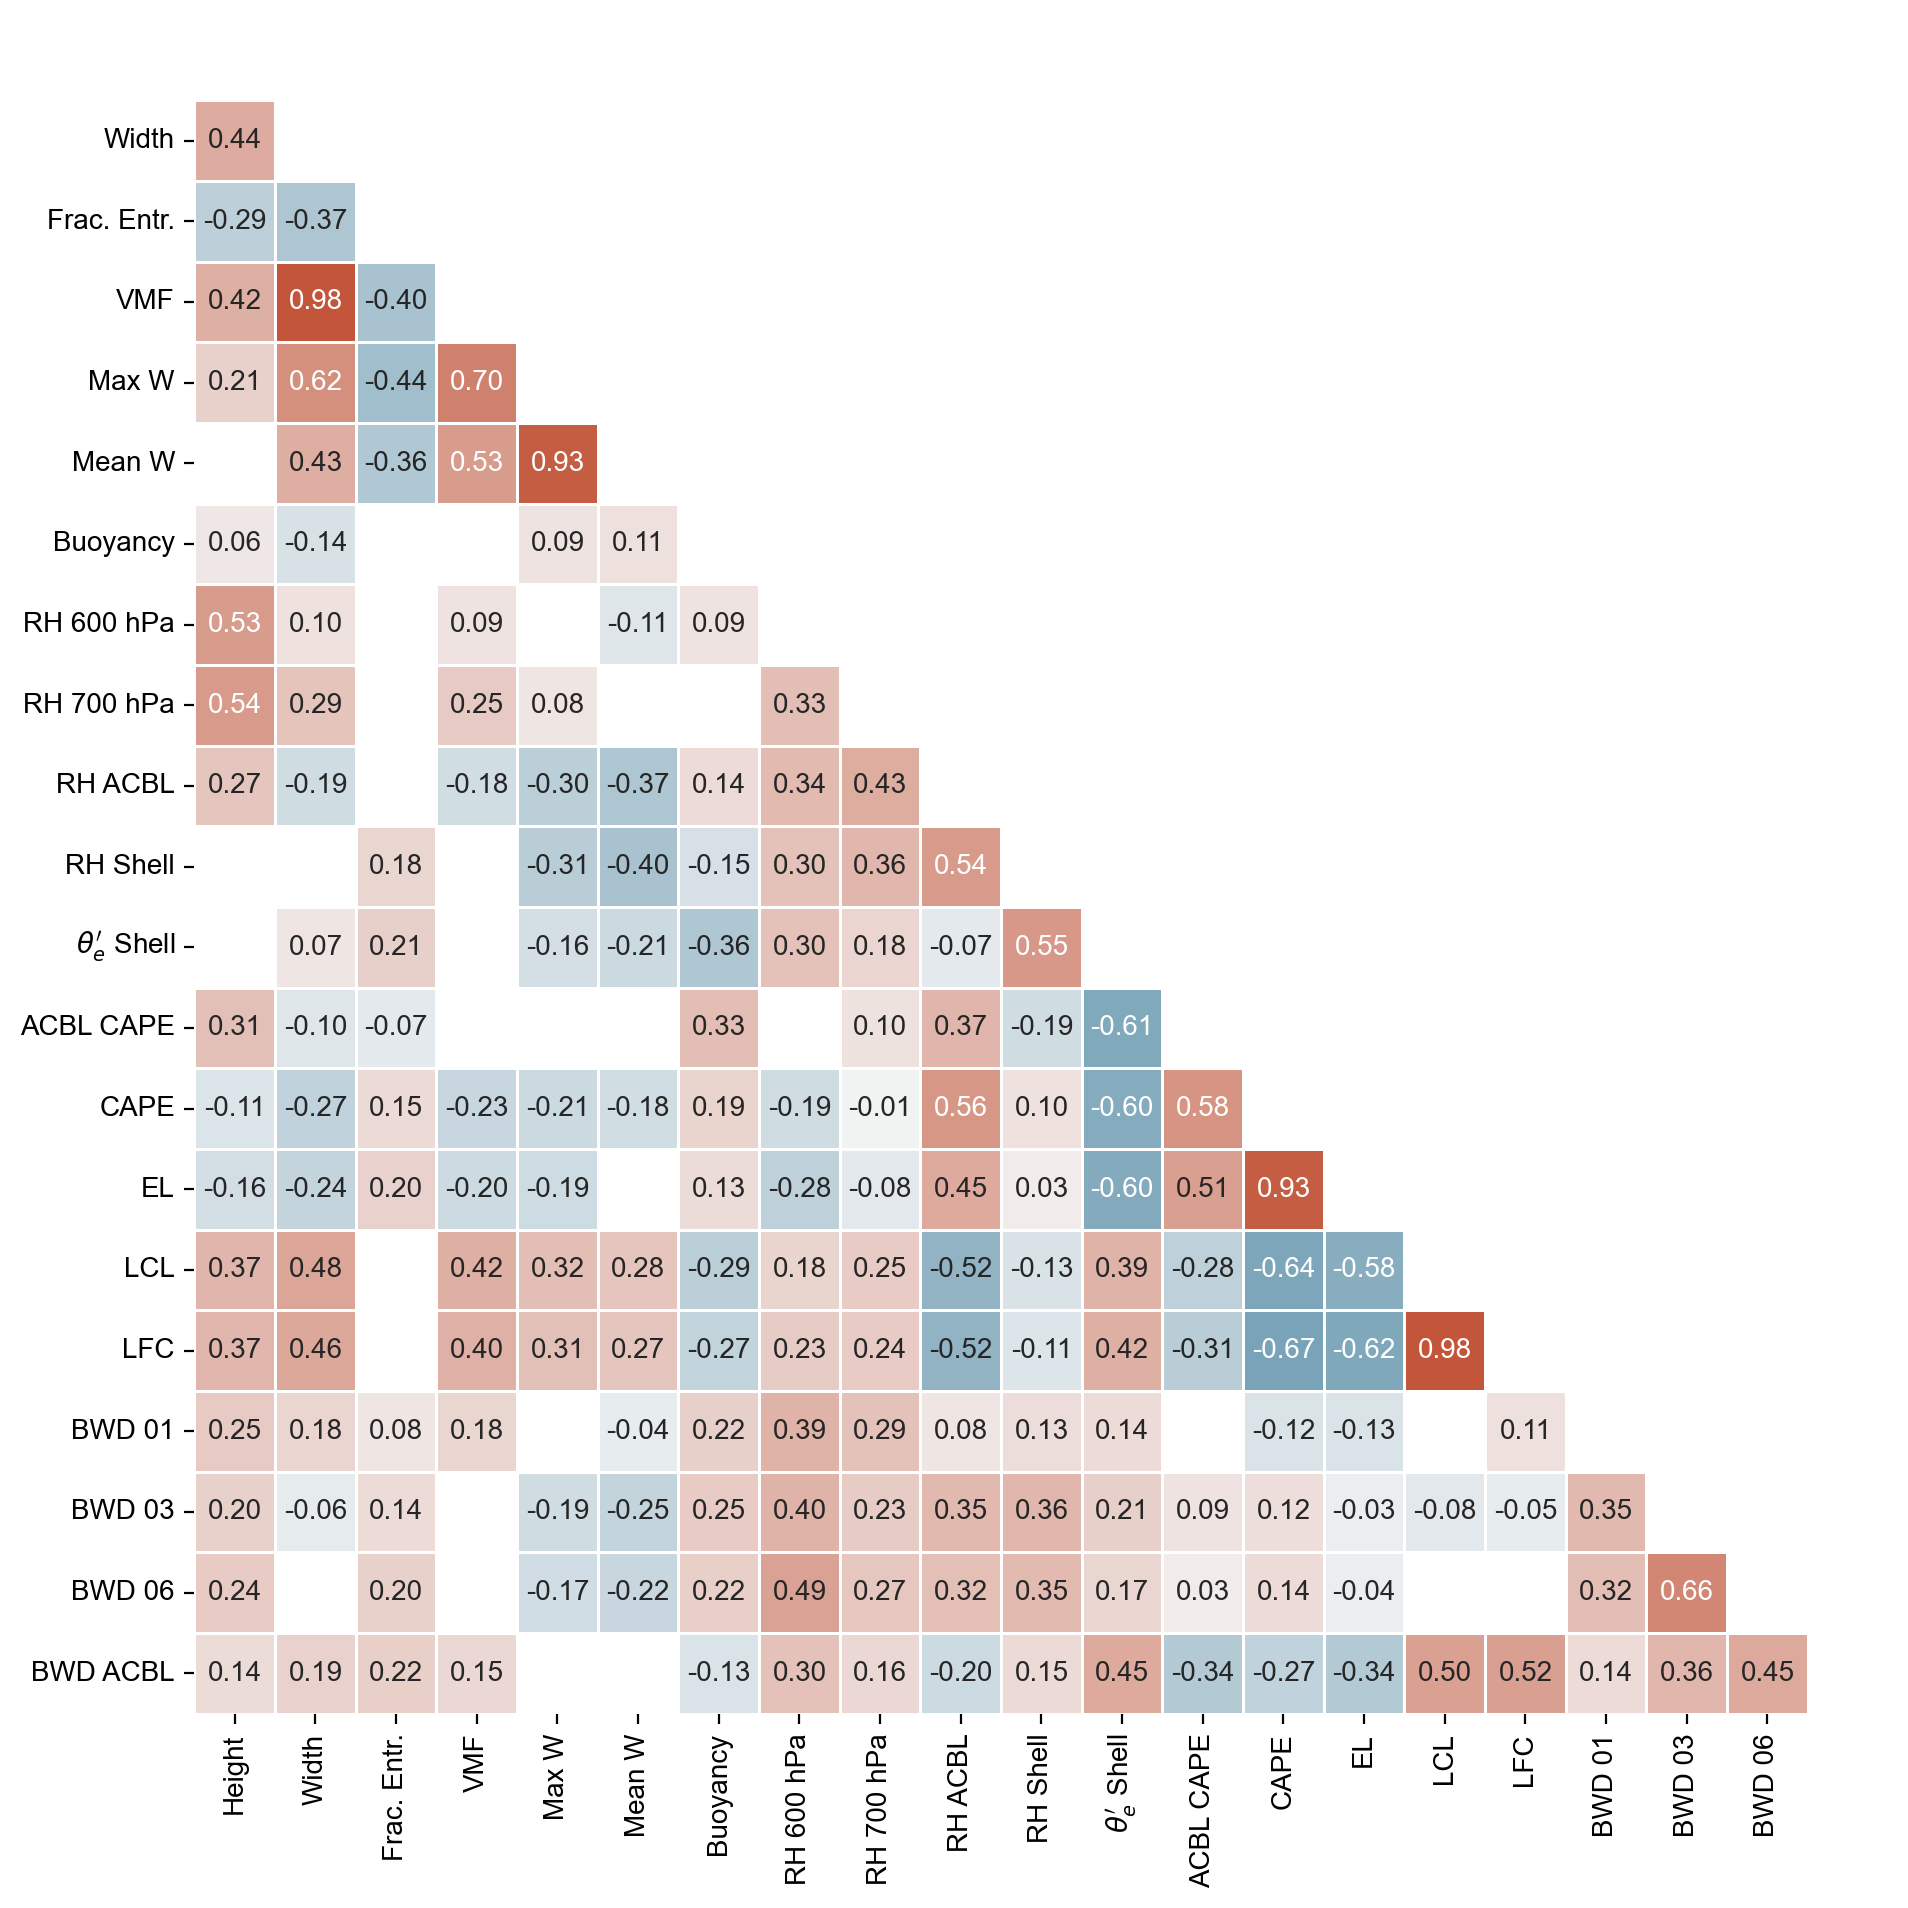

In [268]:
# Compute the correlation matrix
corr = df_updr.corr(method='spearman')
# corr = df_stab.corr()

# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
pm1 = sns.heatmap(corr, mask=combined_mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, fmt=".2f",cbar=False);


# Get the current tick labels
x_labels = ax.get_xticklabels()
y_labels = ax.get_yticklabels()

# Remove the last x and y axis labels
ax.set_xticks(ax.get_xticks()[:-1])
ax.set_yticks(ax.get_yticks()[1:])

# Apply the new tick labels with the last one removed
ax.set_xticklabels(x_labels[:-1])
ax.set_yticklabels(y_labels[1:])
# fig.subplots_adjust(right=0.8)
# plt.colorbar(pm1)

plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureS3.png',dpi=300, bbox_inches="tight")
# plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/S_Corr_stab.png',dpi=300, bbox_inches="tight")

# (9) Find all combinations of single variables

In [304]:
n_bootstraps = 100
bootstrap_coefs = np.zeros((n_bootstraps,))
bootstrap_F1 = np.zeros((n_bootstraps))
F1 = np.zeros((2,X.shape[1]))
Coef = np.zeros((2,X.shape[1]))



scaler = StandardScaler()
# logmodel = LogisticRegression(penalty='l2',solver='newton-cg',fit_intercept=True, max_iter=5000, class_weight='balanced')
logmodel = LogisticRegression(penalty='l2',solver='newton-cholesky',fit_intercept=True, max_iter=100, class_weight='balanced')
# Apparently you need to standardize when you add a penalty option.

for i in np.arange(0,X.shape[1]):
    for c in np.arange(0,n_bootstraps):
        # rus = RandomUnderSampler(random_state=c)
        # X_resampled, y_resampled = rus.fit_resample(x, y)
        # sm = SMOTE(sampling_strategy =1,random_state=c, k_neighbors=5)
        # X_resampled, y_resampled = sm.fit_resample(x, y) # SMOTE
        # X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, train_size=0.7,test_size=0.3,random_state=c,stratify=y_resampled)
        X_train, X_test, y_train, y_test = train_test_split(x,y, train_size=0.7,test_size=0.3,random_state=c,stratify=y)
        X_train_sc = scaler.fit_transform(X_train)
        X_test_sc = scaler.fit_transform(X_test)
        logmodel.fit(X_train_sc[:,i].reshape(-1,1),y_train)
        y_pred = logmodel.predict(X_test_sc[:,i].reshape(-1,1))

        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        bootstrap_F1[c] = tp/(tp+fp+fn)
        # bootstrap_F1[c] = sk.metrics.f1_score(y_test,y_pred).flatten() # For F1 score
        bootstrap_coefs[c] = logmodel.coef_[0]

    Coef[0,i] = np.percentile(bootstrap_coefs, 2.5, axis=0)
    Coef[1,i] = np.percentile(bootstrap_coefs, 97.5, axis=0)
    F1[0,i] = np.percentile(bootstrap_F1, 2.5, axis=0)
    F1[1,i] = np.percentile(bootstrap_F1, 97.5, axis=0)

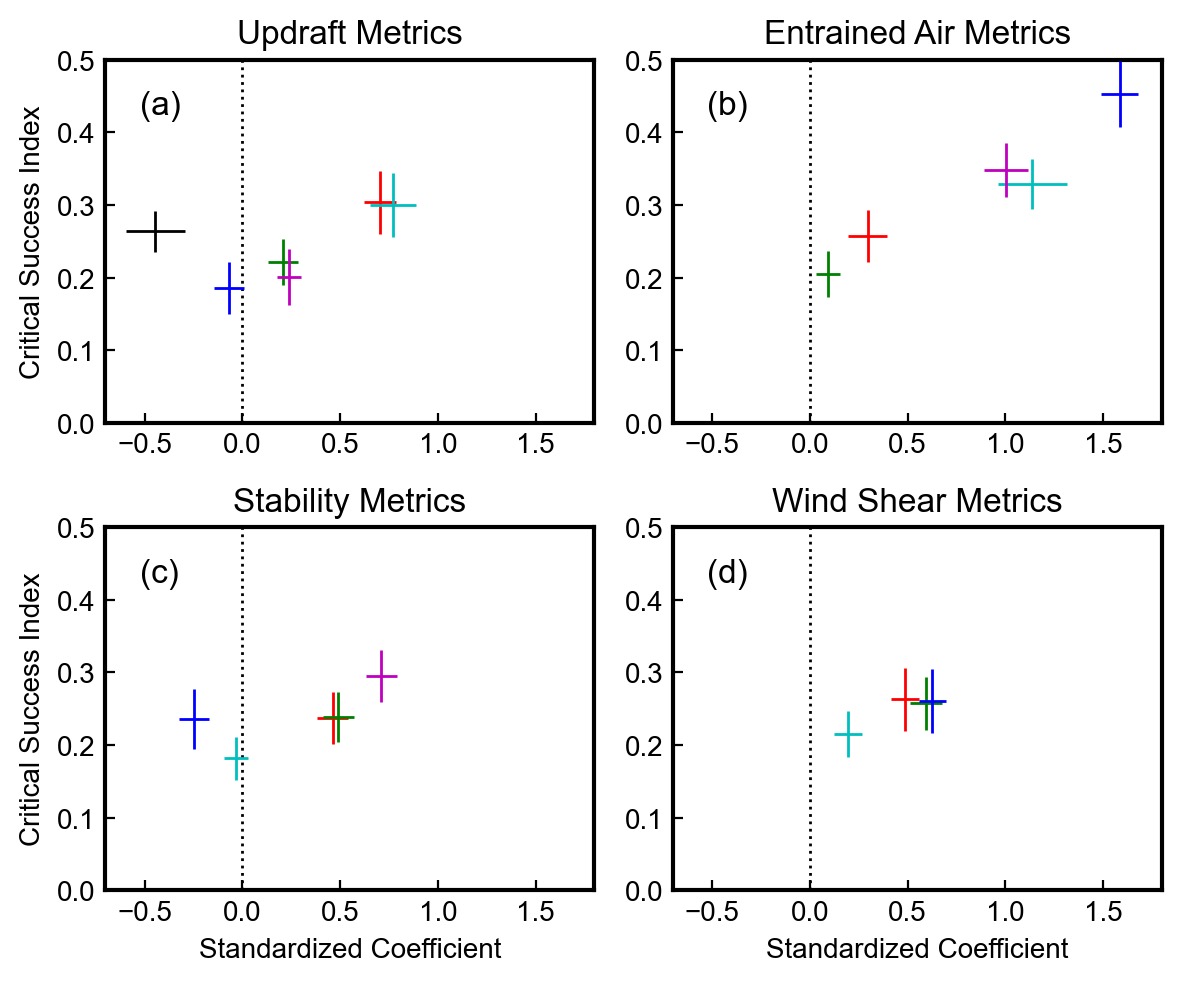

In [306]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 5))
axes = axes.ravel()

# cc = ['#ffb3ba','#ffdfba','#ffffba','#baffc9','#bae1ff']
cc = ['r','g','b','c','m','k','y']
# cc = ['b','b','b','b','b','b','b']


for i in range(0,6):
    # axes[0].annotate(feature_list[i], ( (Coef[0,i]+Coef[1,i])/2, (F1[0,i]+F1[1,i])/2 ));
    axes[0].hlines((F1[0,i]+F1[1,i])/2, Coef[0,i],Coef[1,i],linewidth=1,colors=cc[i],zorder=3,label=feature_list[i])
    axes[0].vlines((Coef[0,i]+Coef[1,i])/2, F1[0,i],F1[1,i],linewidth=1,colors=cc[i],zorder=3)

for i in range(6,11):
    # axes[1].annotate(feature_list[i], ( (Coef[0,i]+Coef[1,i])/2, (F1[0,i]+F1[1,i])/2 ));
    axes[1].hlines((F1[0,i]+F1[1,i])/2, Coef[0,i],Coef[1,i],linewidth=1,colors=cc[i-6],zorder=3,label=feature_list[i])
    axes[1].vlines((Coef[0,i]+Coef[1,i])/2, F1[0,i],F1[1,i],linewidth=1,colors=cc[i-6],zorder=3)

for i in range(11,16):
    # axes[2].annotate(feature_list[i], ( (Coef[0,i]+Coef[1,i])/2, (F1[0,i]+F1[1,i])/2 ));
    axes[2].hlines((F1[0,i]+F1[1,i])/2, Coef[0,i],Coef[1,i],linewidth=1,colors=cc[i-11],zorder=3,label=feature_list[i])
    axes[2].vlines((Coef[0,i]+Coef[1,i])/2, F1[0,i],F1[1,i],linewidth=1,colors=cc[i-11],zorder=3)

for i in range(16,20):
    # axes[3].annotate(feature_list[i], ( (Coef[0,i]+Coef[1,i])/2, (F1[0,i]+F1[1,i])/2 ));
    axes[3].hlines((F1[0,i]+F1[1,i])/2, Coef[0,i],Coef[1,i],linewidth=1,colors=cc[i-16],zorder=3,label=feature_list[i])
    axes[3].vlines((Coef[0,i]+Coef[1,i])/2, F1[0,i],F1[1,i],linewidth=1,colors=cc[i-16],zorder=3)



alp = ['(a)','(b)','(c)','(d)']
tit = ['Updraft Metrics','Entrained Air Metrics','Stability Metrics','Wind Shear Metrics']
for c in range(0,4):
    axes[c].text(0.07,0.85,alp[c],transform=axes[c].transAxes,fontsize=12)
    axes[c].set_title(tit[c],fontsize=12)
    axes[c].axvline(0,linestyle=':',color='k',linewidth=1,zorder=1)
    # axes[c].set_yticks(np.arange(0,0.51,0.1))
    axes[c].set_ylim([0.0,0.5])
    axes[c].set_xlim([-0.7,1.8])
    axes[c].tick_params(direction='in')
    # axes[c].grid('on')
    # axes[c].grid(color = 'k', linestyle = ':', linewidth = 1)
    for spine in axes[c].spines.values():
            spine.set_linewidth(1.5)
    # axes[c].legend(frameon=False,handlelength=1,loc='upper left', bbox_to_anchor=(1, 1))

# fig.subplots_adjust(right=0.75)

axes[2].set_xlabel('Standardized Coefficient');
axes[3].set_xlabel('Standardized Coefficient');
axes[0].set_ylabel('Critical Success Index');
axes[2].set_ylabel('Critical Success Index');




subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=0.3)

plt.tight_layout()
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure8.png',dpi=300)
# plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure8_reduced_samples.png',dpi=300)

In [278]:
for i in np.arange(0,len(feature_list)):
    print('{:<25} {:>10} {:>10}'.format( feature_list[i],np.round((F1[0,i]+F1[1,i])/2,4),np.round((Coef[0,i]+Coef[1,i])/2,4)))

Width                         0.3039     0.7026
$w_{max}$                     0.2212     0.2064
$w_{mean}$                    0.1862    -0.0673
VMF                           0.2996     0.7693
B                             0.2006     0.2383
$\epsilon$                    0.2635    -0.4449
Shell RH                      0.2573      0.296
Shell $\theta_e^{\prime}$     0.2049     0.0926
600 hPa RH                    0.4531     1.5843
700 hPa RH                    0.3287     1.1379
ACBL RH                       0.3482     1.0029
LCL                           0.2375     0.4612
LFC                           0.2384     0.4912
EL                            0.2358    -0.2464
CAPE                          0.1818    -0.0309
ACBL CAPE                     0.2953     0.7111
0-1 km BWD                     0.263     0.4851
0-3 km BWD                    0.2573      0.594
0-6 km BWD                    0.2606     0.6268
ACBL BWD                      0.2146     0.1954


# (10) Find all permutations of variables

In [307]:
plus_minus = [1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
ordah = np.array([0,5,8,9,15]).astype(int) # Main Subset
for i in ordah:
    print(i,plus_minus[i],feature_list[i])

0 1 Width
5 -1 $\epsilon$
8 1 600 hPa RH
9 1 700 hPa RH
15 1 ACBL CAPE


In [312]:
# Override "subsets"
subsets=[(8,0,15),(5,8,15),(5,8,0,15),(5,8,0,15,17)]
# subsets=[(9,0,15),(5,9,15),(5,9,0,15),(5,9,0,15,17)]

In [313]:
# OG Method
n_bootstraps = 100
bootstrap_F1 = np.zeros((n_bootstraps))
F1 = np.zeros((2,len(subsets)))
Nc = np.zeros((len(subsets),))
Coef = np.zeros((2,len(ordah),len(subsets)))*np.nan
StdC = np.zeros((2,len(ordah),len(subsets)))*np.nan
SgnC = np.zeros((len(ordah),len(subsets)))*np.nan

scaler = StandardScaler()
logmodel = LogisticRegression(penalty='l2',solver='newton-cholesky',fit_intercept=True, max_iter=100, class_weight='balanced')

for i in np.arange(0,len(subsets)):
    bootstrap_coefs = np.zeros((n_bootstraps,len(subsets[i])))
    for c in np.arange(0,n_bootstraps):
        # rus = RandomUnderSampler(random_state=c)
        # X_resampled, y_resampled = rus.fit_resample(x, y)
        # sm = SMOTE(sampling_strategy =1,random_state=c, k_neighbors=5)
        # X_resampled, y_resampled = sm.fit_resample(x, y) # SMOTE
        # X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, train_size=0.7,test_size=0.3,random_state=c,stratify=y_resampled)
        X_train, X_test, y_train, y_test = train_test_split(x,y, train_size=0.7,test_size=0.3,random_state=c,stratify=y)
        X_train_sc = scaler.fit_transform(X_train)
        X_test_sc = scaler.fit_transform(X_test)
        logmodel.fit(X_train_sc[:,subsets[i]],y_train);
        y_pred = logmodel.predict(X_test_sc[:,subsets[i]])

        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        bootstrap_F1[c] = tp/(tp+fp+fn)
        # bootstrap_F1[c] = sk.metrics.f1_score(y_test,y_pred).flatten()
        bootstrap_coefs[c,:] = logmodel.coef_[0]
    
    # Calculate 2.5th and 97.5th percentile to form the 95% CI
    Coef[0,:len(subsets[i]),i] = np.percentile(bootstrap_coefs, 2.5, axis=0)
    Coef[1,:len(subsets[i]),i] = np.percentile(bootstrap_coefs, 97.5, axis=0)
    
    F1[0,i] = np.percentile(bootstrap_F1, 2.5, axis=0)
    F1[1,i] = np.percentile(bootstrap_F1, 97.5, axis=0)
    Nc[i] = len(subsets[i])
    StdC[0,:len(logmodel.coef_[0]),i] = Coef[0,:len(subsets[i]),i] / sum(abs(  Coef[0,:len(subsets[i]),i]  ))*100
    StdC[1,:len(logmodel.coef_[0]),i] = Coef[1,:len(subsets[i]),i] / sum(abs(  Coef[1,:len(subsets[i]),i]  ))*100
    SgnC[:len(logmodel.coef_[0]),i] = np.sign(logmodel.coef_[0])

In [314]:
# ascending_indices = np.argsort(F1[1,icorrect]) # This is when you want to only display information about the physically correct LR models
ascending_indices = np.array([0,1,2,3])
descending_indices = ascending_indices[::-1]
# ind2 = np.where(icorrect)[0]
ind2 = np.where(np.array([ True,  True,  True, True]))[0] # Override

values = np.zeros((len(ascending_indices),5))
lower_errors = np.zeros((len(ascending_indices),5))
upper_errors = np.zeros((len(ascending_indices),5))
f1s = np.zeros((len(ascending_indices),4))

for oo in np.arange(0,len(ind2)):
    print('{:<17} {:>10} {:>10} {:>10}'.format('Var','2.5%','50%','97.5%' ))
    c = 0
    for i in subsets[ind2[descending_indices][oo]]:
        p1 = round(StdC[0,c,ind2[descending_indices][oo]],4)
        p2 = round(StdC[1,c,ind2[descending_indices][oo]],4)
        ph = round((p1+p2)/2,4)
        pp = round(ph-p2,4)
        pn = round(ph-p1,4)
        values[oo,c] = ph
        lower_errors[oo,c] = abs(pn)
        upper_errors[oo,c] = abs(pp)
        
        print('{:<17} {:>10} {:>10} {:>10} {:>10} {:>10}'.format( feature_list[i], p1, ph, p2, pn, pp))
        c = c + 1

    p1 = round(F1[0,ind2[descending_indices][oo]],4)
    p2 = round(F1[1,ind2[descending_indices][oo]],4)
    ph = round((p1+p2)/2,4)
    print('{:<17} {:>10} {:>10} {:>10}'.format(' ', p1, ph, p2))
    print(' ')

    f1s[oo,0] = p1
    f1s[oo,1] = ph
    f1s[oo,2] = p2

Var                     2.5%        50%      97.5%
$\epsilon$          -12.6818    -9.8185    -6.9552     2.8633    -2.8633
600 hPa RH           39.7423    41.4928    43.2433     1.7505    -1.7505
Width                 16.443    18.4376    20.4323     1.9946    -1.9947
ACBL CAPE            25.5748    27.3608    29.1467      1.786    -1.7859
0-3 km BWD           -5.5582    -2.8904    -0.2226     2.6678    -2.6678
                      0.5409     0.5886     0.6364
 
Var                     2.5%        50%      97.5%
$\epsilon$          -14.0674   -10.7142    -7.3611     3.3532    -3.3531
600 hPa RH           41.1977    41.6445    42.0913     0.4468    -0.4468
Width                17.8693    19.4941    21.1189     1.6248    -1.6248
ACBL CAPE            26.8656    28.1472    29.4288     1.2816    -1.2816
                      0.5468     0.5893     0.6318
 
Var                     2.5%        50%      97.5%
$\epsilon$           -27.209   -21.6212   -16.0334     5.5878    -5.5878
600 hPa RH 

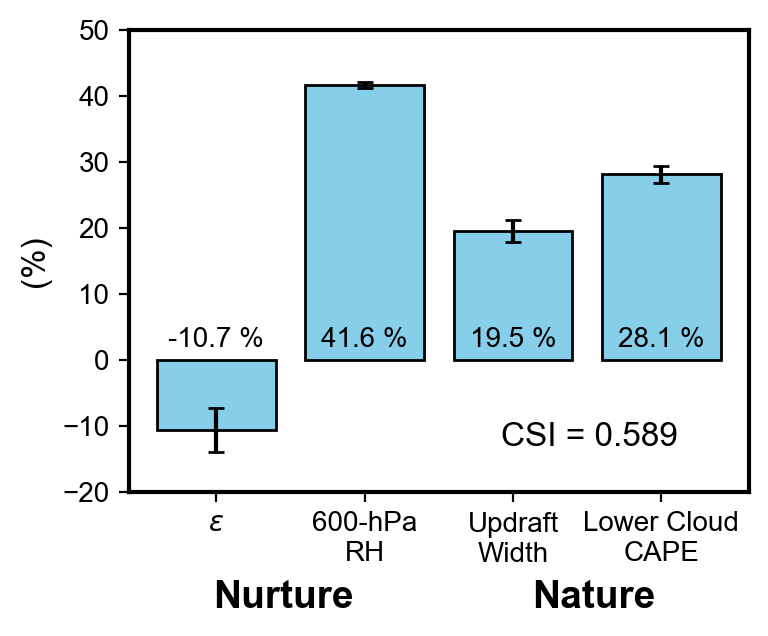

In [315]:
# Sample data
runn = 1
categories = ['$\epsilon$', '600-hPa\nRH','Updraft\nWidth',  'Lower Cloud\nCAPE']


format_func = np.vectorize(lambda x: f'{x:.3g}')
formatted_val = format_func(values)

plt.figure(figsize=(4, 3))
asymmetric_error = [lower_errors[runn,:-1], upper_errors[runn,:-1]]
bars = plt.bar(categories, formatted_val[runn,:-1].astype(float), yerr=asymmetric_error, capsize=3, color='skyblue', edgecolor='black')

# asymmetric_error = [lower_errors[runn,:-1], upper_errors[runn,:-1]]

# Create bar plot
# plt.figure(figsize=(4, 3))
# bars = plt.bar(categories, [20.6,-6.58,42.7,30.1], yerr=asymmetric_error, capsize=3, color='skyblue', edgecolor='black')
# bars = plt.bar(categories, [19.2,-9.64,42.2,28.9], yerr=asymmetric_error, capsize=3, color='skyblue', edgecolor='black')
# bars = plt.bar(categories, values[runn,:-1], yerr=asymmetric_error, capsize=3, color='skyblue', edgecolor='black')
# plt.title('Coefficients')
plt.ylabel('(%)',fontsize=12);
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
# plt.ylim([-25, 55])
plt.ylim([-20, 50])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 1, f'{yval}'+' %', ha='center', va='bottom')

axs = plt.gca()
for spine in axs.spines.values():
    spine.set_linewidth(1.5)

# format_func = np.vectorize(lambda x: f'{x:.3g}')
# formatted_val = 
# plt.text(0.6,0.1,'CSI = '+str(f1s[runn,1]),transform=axs.transAxes,fontsize=12)
plt.text(0.6,0.1,'CSI = '+str(format_func(f1s[runn,1])),transform=axs.transAxes,fontsize=12)
plt.text(.25,-.23,'Nurture',transform=axs.transAxes,fontsize=14,ha='center',va='center',weight="bold")
plt.text(.75,-.23,'Nature',transform=axs.transAxes,fontsize=14,ha='center',va='center',weight="bold")


# plt.text(0.4,0.05,'F1 = '+str(f1s[runn,:]),transform=axs.transAxes,fontsize=12)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure9.png',dpi=300, bbox_inches="tight")

In [105]:
asymmetric_error

[array([3.3532, 0.4468, 1.6248, 1.2816]),
 array([3.3531, 0.4468, 1.6248, 1.2816])]

# (11) Train on one case test on others

In [350]:
fnal = np.array([5,8,0,15]).astype(int)
for i in fnal:
    print(feature_list[i])

med Width
med CAPE
mean Width
min Width


In [351]:
combo = [(0,1),(0,2),(0,3),(1,0),(1,2),(1,3),(2,0),(2,1),(2,3),(3,0),(3,1),(3,2)]

In [352]:
n_bootstraps = 100
bootstrap_F1 = np.zeros((n_bootstraps))
F1 = np.zeros((len(combo),n_bootstraps))
Nc = np.zeros((len(combo),))
Coef = np.zeros((len(fnal),len(combo),n_bootstraps))*np.nan
# StdC = np.zeros((2,len(fnal),len(combo)))*np.nan
# SgnC = np.zeros((len(fnal),len(combo)))*np.nan
cotest = np.zeros((len(fnal),n_bootstraps))*np.nan

scaler = StandardScaler()
logmodel = LogisticRegression(penalty='l2',solver='newton-cholesky',fit_intercept=True, max_iter=100, class_weight='balanced')

for i in np.arange(0,len(combo)):
# i = 0
    bootstrap_coefs = np.zeros((n_bootstraps,len(fnal)))
    date1 = Ct == combo[i][0]
    date2 = Ct == combo[i][1]
    for c in np.arange(0,n_bootstraps):
        # rus = RandomUnderSampler(random_state=c)
        # X_resampled, y_resampled = rus.fit_resample(np.concatenate((x,Ct[:,np.newaxis]),axis=1), y)
        # date1 = X_resampled[:,-1] == combo[i][0]
        # date2 = X_resampled[:,-1] == combo[i][1]
        # X_train, _, y_train, _ = train_test_split(X_resampled[date1,:],y_resampled[date1], train_size=0.7,test_size=0.3,random_state=c,stratify=y_resampled[date1])
        # _, X_test, _, y_test = train_test_split(X_resampled[date2,:],y_resampled[date2], train_size=0.7,test_size=0.3,random_state=c,stratify=y_resampled[date2])
        
        X_train, _, y_train, _ = train_test_split(x[date1,:],y[date1], train_size=0.7,test_size=0.3,random_state=c,stratify=y[date1])
        X_train_sc = scaler.fit_transform(X_train)
        _, X_test, _, y_test = train_test_split(x[date2,:],y[date2], train_size=0.7,test_size=0.3,random_state=c,stratify=y[date2])
        X_test_sc = scaler.fit_transform(X_test)
        
        logmodel.fit(X_train_sc[:,fnal],y_train);
        y_pred = logmodel.predict(X_test_sc[:,fnal])

        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        bootstrap_F1[c] = tp/(tp+fp+fn)
        # bootstrap_F1[c] = sk.metrics.f1_score(y_test,y_pred).flatten()
        # bootstrap_coefs[c,:] = logmodel.coef_[0]
        bootstrap_coefs[c,:] = logmodel.coef_[0]/np.sum(abs(logmodel.coef_[0]))*100
    
    # Calculate 2.5th and 97.5th percentile to form the 95% CI
    Coef[:len(fnal),i,:] = bootstrap_coefs[:,:].T
    # cotest[i,:] = bootstrap_coefs[:,:].T
    
    F1[i,:] = bootstrap_F1
    # F1[1,i] = np.percentile(bootstrap_F1, 97.5, axis=0)
    Nc[i] = len(fnal)
    # StdC[0,:len(logmodel.coef_[0]),i] = Coef[0,:len(fnal),i] / sum(abs(  Coef[0,:len(fnal),i]  ))*100
    # StdC[1,:len(logmodel.coef_[0]),i] = Coef[1,:len(fnal),i] / sum(abs(  Coef[1,:len(fnal),i]  ))*100
    # SgnC[:len(logmodel.coef_[0]),i] = np.sign(logmodel.coef_[0])

In [353]:
d1 = xr.DataArray(np.squeeze(Coef[:,::3,:])
                  ,dims=['Predictors','Dates','Bootstraps']
                  ,coords=[[r'$\epsilon$','600-hPa RH','Updraft\nWidth','Lower\nCloud CAPE'],['29 Nov','4 Dec','23 Jan','29 Jan'],np.arange(0,100)]).to_dataframe(name='Standardized Coefficients')

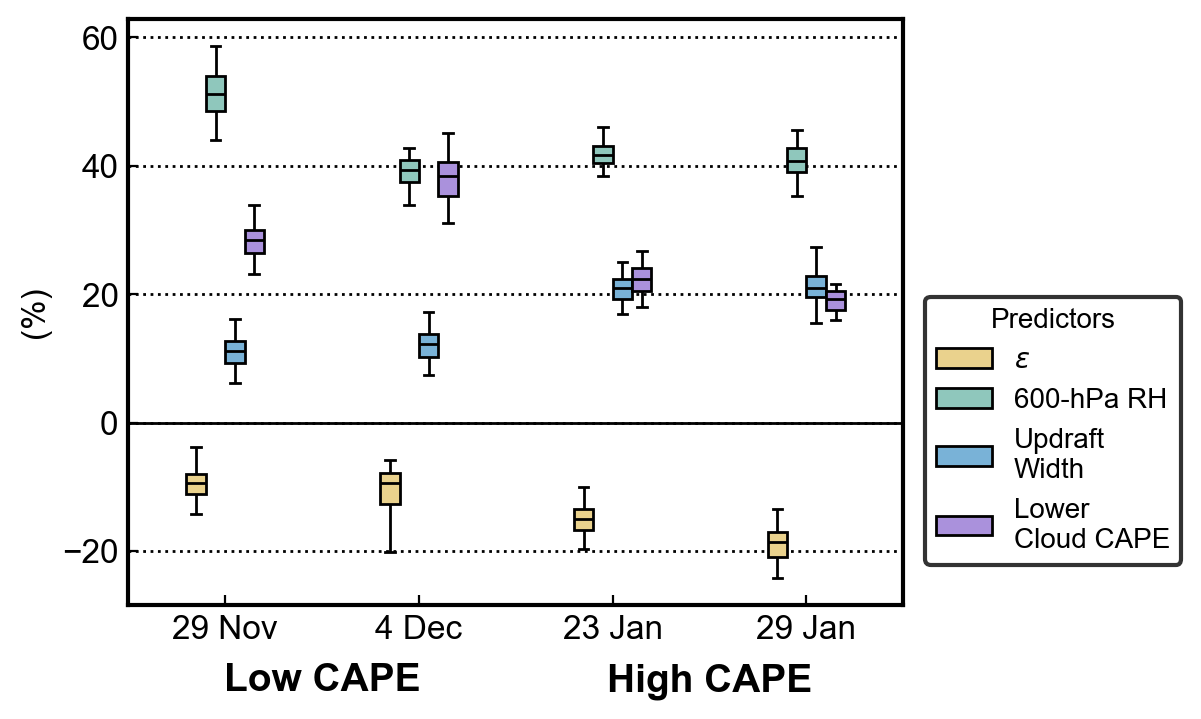

In [355]:
plt.figure(figsize=(5, 3.8))

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}
# pal = ['#FAEDCB','#C9E4DE','#C6DEF1','#DBCDF0']
pal = ['#F9DA7E', '#86D0C2', '#69B5E7', '#A685E8']
g = sns.boxplot(x="Dates", y="Standardized Coefficients",
            hue="Predictors", palette=pal,
            data=d1,whis=(2.5, 97.5),showfliers=False,width=.4,linewidth=1,**PROPS)



# plt.setp(g.lines, color='k')
# plt.setp(ax.artists, edgecolor = 'k')

plt.axhline(0,linewidth=1,color='k',linestyle='-');
# legend = plt.legend()

sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, .55), title='Predictors')
legend = g.legend_
legend.get_frame().set_edgecolor('black')  # Set the border color
legend.get_frame().set_linewidth(1.5) 

axs = plt.gca()#

axs.grid(color = 'k', linestyle = ':', linewidth = 1, axis='y')

axs.set_ylabel('(%)',fontsize=12)
axs.set_xlabel('',fontsize=12)
axs.tick_params(labelsize=12,direction='in')
for spine in axs.spines.values():
        spine.set_linewidth(1.5)


plt.text(.25,-.13,'Low CAPE',transform=axs.transAxes,fontsize=14,ha='center',va='center',weight="bold")
plt.text(.75,-.13,'High CAPE',transform=axs.transAxes,fontsize=14,ha='center',va='center',weight="bold")
# sns.despine(offset=0, trim=True)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure11.png',dpi=300, bbox_inches="tight")

# Combined Plots

In [516]:
fnal = np.array([0,5,8,15]).astype(int)
for i in fnal:
    print(feature_list[i])

Width
$\epsilon$
600 hPa RH
ACBL CAPE


In [517]:
n_bootstraps = 100
bootstrap_coefs = np.zeros((n_bootstraps,4))
bootstrap_inters = np.zeros((n_bootstraps,))
scaler = StandardScaler()
logmodel = LogisticRegression(penalty='l2',solver='newton-cholesky',fit_intercept=True, max_iter=100, class_weight='balanced')

for c in np.arange(0,n_bootstraps):
    X_train, X_test, y_train, y_test = train_test_split(x,y, train_size=0.7,test_size=0.3,random_state=c,stratify=y)
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.fit_transform(X_test)
    logmodel.fit(X_train_sc[:,fnal],y_train);
    y_pred = logmodel.predict(X_test_sc[:,fnal])

    bootstrap_coefs[c,:] = logmodel.coef_[0]
    bootstrap_inters[c] = logmodel.intercept_

coefs = np.mean(bootstrap_coefs,axis=0)
inter = np.mean(bootstrap_inters)

In [645]:
# scaler1 = StandardScaler()
# scaler1.fit(x[:,fnal[0]].reshape(-1,1)) 
# v1 = np.arange(.5,2.0,.1)
# s1 = scaler1.transform(  v1.reshape(-1, 1)  ) # Then use the scaler to transform your x axis

# scaler2 = StandardScaler()
# scaler2.fit(x[:,fnal[1]].reshape(-1,1))
# v2 = np.arange(.4,2.2,.1)
# s2 = scaler2.transform(  v2.reshape(-1, 1)  ) 

# scaler3 = StandardScaler()
# scaler3.fit(x[:,fnal[2]].reshape(-1,1))
# v3 = np.arange(10,80,10)
# s3 = scaler3.transform(  v3.reshape(-1, 1)  ) 

# scaler4 = StandardScaler()
# scaler4.fit(x[:,fnal[3]].reshape(-1,1))
# v4 = np.arange(10,120,10)
# s4 = scaler4.transform(  v4.reshape(-1, 1)  ) 

# lim1 = np.percentile(x[:,fnal[:]],1,axis=0)
# lim2 = np.percentile(x[:,fnal[:]],75,axis=0)
# # med = np.percentile(x[:,fnal[:]],50,axis=0)
# med = np.mean(x[:,fnal[:]],axis=0)
# stv = np.std(x[:,fnal[:]],axis=0)

# print('width E, RH, CAPE')
# print('mean:', med)
# print('STD: ',stv)

# print(np.percentile(x[:,fnal[0]],1),np.percentile(x[:,fnal[0]],50),np.percentile(x[:,fnal[0]],99),np.std(x[:,fnal[0]]),'width')
# print(np.percentile(x[:,fnal[1]],1),np.percentile(x[:,fnal[1]],50),np.percentile(x[:,fnal[1]],99),np.std(x[:,fnal[1]]),'ent')
# print(np.percentile(x[:,fnal[2]],1),np.percentile(x[:,fnal[2]],50),np.percentile(x[:,fnal[2]],99),np.std(x[:,fnal[2]]),'RH')
# print(np.percentile(x[:,fnal[3]],1),np.percentile(x[:,fnal[3]],50),np.percentile(x[:,fnal[3]],99),np.std(x[:,fnal[3]]),'CAPE')
# len(v1),len(v2),len(v3),len(v4)

width E, RH, CAPE
mean: [ 1.08310077  0.82282137 34.7819373  64.15517071]
STD:  [ 0.31438398  0.38672942 19.53021111 22.35909402]
0.5341607439517975 1.0456474423408508 1.952675521373749 0.3143839826848702 width
0.3642991828918457 0.7231546640396118 2.1157706665992744 0.3867294242324732 ent
8.878037527494193 29.162596674990063 79.81820255768201 19.530211111342688 RH
9.028853778897608 65.33993808480052 116.6609684085846 22.359094019225974 CAPE


(15, 18, 7, 11)

In [727]:
lim1 = np.percentile(x[:,fnal[:]],2.5,axis=0)
lim2 = np.percentile(x[:,fnal[:]],97.5,axis=0)
# med = np.percentile(x[:,fnal[:]],50,axis=0)
med = np.mean(x[:,fnal[:]],axis=0)
stv = np.std(x[:,fnal[:]],axis=0)


scaler1 = StandardScaler()
scaler1.fit(x[:,fnal[0]].reshape(-1,1)) 
v1 = np.linspace(lim1[0],lim2[0],10)
b1 = np.linspace(lim1[0]-np.diff(v1)[0],lim2[0]+np.diff(v1)[0],11)
s1 = scaler1.transform(  v1.reshape(-1, 1)  ) # Then use the scaler to transform your x axis

scaler2 = StandardScaler()
scaler2.fit(x[:,fnal[1]].reshape(-1,1))
v2 = np.linspace(lim1[1],lim2[1],10)
b2 = np.linspace(lim1[1]-np.diff(v2)[0],lim2[1]+np.diff(v2)[0],11)
s2 = scaler2.transform(  v2.reshape(-1, 1)  ) 

scaler3 = StandardScaler()
scaler3.fit(x[:,fnal[2]].reshape(-1,1))
v3 = np.linspace(lim1[2],lim2[2],10)
b3 = np.linspace(lim1[2]-np.diff(v3)[0],lim2[2]+np.diff(v3)[0],11)
s3 = scaler3.transform(  v3.reshape(-1, 1)  ) 

scaler4 = StandardScaler()
scaler4.fit(x[:,fnal[3]].reshape(-1,1))
v4 = np.linspace(lim1[3],lim2[3],10)
b4 = np.linspace(lim1[3]-np.diff(v4)[0],lim2[3]+np.diff(v4)[0],11)
s4 = scaler4.transform(  v4.reshape(-1, 1)  ) 

print('width E, RH, CAPE')
print('mean:', med)
print('STD: ',stv)

print(np.percentile(x[:,fnal[0]],1),np.percentile(x[:,fnal[0]],50),np.percentile(x[:,fnal[0]],99),np.std(x[:,fnal[0]]),'width')
print(np.percentile(x[:,fnal[1]],1),np.percentile(x[:,fnal[1]],50),np.percentile(x[:,fnal[1]],99),np.std(x[:,fnal[1]]),'ent')
print(np.percentile(x[:,fnal[2]],1),np.percentile(x[:,fnal[2]],50),np.percentile(x[:,fnal[2]],99),np.std(x[:,fnal[2]]),'RH')
print(np.percentile(x[:,fnal[3]],1),np.percentile(x[:,fnal[3]],50),np.percentile(x[:,fnal[3]],99),np.std(x[:,fnal[3]]),'CAPE')
len(v1),len(v2),len(v3),len(v4)

width E, RH, CAPE
mean: [ 1.08310077  0.82282137 34.7819373  64.15517071]
STD:  [ 0.31438398  0.38672942 19.53021111 22.35909402]
0.5341607439517975 1.0456474423408508 1.952675521373749 0.3143839826848702 width
0.3642991828918457 0.7231546640396118 2.1157706665992744 0.3867294242324732 ent
8.878037527494193 29.162596674990063 79.81820255768201 19.530211111342688 RH
9.028853778897608 65.33993808480052 116.6609684085846 22.359094019225974 CAPE


(10, 10, 10, 10)

In [663]:
lim1

array([ 0.58650513,  0.39963036,  9.6296085 , 19.00807425])

In [664]:
lim2

array([  1.77715461,   1.64700486,  76.00137341, 107.66925699])

array([[1.32608292]])

In [728]:
vx = {}
vx[(0)] = v1
vx[(1)] = v2
vx[(2)] = v3
vx[(3)] = v4
sx = {}
sx[(0)] = s1
sx[(1)] = s2
sx[(2)] = s3
sx[(3)] = s4
bx = {}
bx[(0)] = b1
bx[(1)] = b2
bx[(2)] = b3
bx[(3)] = b4
iid = {}
iid[(0)] = [0, 1]
iid[(1)] = [0, 3]
iid[(2)] = [0, 2]
iid[(3)] = [3, 2]
iid[(4)] = [1, 3]
iid[(5)] = [1, 2]

In [335]:
# for i in np.arange(0,4):
#     itall = ch[good_indices]>=5.5
#     ishort = ch[good_indices]<5.5
#     med_short = np.percentile(x[ishort,:],50,axis=0)[fnal]
#     med_tall = np.percentile(x[itall,:],50,axis=0)[fnal]

# med_short[0] = scaler1.transform(med_short[0].reshape(-1, 1))
# med_short[1] = scaler2.transform(med_short[1].reshape(-1, 1))
# med_short[2] = scaler3.transform(med_short[2].reshape(-1, 1))
# med_short[3] = scaler4.transform(med_short[3].reshape(-1, 1))
# med_tall[0] = scaler1.transform(med_tall[0].reshape(-1, 1))
# med_tall[1] = scaler2.transform(med_tall[1].reshape(-1, 1))
# med_tall[2] = scaler3.transform(med_tall[2].reshape(-1, 1))
# med_tall[3] = scaler4.transform(med_tall[3].reshape(-1, 1))


In [519]:
ts1 = scaler1.transform(np.percentile(x[:,fnal[0]],50).reshape(-1, 1))
ts2 = scaler2.transform(np.percentile(x[:,fnal[1]],50).reshape(-1, 1))
ts3 = scaler3.transform(np.percentile(x[:,fnal[2]],50).reshape(-1, 1))
ts4 = scaler4.transform(np.percentile(x[:,fnal[3]],50).reshape(-1, 1))

In [520]:
P1=0.25;P2=0.75
ans2 = scaler4.inverse_transform((-1*np.log(1/P2-1) - inter - coefs[0]*ts1 - coefs[1]*ts2 - coefs[2]*ts3 )/coefs[3])[0][0]
ans1 = scaler4.inverse_transform((-1*np.log(1/P1-1) - inter - coefs[0]*ts1 - coefs[1]*ts2 - coefs[2]*ts3 )/coefs[3])[0][0]
print(ans2-ans1,'CAPE')
ans2 = scaler3.inverse_transform((-1*np.log(1/P2-1) - inter - coefs[0]*ts1 - coefs[1]*ts2 - coefs[3]*ts4 )/coefs[2])[0][0]
ans1 = scaler3.inverse_transform((-1*np.log(1/P1-1) - inter - coefs[0]*ts1 - coefs[1]*ts2 - coefs[3]*ts4 )/coefs[2])[0][0]
print(ans2-ans1,'RH')
ans2 = scaler2.inverse_transform((-1*np.log(1/P2-1) - inter - coefs[0]*ts1 - coefs[2]*ts3 - coefs[3]*ts4 )/coefs[1])[0][0]
ans1 = scaler2.inverse_transform((-1*np.log(1/P1-1) - inter - coefs[0]*ts1 - coefs[2]*ts3 - coefs[3]*ts4 )/coefs[1])[0][0]
print(ans2-ans1,'ent')
ans2 = scaler1.inverse_transform((-1*np.log(1/P2-1) - inter - coefs[1]*ts2 - coefs[2]*ts3 - coefs[3]*ts4 )/coefs[0])[0][0]
ans1 = scaler1.inverse_transform((-1*np.log(1/P1-1) - inter - coefs[1]*ts2 - coefs[2]*ts3 - coefs[3]*ts4 )/coefs[0])[0][0]
print(ans2-ans1,'width')

33.782292833858776 CAPE
19.833308679176973 RH
-1.6670661417575379 ent
0.6836625131682403 width


In [521]:
V1=scaler4.transform(np.array([med[3]]).reshape(-1, 1)); V2=scaler4.transform(np.array([med[3]+stv[3]]).reshape(-1, 1))
ans2 = 1/( 1 + np.exp(-1*inter - coefs[0]*ts1 - coefs[1]*ts2 - coefs[2]*ts3  - coefs[3]*V2  ) )[0][0]
ans1 = 1/( 1 + np.exp(-1*inter - coefs[0]*ts1 - coefs[1]*ts2 - coefs[2]*ts3  - coefs[3]*V1  ) )[0][0]
print((ans2-ans1)*100,'CAPE')
V1=scaler3.transform(np.array([med[2]]).reshape(-1, 1)); V2=scaler3.transform(np.array([med[2]+stv[2]]).reshape(-1, 1))
ans2 = 1/( 1 + np.exp(-1*inter - coefs[0]*ts1 - coefs[1]*ts2 - coefs[2]*V2  - coefs[3]*ts4  ) )[0][0]
ans1 = 1/( 1 + np.exp(-1*inter - coefs[0]*ts1 - coefs[1]*ts2 - coefs[2]*V1  - coefs[3]*ts4  ) )[0][0]
print((ans2-ans1)*100,'RH')
V1=scaler2.transform(np.array([med[1]]).reshape(-1, 1)); V2=scaler2.transform(np.array([med[1]+stv[1]]).reshape(-1, 1))
ans2 = 1/( 1 + np.exp(-1*inter - coefs[0]*ts1 - coefs[1]*V2 - coefs[2]*ts3  - coefs[3]*ts4  ) )[0][0]
ans1 = 1/( 1 + np.exp(-1*inter - coefs[0]*ts1 - coefs[1]*V1 - coefs[2]*ts3  - coefs[3]*ts4 ) )[0][0]
print((ans2-ans1)*100,'ent')
V1=scaler1.transform(np.array([med[0]]).reshape(-1, 1)); V2=scaler1.transform(np.array([med[0]+stv[0]]).reshape(-1, 1))
ans2 = 1/( 1 + np.exp(-1*inter - coefs[0]*V2 - coefs[1]*ts2 - coefs[2]*ts3  - coefs[3]*ts4  ) )[0][0]
ans1 = 1/( 1 + np.exp(-1*inter - coefs[0]*V1 - coefs[1]*ts2 - coefs[2]*ts3  - coefs[3]*ts4 ) )[0][0]
print((ans2-ans1)*100,'width')

25.71335112415531 CAPE
49.17574142562564 RH
-4.476140994284885 ent
17.71172209739277 width


In [421]:
np.arange(0,len(s4))

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [729]:
CAPEWidth = np.zeros((len(s1),len(s4)))
for i in np.arange(0,len(s1)):
    for l in np.arange(0,len(s4)):
        CAPEWidth[i,l] = 1/( 1 + np.exp(-( inter \
                                       + coefs[0] * s1[i] \
                                       + coefs[1] * scaler2.transform(  med[1].reshape(-1,1)  ) \
                                       + coefs[2] * scaler3.transform(  med[2].reshape(-1,1)  ) \
                                       + coefs[3] * s4[l] )))

EntWidth = np.zeros((len(s1),len(s2)))
for i in np.arange(0,len(s1)):
    for j in np.arange(0,len(s2)):
        EntWidth[i,j] = 1/( 1 + np.exp(-( inter \
                                       + coefs[0] * s1[i] \
                                       + coefs[1] * s2[j] \
                                       + coefs[2] * scaler3.transform(  med[2].reshape(-1,1)  ) \
                                       + coefs[3] * scaler4.transform(  med[3].reshape(-1,1)  ) )))

RHEnt = np.zeros((len(s2),len(s3)))
for j in np.arange(0,len(s2)):
    for k in np.arange(0,len(s3)):
        RHEnt[j,k] = 1/( 1 + np.exp(-( inter \
                                       + coefs[0] * scaler1.transform(  med[0].reshape(-1,1)  ) \
                                       + coefs[1] * s2[j] \
                                       + coefs[2] * s3[k] \
                                       + coefs[3] * scaler4.transform(  med[3].reshape(-1,1)  ) )))

EntCAPE = np.zeros((len(s2),len(s4)))
for j in np.arange(0,len(s2)):
    for l in np.arange(0,len(s4)):
        EntCAPE[j,l] = 1/( 1 + np.exp(-( inter \
                                       + coefs[0] * scaler1.transform(  med[0].reshape(-1,1)  ) \
                                       + coefs[1] * s2[j] \
                                       + coefs[2] * scaler3.transform(  med[2].reshape(-1,1)  ) \
                                       + coefs[3] * s4[l]  )))

RHWidth = np.zeros((len(s1),len(s3)))
for i in np.arange(0,len(s1)):
    for k in np.arange(0,len(s3)):
        RHWidth[i,k] = 1/( 1 + np.exp(-( inter \
                                       + coefs[0] * s1[i] \
                                       + coefs[1] * scaler2.transform(  med[1].reshape(-1,1)  ) \
                                       + coefs[2] * s3[k] \
                                       + coefs[3] * scaler4.transform(  med[3].reshape(-1,1)  ) )))

RHCAPE = np.zeros((len(s4),len(s3)))
for k in np.arange(0,len(s4)):
    for l in np.arange(0,len(s3)):
        RHCAPE[k,l] = 1/( 1 + np.exp(-( inter \
                                       + coefs[0] * scaler1.transform(  med[0].reshape(-1,1)  ) \
                                       + coefs[1] * scaler2.transform(  med[1].reshape(-1,1)  ) \
                                       + coefs[2] * s3[l] \
                                       + coefs[3] * s4[k] )))

In [723]:
def Prob_of_Deep(v1,v2,v3,v4):
    P = 1/( 1 + np.exp( -1*inter \
                   -coefs[0] * v1\
                   -coefs[1] * v2\
                   -coefs[2] * v3\
                   -coefs[3] * v4\
                  ) )
    return P

# 100% Theory

In [ ]:
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))
# axs = axes.ravel()

# lev = [3,20,40,60]
# # cmap = mcolors.ListedColormap(['k'])
# thre = 0
# th2 = 10

# # norm = np.arange(0,1.1,0.2)
# # norm = matplotlib.colors.BoundaryNorm(np.arange(0,1.1,0.2),cmap='turbo')

# boundaries = np.arange(0, 1.1, 0.2)  # from 0 to 1 with 0.2 increments
# cmap = plt.get_cmap('plasma')
# norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)



# c = 0
# xl = np.copy(s1).reshape(1,-1)[0]
# yl = np.copy(s2).reshape(1,-1)[0]
# pm2 = axs[c].pcolormesh(xl, yl, EntWidth.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
# axs[c].set_xticks(xl[::2])
# axs[c].set_xticklabels( np.char.mod('%.1f', v1[::2]) )
# axs[c].set_yticks(yl[::2])
# axs[c].set_yticklabels( np.char.mod('%.1f', v2[::2])  )
# axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
# axs[c].set_ylabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
# axs[c].set_xlim([None, .85])
# axs[c].set_ylim([None, .58])

# c = 1
# xl = np.copy(s1).reshape(1,-1)[0]
# yl = np.copy(s4).reshape(1,-1)[0]
# pm2 = axs[c].pcolormesh(xl, yl, CAPEWidth.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
# axs[c].set_xticks(xl[::2])
# axs[c].set_xticklabels( np.char.mod('%.1f', v1[::2]) )
# axs[c].set_yticks(yl[::2])
# axs[c].set_yticklabels( np.char.mod('%.0f', v4[::2])  )
# axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
# axs[c].set_ylabel('Lwr Cld CAPE $(J\cdot kg^{-1})$',fontsize = 10);
# axs[c].set_xlim([None, .85])
# axs[c].set_ylim([-1.5, 2.05])

# c = 2
# xl = np.copy(s1).reshape(1,-1)[0]
# yl = np.copy(s3).reshape(1,-1)[0]
# pm2 = axs[c].pcolormesh(xl, yl, RHWidth.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
# axs[c].set_xticks(xl[::2])
# axs[c].set_xticklabels( np.char.mod('%.1f', v1[::2]) )
# axs[c].set_yticks(yl[::2])
# axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
# axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
# axs[c].set_ylabel(r'600-hPa RH ($\%$)',fontsize = 10);
# axs[c].set_xlim([None, .85])
# axs[c].set_ylim([None, None])

# c = 3
# xl = np.copy(s4).reshape(1,-1)[0]
# yl = np.copy(s3).reshape(1,-1)[0]
# pm2 = axs[c].pcolormesh(xl, yl, RHCAPE.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
# axs[c].set_xticks(xl[::2])
# axs[c].set_xticklabels( np.char.mod('%.0f', v4[::2])  )
# axs[c].set_yticks(yl[::2])
# axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
# axs[c].set_xlabel('Lwr Cld CAPE $(J\cdot kg^{-1})$',fontsize = 10);
# axs[c].set_ylabel(r'600-hPa RH ($\%$)',fontsize = 10);
# axs[c].set_xlim([-1.5, 2.05])
# axs[c].set_ylim([None, None])

# c = 4
# xl = np.copy(s2).reshape(1,-1)[0]
# yl = np.copy(s4).reshape(1,-1)[0]
# pm2 = axs[c].pcolormesh(xl, yl, EntCAPE.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
# axs[c].set_xticks(xl[::2])
# axs[c].set_xticklabels( np.char.mod('%.1f', v2[::2])  )
# axs[c].set_yticks(yl[::2])
# axs[c].set_yticklabels( np.char.mod('%.0f', v4[::2])  )
# axs[c].set_xlabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
# axs[c].set_ylabel('Lwr Cld CAPE $(J\cdot kg^{-1})$',fontsize = 10);
# axs[c].set_xlim([None, .58])
# axs[c].set_ylim([-1.5, 2.05])

# c = 5
# xl = np.copy(s2).reshape(1,-1)[0]
# yl = np.copy(s3).reshape(1,-1)[0]
# pm1 = axs[c].pcolormesh(xl, yl, RHEnt.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
# axs[c].set_xticks(xl[::2])
# axs[c].set_xticklabels( np.char.mod('%.1f', v2[::2])  )
# axs[c].set_yticks(yl[::2])
# axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
# axs[c].set_xlabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
# axs[c].set_ylabel(r'600-hPa RH ($\%$)',fontsize = 10);
# axs[c].set_xlim([None, .58])
# axs[c].set_ylim([None, None])


# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.11, 0.04, 0.77])
# cbar = fig.colorbar(pm1,cax=cbar_ax,boundaries=boundaries, ticks=boundaries,drawedges=True)
# cbar.outline.set_linewidth(1.5) 
# cbar.ax.tick_params(length=0,direction='in')
# cbar.set_label('Probability of Convective Cell Becoming Deep',fontsize=10)
# # cbar.ax.tick_params()
# # fig.colorbar(pm2, cax=cbar_ax,ticks=np.arange(0,1.1,.2),boundaries=np.arange(0,1.1,.2))

# alp = ['(a)','(b)','(c)','(d)','(e)','(f)']
# for c in range(0,6):
#     axs[c].text(-0.3,1.05,alp[c],transform=axs[c].transAxes,fontsize=12)
#     # axs[c].tick_params(axis='both', which='both', length=0)
#     for spine in axs[c].spines.values():
#         spine.set_linewidth(1.5)


# subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
# # plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure10.png',dpi=300, bbox_inches="tight")

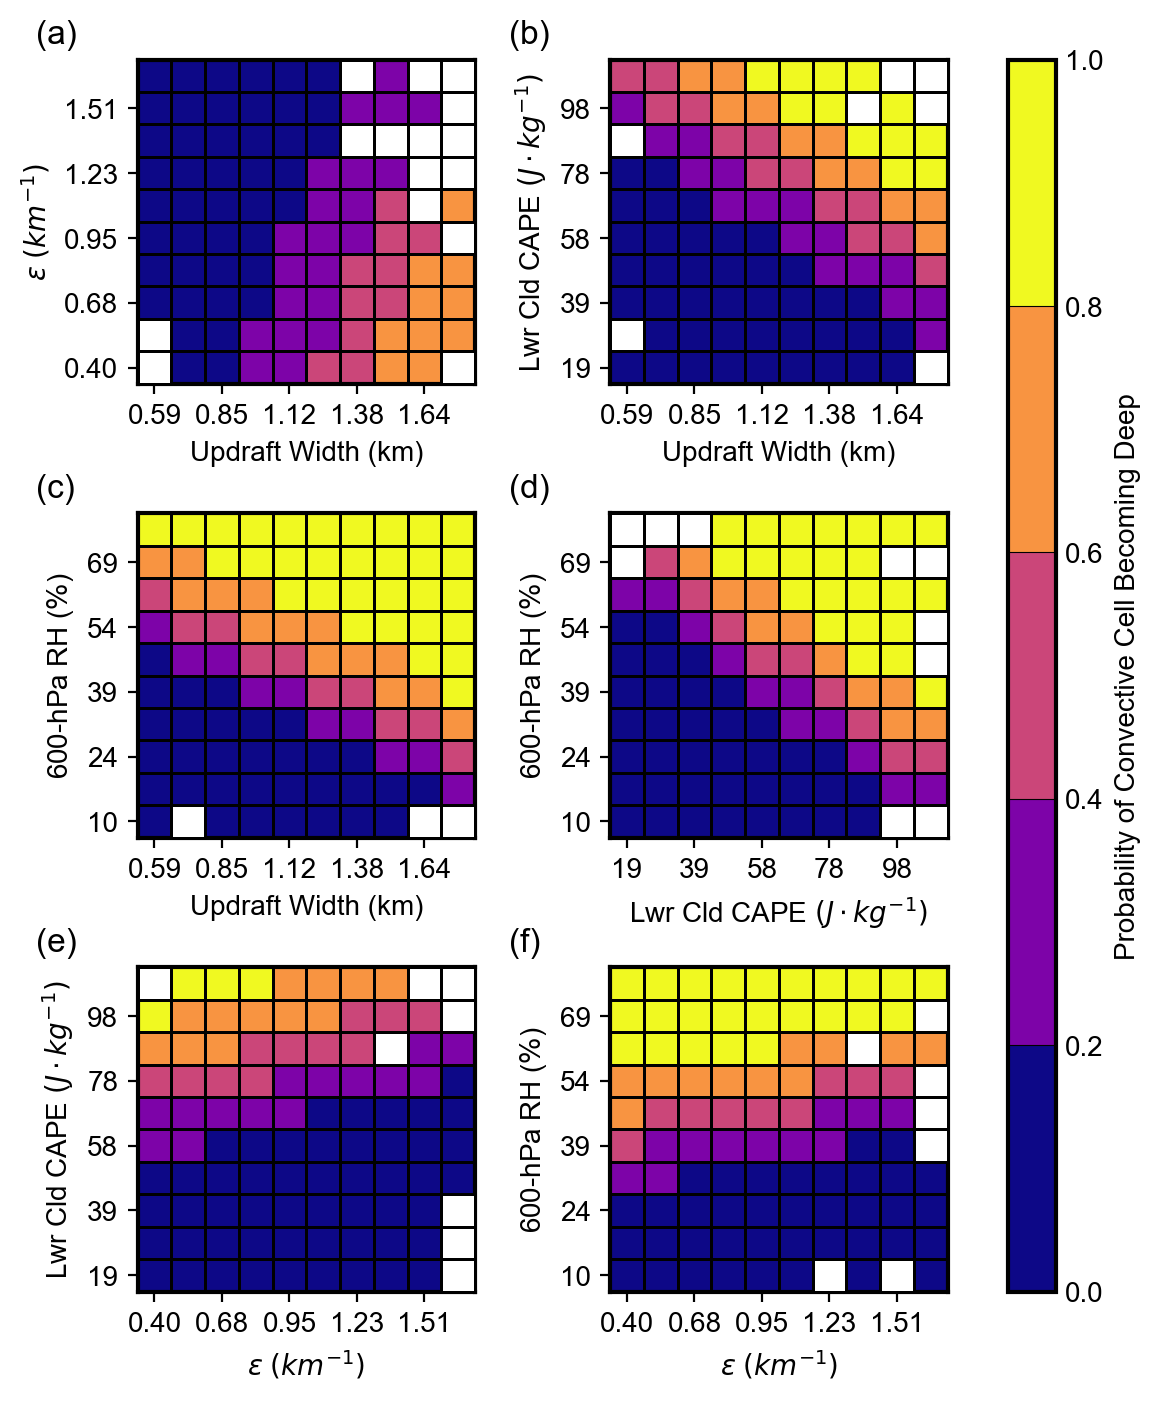

In [744]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))
axs = axes.ravel()

lev = [3,20,40,60]
cmap2 = mcolors.ListedColormap(['w'])
thre = 0
th2 = 10

# norm = np.arange(0,1.1,0.2)
# norm = matplotlib.colors.BoundaryNorm(np.arange(0,1.1,0.2),cmap='turbo')

boundaries = np.arange(0, 1.1, 0.2)  # from 0 to 1 with 0.2 increments
cmap = plt.get_cmap('plasma')
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

c = 0;ia = iid[c][0];ib = iid[c][1]

pm2 = axs[c].pcolormesh(vx[ia], vx[ib], EntWidth.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

c = 1;ia = iid[c][0];ib = iid[c][1]
pm2 = axs[c].pcolormesh(vx[ia], vx[ib], CAPEWidth.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

c = 2;ia = iid[c][0];ib = iid[c][1]
pm2 = axs[c].pcolormesh(vx[ia], vx[ib], RHWidth.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

c = 3;ia = iid[c][0];ib = iid[c][1]
pm2 = axs[c].pcolormesh(vx[ia], vx[ib], RHCAPE.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

c = 4;ia = iid[c][0];ib = iid[c][1]
pm2 = axs[c].pcolormesh(vx[ia], vx[ib], EntCAPE.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

c = 5;ia = iid[c][0];ib = iid[c][1]
pm1 = axs[c].pcolormesh(vx[ia], vx[ib], RHEnt.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

lbls = ['Updraft Width (km)',r'$\epsilon$ $(km^{-1})$',r'600-hPa RH ($\%$)','Lwr Cld CAPE $(J\cdot kg^{-1})$']
acc = np.array([2,2,0,0]).astype(str)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.11, 0.04, 0.77])
cbar = fig.colorbar(pm1,cax=cbar_ax,boundaries=boundaries, ticks=boundaries,drawedges=True)
cbar.outline.set_linewidth(1.5) 
cbar.ax.tick_params(length=0,direction='in')
cbar.set_label('Probability of Convective Cell Becoming Deep',fontsize=10)
# cbar.ax.tick_params()
# fig.colorbar(pm2, cax=cbar_ax,ticks=np.arange(0,1.1,.2),boundaries=np.arange(0,1.1,.2))

alp = ['(a)','(b)','(c)','(d)','(e)','(f)']
for c in range(0,6):
    ia = iid[c][0]
    ib = iid[c][1]
    counts,xbins,ybins = np.histogram2d(x[:,fnal[ia]],x[:,fnal[ib]],bins=[bx[ia], bx[ib]]);
    Tn = np.ma.masked_where(counts > thre, counts)
    tn1 = axs[c].pcolormesh(vx[ia], vx[ib], Tn.T, cmap=cmap2, zorder=3,alpha=1,edgecolors='black',linewidth=.5)
    axs[c].text(-0.3,1.05,alp[c],transform=axs[c].transAxes,fontsize=12)
    axs[c].set_xlabel(lbls[ia],fontsize = 10)
    axs[c].set_ylabel(lbls[ib],fontsize = 10)
    axs[c].set_xticks(vx[ia][::2])
    axs[c].set_yticks(vx[ib][::2])
    axs[c].set_xticklabels( np.char.mod('%.'+acc[ia]+'f', vx[ia][::2])  )
    axs[c].set_yticklabels( np.char.mod('%.'+acc[ib]+'f', vx[ib][::2])  )
    # axs[c].tick_params(axis='both', which='both', length=0)
    for spine in axs[c].spines.values():
        spine.set_linewidth(1.5)

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/Figure10.png',dpi=300, bbox_inches="tight")

In [241]:
# cbar.spines

# Half & Half

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))
axs = axes.ravel()

lev = [3,20,40,60]
# cmap = mcolors.ListedColormap(['k'])
thre = 0
th2 = 10

# norm = np.arange(0,1.1,0.2)
# norm = matplotlib.colors.BoundaryNorm(np.arange(0,1.1,0.2),cmap='turbo')

boundaries = np.arange(0, 1.1, 0.2)  # from 0 to 1 with 0.2 increments
cmap = plt.get_cmap('plasma')
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

c = 1
xl = np.copy(s1).reshape(1,-1)[0]
yl = np.copy(s2).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[0]],x[:,fnal[1]],bins=[len(xl), len(yl)]);
x_bin_indices = np.digitize(x[:,fnal[0]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[1]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        prob_matrix[i,j] = sum(y[ind])/len(ind)
Tn = np.ma.masked_where((prob_matrix == thre) | (counts < th2), prob_matrix)
pm1 = axs[c].pcolormesh(xl, yl, Tn.T,cmap='plasma',alpha=1,norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.2f', v1[::2]) )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.2f', v2[::2])  )
axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
axs[c].set_ylabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
axs[c].set_xlim([None, .85])
axs[c].set_ylim([None, .58])

c = 3
xl = np.copy(s4).reshape(1,-1)[0]
yl = np.copy(s3).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[3]],x[:,fnal[2]],bins=[len(xl), len(yl)]);
x_bin_indices = np.digitize(x[:,fnal[3]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[2]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        prob_matrix[i,j] = sum(y[ind])/len(ind)
Tn = np.ma.masked_where((prob_matrix == thre) | (counts < th2), prob_matrix)
pm1 = axs[c].pcolormesh(xl, yl, Tn.T,cmap='plasma',alpha=1,norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.0f', v4[::2])  )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
axs[c].set_xlabel('Lower Cloud \nCAPE $(J\cdot kg^{-1})$',fontsize = 10);
axs[c].set_ylabel(r'600 mb RH ($\%$)',fontsize = 10);
axs[c].set_xlim([-1.47, 2.05])
axs[c].set_ylim([None, None])

c = 5
xl = np.copy(s2).reshape(1,-1)[0]
yl = np.copy(s3).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[1]],x[:,fnal[2]],bins=[len(xl), len(yl)]);
x_bin_indices = np.digitize(x[:,fnal[1]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[2]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        prob_matrix[i,j] = sum(y[ind])/len(ind)
Tn = np.ma.masked_where((prob_matrix == thre) | (counts < th2), prob_matrix)
pm1 = axs[c].pcolormesh(xl, yl, Tn.T,cmap='plasma',alpha=1,norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.2f', v2[::2])  )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
axs[c].set_xlabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
axs[c].set_ylabel(r'600 mb RH ($\%$)',fontsize = 10);
axs[c].set_xlim([None, .58])
axs[c].set_ylim([None, None])


c = 0
xl = np.copy(s1).reshape(1,-1)[0]
yl = np.copy(s2).reshape(1,-1)[0]
pm2 = axs[c].pcolormesh(xl, yl, EntWidth.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.2f', v1[::2]) )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.2f', v2[::2])  )
axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
axs[c].set_ylabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
axs[c].set_xlim([None, .85])
axs[c].set_ylim([None, .58])

c = 2
xl = np.copy(s4).reshape(1,-1)[0]
yl = np.copy(s3).reshape(1,-1)[0]
pm2 = axs[c].pcolormesh(xl, yl, RHCAPE.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.0f', v4[::2])  )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
axs[c].set_xlabel('Lower Cloud \nCAPE $(J\cdot kg^{-1})$',fontsize = 10);
axs[c].set_ylabel(r'600 mb RH ($\%$)',fontsize = 10);
axs[c].set_xlim([-1.47, 2.05])
axs[c].set_ylim([None, None])

c = 4
xl = np.copy(s2).reshape(1,-1)[0]
yl = np.copy(s3).reshape(1,-1)[0]
pm2 = axs[c].pcolormesh(xl, yl, RHEnt.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.2f', v2[::2])  )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
axs[c].set_xlabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
axs[c].set_ylabel(r'600 mb RH ($\%$)',fontsize = 10);
axs[c].set_xlim([None, .58])
axs[c].set_ylim([None, None])


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.11, 0.04, 0.77])
cbar = fig.colorbar(pm1,cax=cbar_ax,boundaries=boundaries, ticks=boundaries,drawedges=True)
cbar.outline.set_linewidth(1.5) 
cbar.ax.tick_params(length=0,direction='in')
# cbar.ax.tick_params()
# fig.colorbar(pm2, cax=cbar_ax,ticks=np.arange(0,1.1,.2),boundaries=np.arange(0,1.1,.2))

alp = ['(a)','(b)','(c)','(d)','(e)','(f)']
for c in range(0,6):
    axs[c].text(-0.3,1.05,alp[c],transform=axs[c].transAxes,fontsize=12)
    # axs[c].tick_params(axis='both', which='both', length=0)
    for spine in axs[c].spines.values():
        spine.set_linewidth(1.5)

axs[1].text(.5,1.2,'Analytical Model',transform=axs[1].transAxes,fontsize=14,ha='center',va='center',weight='bold')
axs[0].text(.5,1.2,'Simulated',transform=axs[0].transAxes,fontsize=14,ha='center',va='center',weight='bold')


subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureSx.png',dpi=300, bbox_inches="tight")

# WRF Simulations

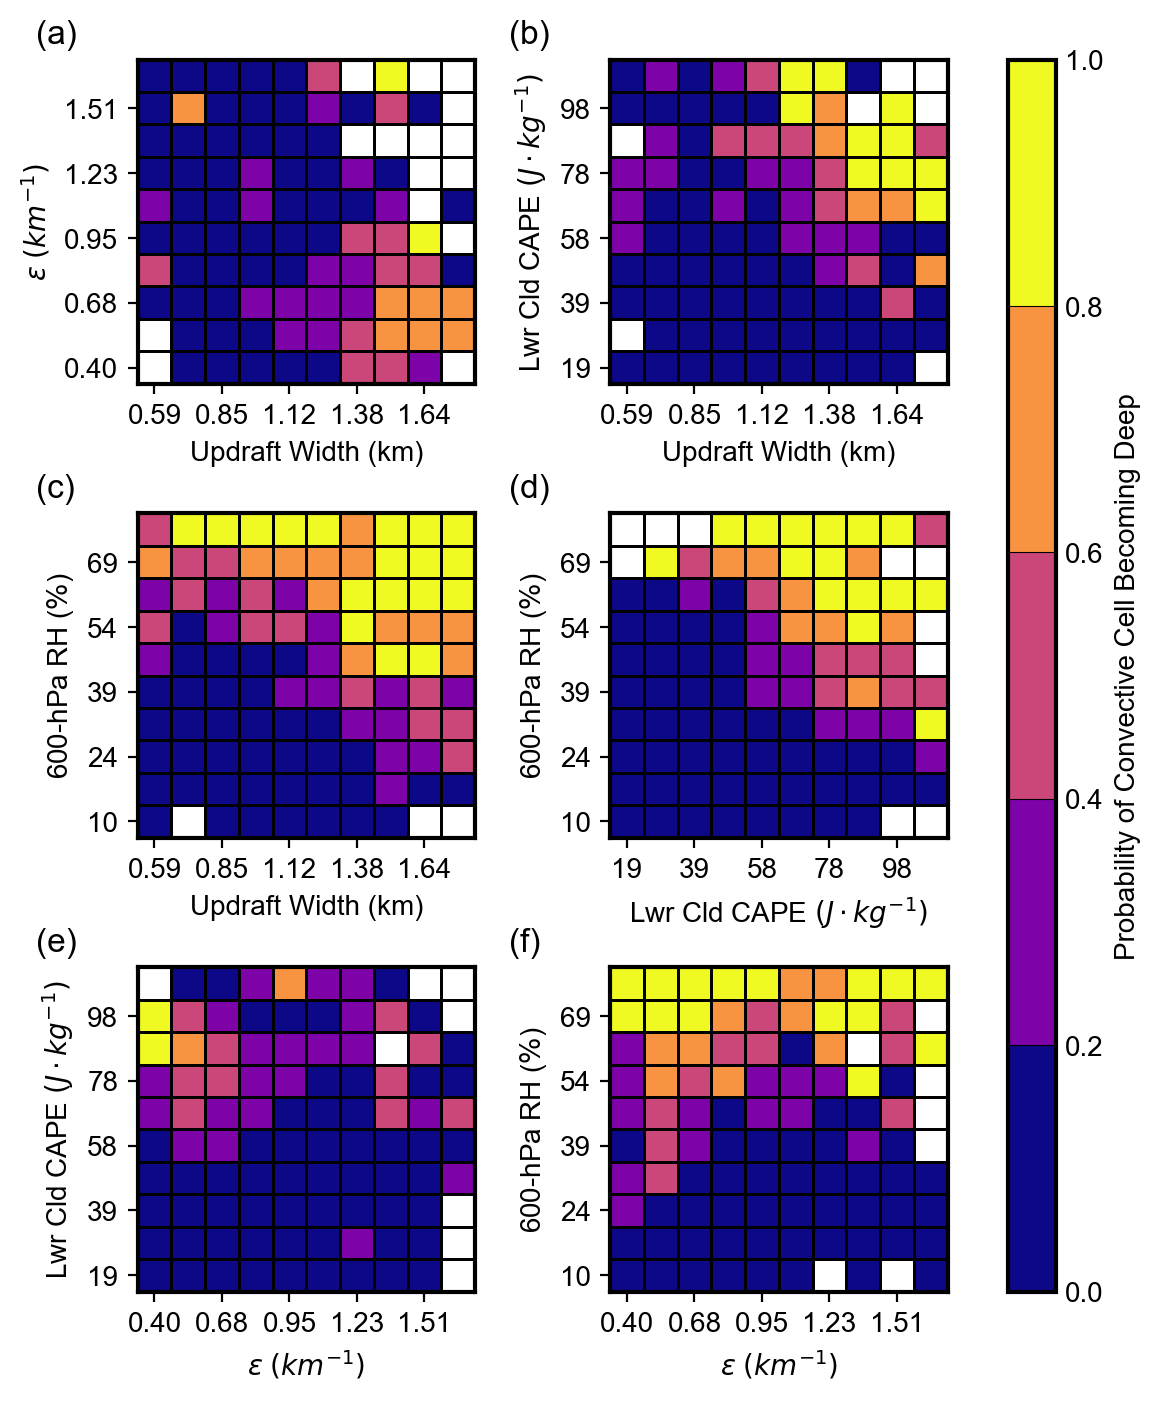

In [704]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))
axs = axes.ravel()

# cmap2 = mcolors.ListedColormap(['w'])
boundaries = np.arange(0, 1.1, 0.2)  # from 0 to 1 with 0.2 increments
cmap = plt.get_cmap('plasma')
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

for c in range(0,6):
    ia = iid[c][0]
    ib = iid[c][1]
    counts,xbins,ybins = np.histogram2d(x[:,fnal[ia]],x[:,fnal[ib]],bins=[bx[ia], bx[ib]]);
    x_bin_indices = np.digitize(x[:,fnal[ia]], xbins) - 1
    y_bin_indices = np.digitize(x[:,fnal[ib]], ybins) - 1
    prob_matrix = np.zeros((len(vx[ia]),len(vx[ib])))
    for i in range(len(vx[ia])):
        for j in range(len(vx[ib])):
            ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
            prob_matrix[i,j] = sum(y[ind])/len(ind)
    pm1 = axs[c].pcolormesh(vx[ia], vx[ib], prob_matrix.T,cmap='plasma',alpha=1,norm=norm,edgecolors='black',linewidth=.5)

lbls = ['Updraft Width (km)',r'$\epsilon$ $(km^{-1})$',r'600-hPa RH ($\%$)','Lwr Cld CAPE $(J\cdot kg^{-1})$']
acc = np.array([2,2,0,0]).astype(str)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.11, 0.04, 0.77])
cbar = fig.colorbar(pm1,cax=cbar_ax,boundaries=boundaries, ticks=boundaries,drawedges=True)
cbar.outline.set_linewidth(1.5) 
cbar.ax.tick_params(length=0,direction='in')
cbar.set_label('Probability of Convective Cell Becoming Deep',fontsize=10)
# cbar.ax.tick_params()
# fig.colorbar(pm2, cax=cbar_ax,ticks=np.arange(0,1.1,.2),boundaries=np.arange(0,1.1,.2))

alp = ['(a)','(b)','(c)','(d)','(e)','(f)']
for c in range(0,6):
    ia = iid[c][0]
    ib = iid[c][1]
    axs[c].text(-0.3,1.05,alp[c],transform=axs[c].transAxes,fontsize=12)
    axs[c].set_xlabel(lbls[ia],fontsize = 10)
    axs[c].set_ylabel(lbls[ib],fontsize = 10)
    axs[c].set_xticks(vx[ia][::2])
    axs[c].set_yticks(vx[ib][::2])
    axs[c].set_xticklabels( np.char.mod('%.'+acc[ia]+'f', vx[ia][::2])  )
    axs[c].set_yticklabels( np.char.mod('%.'+acc[ib]+'f', vx[ib][::2])  )
    # axs[c].tick_params(axis='both', which='both', length=0)
    for spine in axs[c].spines.values():
        spine.set_linewidth(1.5)

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureS12.png',dpi=300, bbox_inches="tight")

In [706]:
sx[ia]

array([[-1.09428191],
       [-0.73589913],
       [-0.37751635],
       [-0.01913357],
       [ 0.33924922],
       [ 0.697632  ],
       [ 1.05601478],
       [ 1.41439756],
       [ 1.77278034],
       [ 2.13116313]])

# Regression-Predicted

In [ ]:
# prob_matrix = np.zeros((len(vx[ia]),len(vx[ib]),6))

# for i in range(len(vx[ia])):
#     for j in range(len(vx[ib])):
#         ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
#         tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
#         prob_matrix[i,j,0] = Prob_of_Deep(sx[ia][i],sx[ib][j], scaler3.transform(  tmp_mean[2].reshape(-1,1)  ),scaler4.transform(  tmp_mean[3].reshape(-1,1)  ))[0]

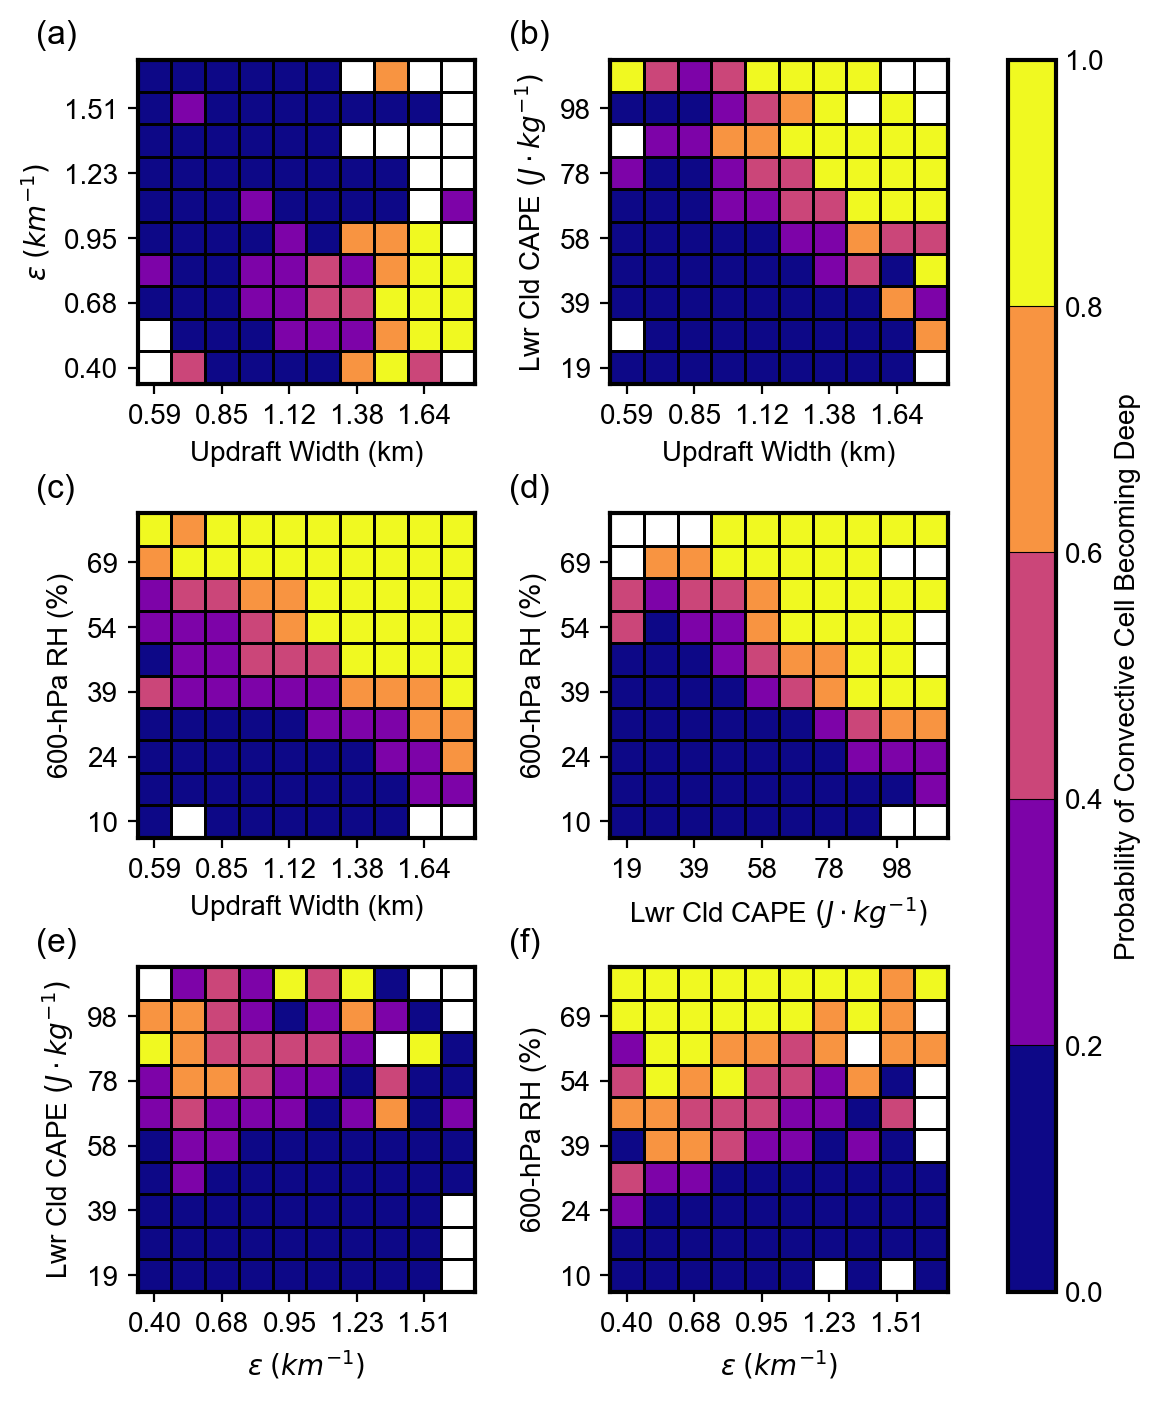

In [735]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))
axs = axes.ravel()

boundaries = np.arange(0, 1.1, 0.2)  # from 0 to 1 with 0.2 increments
cmap = plt.get_cmap('plasma')
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)


c = 0
ia = iid[c][0]
ib = iid[c][1]
counts,xbins,ybins = np.histogram2d(x[:,fnal[ia]],x[:,fnal[ib]],bins=[bx[ia], bx[ib]]);
x_bin_indices = np.digitize(x[:,fnal[ia]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[ib]], ybins) - 1
prob_matrix = np.zeros((len(vx[ia]),len(vx[ib])))
for i in range(len(vx[ia])):
    for j in range(len(vx[ib])):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(sx[ia][i], sx[ib][j], scaler3.transform(  tmp_mean[2].reshape(-1,1)  ), scaler4.transform(  tmp_mean[3].reshape(-1,1)  ))[0]
pm2 = axs[c].pcolormesh(vx[ia], vx[ib], prob_matrix[:,:].T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

c = 1
ia = iid[c][0]
ib = iid[c][1]
counts,xbins,ybins = np.histogram2d(x[:,fnal[ia]],x[:,fnal[ib]],bins=[bx[ia], bx[ib]]);
x_bin_indices = np.digitize(x[:,fnal[ia]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[ib]], ybins) - 1
prob_matrix = np.zeros((len(vx[ia]),len(vx[ib])))
for i in range(len(vx[ia])):
    for j in range(len(vx[ib])):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(sx[ia][i], scaler2.transform(  tmp_mean[1].reshape(-1,1)  ),scaler3.transform(  tmp_mean[2].reshape(-1,1)  ),sx[ib][j])[0]
pm2 = axs[c].pcolormesh(vx[ia], vx[ib], prob_matrix[:,:].T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

c = 2
ia = iid[c][0]
ib = iid[c][1]
counts,xbins,ybins = np.histogram2d(x[:,fnal[ia]],x[:,fnal[ib]],bins=[bx[ia], bx[ib]]);
x_bin_indices = np.digitize(x[:,fnal[ia]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[ib]], ybins) - 1
prob_matrix = np.zeros((len(vx[ia]),len(vx[ib])))
for i in range(len(vx[ia])):
    for j in range(len(vx[ib])):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(sx[ia][i],scaler2.transform(  tmp_mean[1].reshape(-1,1)  ), sx[ib][j], scaler4.transform(  tmp_mean[3].reshape(-1,1)  ))[0]
pm2 = axs[c].pcolormesh(vx[ia], vx[ib], prob_matrix[:,:].T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

c = 3
ia = iid[c][0]
ib = iid[c][1]
counts,xbins,ybins = np.histogram2d(x[:,fnal[ia]],x[:,fnal[ib]],bins=[bx[ia], bx[ib]]);
x_bin_indices = np.digitize(x[:,fnal[ia]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[ib]], ybins) - 1
prob_matrix = np.zeros((len(vx[ia]),len(vx[ib])))
for i in range(len(vx[ia])):
    for j in range(len(vx[ib])):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(scaler1.transform(  tmp_mean[0].reshape(-1,1)  ),scaler2.transform(  tmp_mean[1].reshape(-1,1)  ),sx[ib][j],sx[ia][i])[0]
pm2 = axs[c].pcolormesh(vx[ia], vx[ib], prob_matrix[:,:].T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

c = 4
ia = iid[c][0]
ib = iid[c][1]
counts,xbins,ybins = np.histogram2d(x[:,fnal[ia]],x[:,fnal[ib]],bins=[bx[ia], bx[ib]]);
x_bin_indices = np.digitize(x[:,fnal[ia]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[ib]], ybins) - 1
prob_matrix = np.zeros((len(vx[ia]),len(vx[ib])))
for i in range(len(vx[ia])):
    for j in range(len(vx[ib])):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(scaler1.transform(  tmp_mean[0].reshape(-1,1)  ),sx[ia][i], scaler3.transform(  tmp_mean[2].reshape(-1,1)  ), sx[ib][j])[0]
pm2 = axs[c].pcolormesh(vx[ia], vx[ib], prob_matrix[:,:].T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)

c = 5
ia = iid[c][0]
ib = iid[c][1]
counts,xbins,ybins = np.histogram2d(x[:,fnal[ia]],x[:,fnal[ib]],bins=[bx[ia], bx[ib]]);
x_bin_indices = np.digitize(x[:,fnal[ia]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[ib]], ybins) - 1
prob_matrix = np.zeros((len(vx[ia]),len(vx[ib])))
for i in range(len(vx[ia])):
    for j in range(len(vx[ib])):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(scaler1.transform(  tmp_mean[0].reshape(-1,1)  ), sx[ia][i],sx[ib][j], scaler4.transform(  tmp_mean[3].reshape(-1,1)  ))[0]
pm2 = axs[c].pcolormesh(vx[ia], vx[ib], prob_matrix[:,:].T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)


lbls = ['Updraft Width (km)',r'$\epsilon$ $(km^{-1})$',r'600-hPa RH ($\%$)','Lwr Cld CAPE $(J\cdot kg^{-1})$']
acc = np.array([2,2,0,0]).astype(str)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.11, 0.04, 0.77])
cbar = fig.colorbar(pm1,cax=cbar_ax,boundaries=boundaries, ticks=boundaries,drawedges=True)
cbar.outline.set_linewidth(1.5) 
cbar.ax.tick_params(length=0,direction='in')
cbar.set_label('Probability of Convective Cell Becoming Deep',fontsize=10)

alp = ['(a)','(b)','(c)','(d)','(e)','(f)']
for c in range(0,6):
    ia = iid[c][0]
    ib = iid[c][1]
    
    axs[c].text(-0.3,1.05,alp[c],transform=axs[c].transAxes,fontsize=12)
    axs[c].set_xlabel(lbls[ia],fontsize = 10)
    axs[c].set_ylabel(lbls[ib],fontsize = 10)
    axs[c].set_xticks(vx[ia][::2])
    axs[c].set_yticks(vx[ib][::2])
    axs[c].set_xticklabels( np.char.mod('%.'+acc[ia]+'f', vx[ia][::2])  )
    axs[c].set_yticklabels( np.char.mod('%.'+acc[ib]+'f', vx[ib][::2])  )
    # axs[c].tick_params(axis='both', which='both', length=0)
    for spine in axs[c].spines.values():
        spine.set_linewidth(1.5)

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureS11.png',dpi=300, bbox_inches="tight")

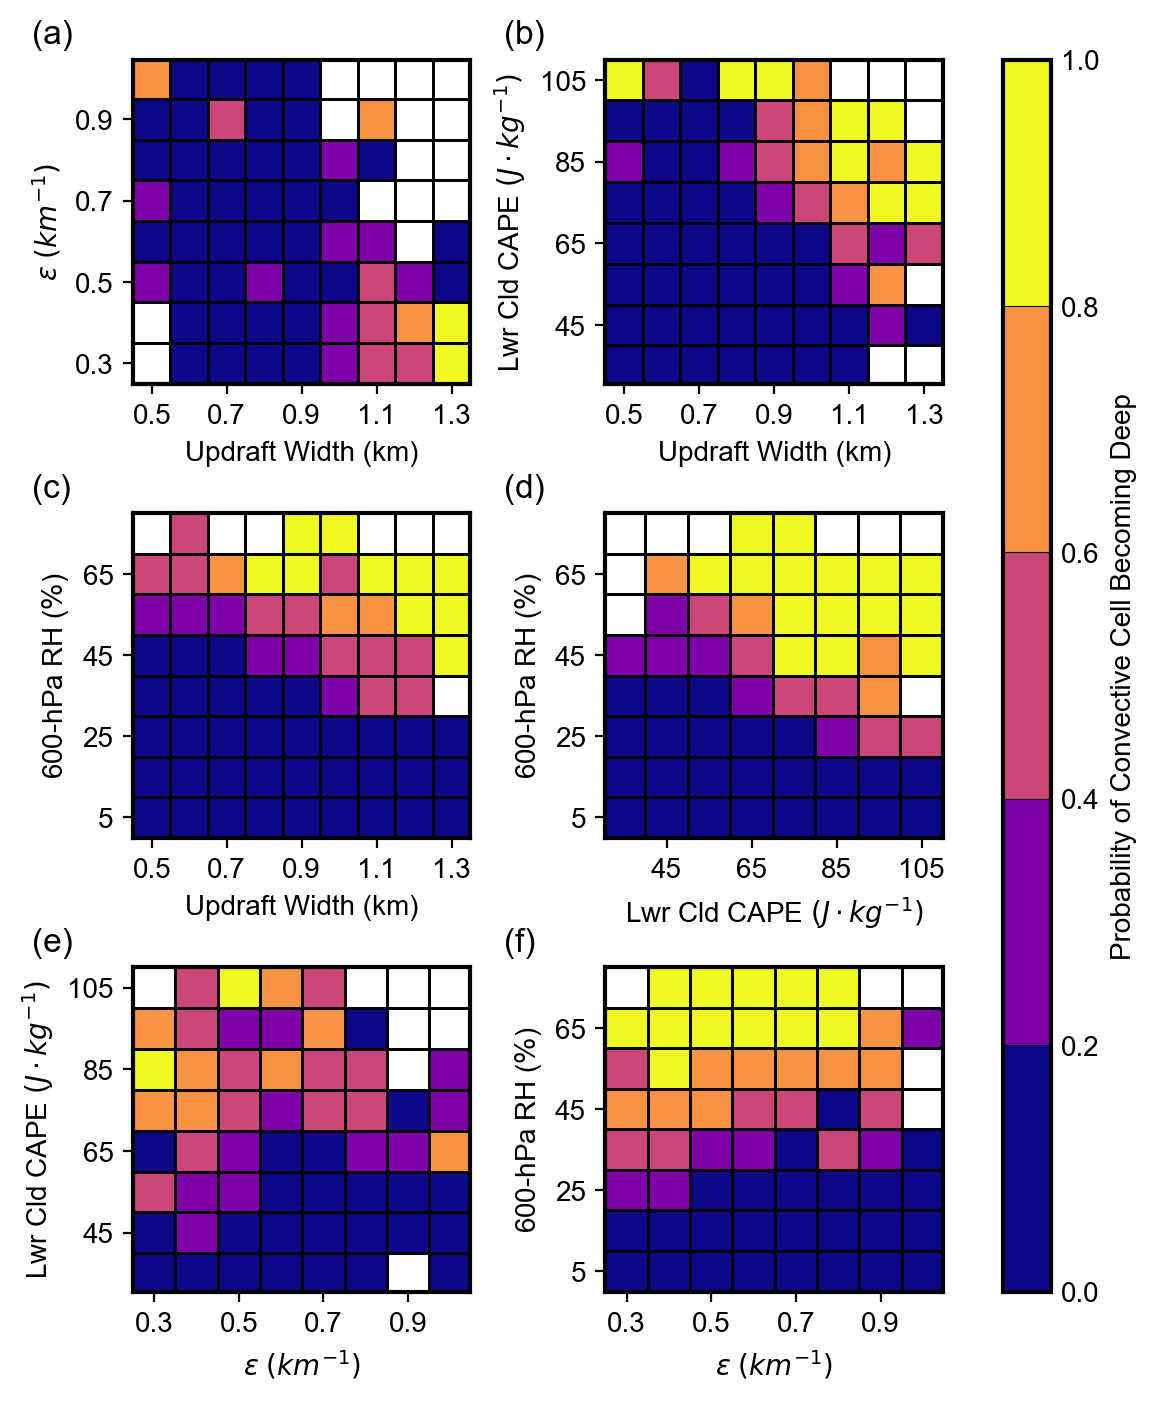

In [530]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))
axs = axes.ravel()

boundaries = np.arange(0, 1.1, 0.2)  # from 0 to 1 with 0.2 increments
cmap = plt.get_cmap('plasma')
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

c = 0
xl = np.copy(s1).reshape(1,-1)[0]
yl = np.copy(s2).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[0]],x[:,fnal[1]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[0]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[1]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(xl[i],yl[j], scaler3.transform(  tmp_mean[2].reshape(-1,1)  ),scaler4.transform(  tmp_mean[3].reshape(-1,1)  ))[0]
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.1f', v1[::2]) )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.1f', v2[::2])  )
axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
axs[c].set_ylabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
axs[c].set_xlim([None, .85])
axs[c].set_ylim([None, .58])

c = 1
xl = np.copy(s1).reshape(1,-1)[0]
yl = np.copy(s4).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[0]],x[:,fnal[3]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[0]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[3]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(xl[i], scaler2.transform(  tmp_mean[1].reshape(-1,1)  ),scaler3.transform(  tmp_mean[2].reshape(-1,1)  ),yl[j])[0]
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.1f', v1[::2]) )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v4[::2])  )
axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
axs[c].set_ylabel('Lwr Cld CAPE $(J\cdot kg^{-1})$',fontsize = 10);
axs[c].set_xlim([None, .85])
axs[c].set_ylim([-1.5, 2.05])

c = 2
xl = np.copy(s1).reshape(1,-1)[0]
yl = np.copy(s3).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[0]],x[:,fnal[2]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[0]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[2]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(xl[i],scaler2.transform(  tmp_mean[1].reshape(-1,1)  ), yl[j], scaler4.transform(  tmp_mean[3].reshape(-1,1)  ))[0]
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.1f', v1[::2]) )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
axs[c].set_ylabel(r'600-hPa RH ($\%$)',fontsize = 10);
axs[c].set_xlim([None, .85])
axs[c].set_ylim([None, None])

c = 3
xl = np.copy(s4).reshape(1,-1)[0]
yl = np.copy(s3).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[3]],x[:,fnal[2]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[3]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[2]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(scaler1.transform(  tmp_mean[0].reshape(-1,1)  ),scaler2.transform(  tmp_mean[1].reshape(-1,1)  ),yl[j],xl[i])[0]
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.0f', v4[::2])  )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
axs[c].set_xlabel('Lwr Cld CAPE $(J\cdot kg^{-1})$',fontsize = 10);
axs[c].set_ylabel(r'600-hPa RH ($\%$)',fontsize = 10);
axs[c].set_xlim([-1.5, 2.05])
axs[c].set_ylim([None, None])

c = 4
xl = np.copy(s2).reshape(1,-1)[0]
yl = np.copy(s4).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[1]],x[:,fnal[3]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[1]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[3]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(scaler1.transform(  tmp_mean[0].reshape(-1,1)  ),xl[i], scaler3.transform(  tmp_mean[2].reshape(-1,1)  ), yl[j])[0]
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.1f', v2[::2])  )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v4[::2])  )
axs[c].set_xlabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
axs[c].set_ylabel('Lwr Cld CAPE $(J\cdot kg^{-1})$',fontsize = 10);
axs[c].set_xlim([None, .58])
axs[c].set_ylim([-1.5, 2.05])

c = 5
xl = np.copy(s2).reshape(1,-1)[0]
yl = np.copy(s3).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[1]],x[:,fnal[2]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[1]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[2]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
        prob_matrix[i,j] = Prob_of_Deep(scaler1.transform(  tmp_mean[0].reshape(-1,1)  ), xl[i],yl[j], scaler4.transform(  tmp_mean[3].reshape(-1,1)  ))[0]
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.1f', v2[::2])  )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
axs[c].set_xlabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
axs[c].set_ylabel(r'600-hPa RH ($\%$)',fontsize = 10);
axs[c].set_xlim([None, .58])
axs[c].set_ylim([None, None])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.11, 0.04, 0.77])
cbar = fig.colorbar(pm1,cax=cbar_ax,boundaries=boundaries, ticks=boundaries,drawedges=True)
cbar.outline.set_linewidth(1.5) 
cbar.ax.tick_params(length=0,direction='in')
cbar.set_label('Probability of Convective Cell Becoming Deep',fontsize=10)
# cbar.ax.tick_params()
# fig.colorbar(pm2, cax=cbar_ax,ticks=np.arange(0,1.1,.2),boundaries=np.arange(0,1.1,.2))

alp = ['(a)','(b)','(c)','(d)','(e)','(f)']
for c in range(0,6):
    axs[c].text(-0.3,1.05,alp[c],transform=axs[c].transAxes,fontsize=12)
    # axs[c].tick_params(axis='both', which='both', length=0)
    for spine in axs[c].spines.values():
        spine.set_linewidth(1.5)

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
# plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureS11.png',dpi=300, bbox_inches="tight")

# Semi-Reality Plots

In [151]:
i = 7;j = 2

ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
tmp_mean = np.mean(x[ind,:],axis=0)[fnal]
ind

array([ 456,  465,  531,  532,  750,  816, 1145])

In [163]:
x[0,:].shape

(21,)

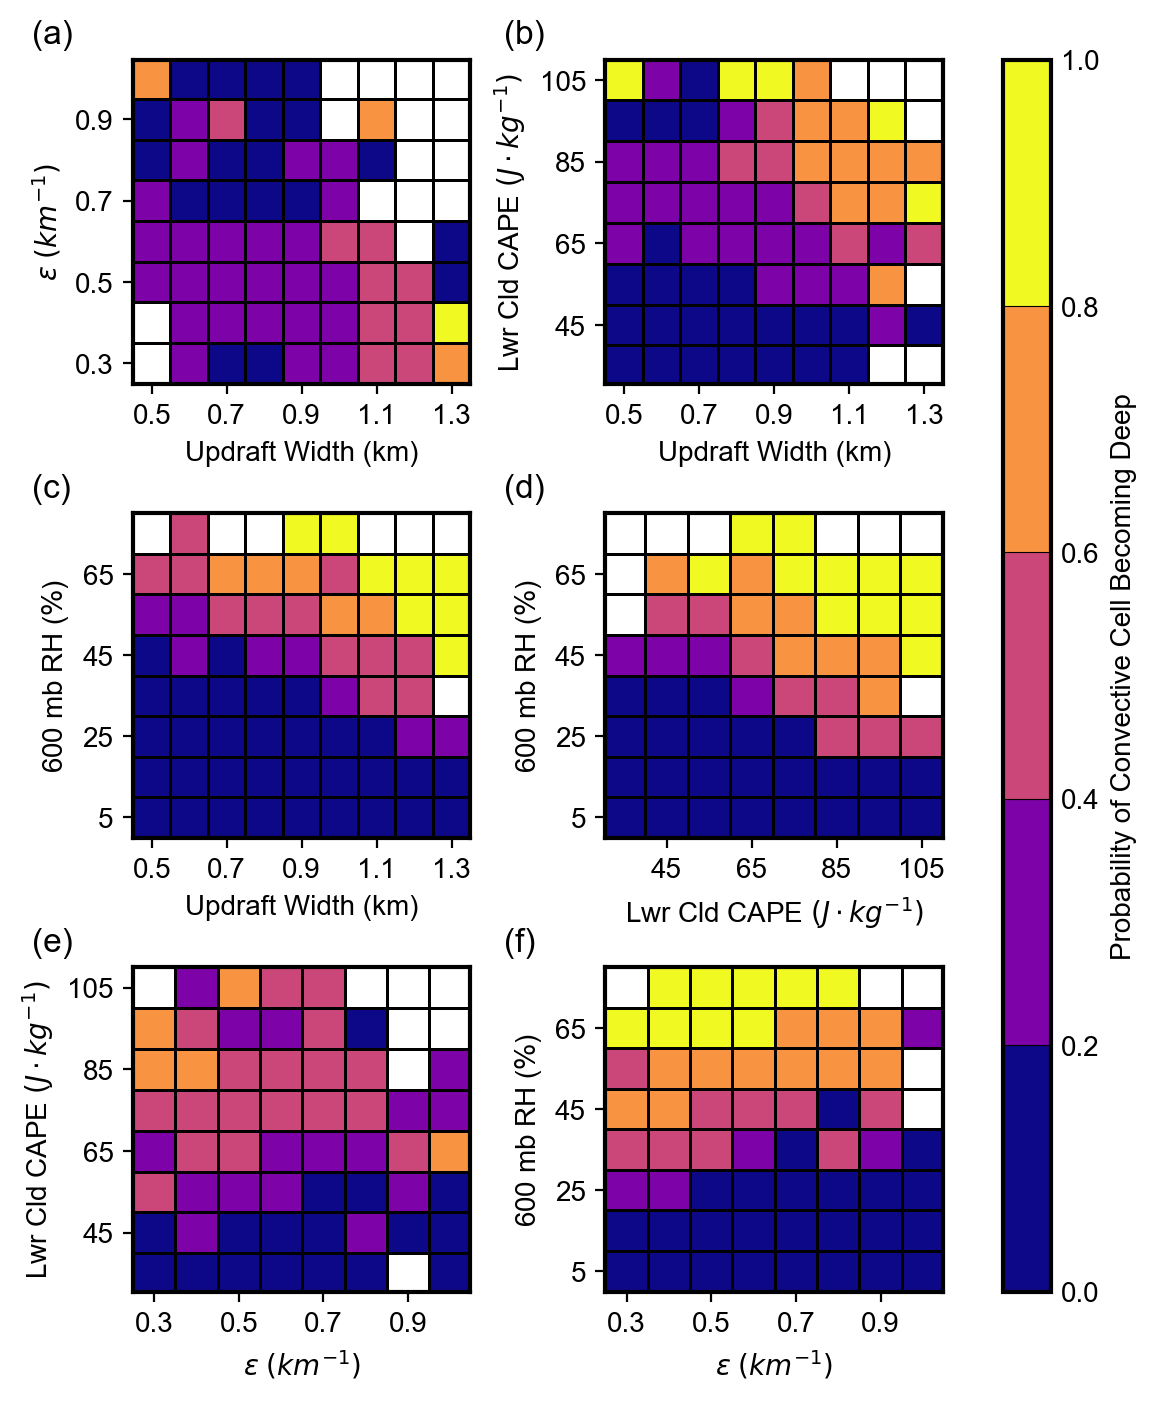

In [242]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))
axs = axes.ravel()

boundaries = np.arange(0, 1.1, 0.2)  # from 0 to 1 with 0.2 increments
cmap = plt.get_cmap('plasma')
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

c = 0
xl = np.copy(s1).reshape(1,-1)[0]
yl = np.copy(s2).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[0]],x[:,fnal[1]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[0]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[1]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        p_average = np.zeros((len(ind),))
        for k in range(len(ind)):
            p_average[k] = Prob_of_Deep(xl[i],yl[j], scaler3.transform(  x[ind[k],fnal[2]].reshape(-1,1)  ),scaler4.transform(  x[ind[k],fnal[3]].reshape(-1,1)  ))[0]
        prob_matrix[i,j] = np.mean(p_average)
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.1f', v1[::2]) )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.1f', v2[::2])  )
axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
axs[c].set_ylabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
axs[c].set_xlim([None, .85])
axs[c].set_ylim([None, .58])

c = 1
xl = np.copy(s1).reshape(1,-1)[0]
yl = np.copy(s4).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[0]],x[:,fnal[3]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[0]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[3]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        p_average = np.zeros((len(ind),))
        for k in range(len(ind)):
            p_average[k] = Prob_of_Deep(xl[i],scaler2.transform(  x[ind[k],fnal[1]].reshape(-1,1)  ),scaler3.transform(  x[ind[k],fnal[2]].reshape(-1,1)  ),yl[j])[0]
        prob_matrix[i,j] = np.mean(p_average)
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.1f', v1[::2]) )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v4[::2])  )
axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
axs[c].set_ylabel('Lwr Cld CAPE $(J\cdot kg^{-1})$',fontsize = 10);
axs[c].set_xlim([None, .85])
axs[c].set_ylim([-1.5, 2.05])

c = 2
xl = np.copy(s1).reshape(1,-1)[0]
yl = np.copy(s3).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[0]],x[:,fnal[2]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[0]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[2]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        p_average = np.zeros((len(ind),))
        for k in range(len(ind)):
            p_average[k] = Prob_of_Deep(xl[i], scaler2.transform(  x[ind[k],fnal[1]].reshape(-1,1)  ), yl[j], scaler4.transform(  x[ind[k],fnal[3]].reshape(-1,1)  ))[0]
        prob_matrix[i,j] = np.mean(p_average)
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.1f', v1[::2]) )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
axs[c].set_xlabel('Updraft Width (km)',fontsize = 10)
axs[c].set_ylabel(r'600 mb RH ($\%$)',fontsize = 10);
axs[c].set_xlim([None, .85])
axs[c].set_ylim([None, None])

c = 3
xl = np.copy(s4).reshape(1,-1)[0]
yl = np.copy(s3).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[3]],x[:,fnal[2]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[3]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[2]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        p_average = np.zeros((len(ind),))
        for k in range(len(ind)):
            p_average[k] = Prob_of_Deep(scaler1.transform(  x[ind[k],fnal[0]].reshape(-1,1)  ),scaler2.transform(  x[ind[k],fnal[1]].reshape(-1,1) ),yl[j],xl[i]  )[0]
        prob_matrix[i,j] = np.mean(p_average)
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.0f', v4[::2])  )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
axs[c].set_xlabel('Lwr Cld CAPE $(J\cdot kg^{-1})$',fontsize = 10);
axs[c].set_ylabel(r'600 mb RH ($\%$)',fontsize = 10);
axs[c].set_xlim([-1.5, 2.05])
axs[c].set_ylim([None, None])

c = 4
xl = np.copy(s2).reshape(1,-1)[0]
yl = np.copy(s4).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[1]],x[:,fnal[3]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[1]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[3]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        p_average = np.zeros((len(ind),))
        for k in range(len(ind)):
            p_average[k] = Prob_of_Deep(scaler1.transform(  x[ind[k],fnal[0]].reshape(-1,1)  ),xl[i],scaler3.transform(  x[ind[k],fnal[2]].reshape(-1,1)),yl[j]  )[0]
        prob_matrix[i,j] = np.mean(p_average)
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.1f', v2[::2])  )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v4[::2])  )
axs[c].set_xlabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
axs[c].set_ylabel('Lwr Cld CAPE $(J\cdot kg^{-1})$',fontsize = 10);
axs[c].set_xlim([None, .58])
axs[c].set_ylim([-1.5, 2.05])

c = 5
xl = np.copy(s2).reshape(1,-1)[0]
yl = np.copy(s3).reshape(1,-1)[0]
counts,xbins,ybins = np.histogram2d(x[:,fnal[1]],x[:,fnal[2]],bins=[len(xl), len(yl)]);
# Tn = np.ma.masked_where(counts > thre, counts)
# tn1 = axs[c].pcolormesh(xl,yl, Tn.T, cmap=cmap, zorder=3,alpha=0.5)
x_bin_indices = np.digitize(x[:,fnal[1]], xbins) - 1
y_bin_indices = np.digitize(x[:,fnal[2]], ybins) - 1
prob_matrix = np.zeros((len(xl),len(yl)))
for i in range(len(xl)):
    for j in range(len(yl)):
        ind = np.where((x_bin_indices == i) & (y_bin_indices == j))[0]
        p_average = np.zeros((len(ind),))
        for k in range(len(ind)):
            p_average[k] = Prob_of_Deep(scaler1.transform(  x[ind[k],fnal[0]].reshape(-1,1)  ),xl[i],yl[j], scaler4.transform(  x[ind[k],fnal[3]].reshape(-1,1)  ))[0]
        prob_matrix[i,j] = np.mean(p_average)
pm2 = axs[c].pcolormesh(xl, yl, prob_matrix.T,cmap='plasma',norm=norm,edgecolors='black',linewidth=.5)
axs[c].set_xticks(xl[::2])
axs[c].set_xticklabels( np.char.mod('%.1f', v2[::2])  )
axs[c].set_yticks(yl[::2])
axs[c].set_yticklabels( np.char.mod('%.0f', v3[::2])  )
axs[c].set_xlabel(r'$\epsilon$ $(km^{-1})$',fontsize = 10);
axs[c].set_ylabel(r'600 mb RH ($\%$)',fontsize = 10);
axs[c].set_xlim([None, .58])
axs[c].set_ylim([None, None])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.11, 0.04, 0.77])
cbar = fig.colorbar(pm1,cax=cbar_ax,boundaries=boundaries, ticks=boundaries,drawedges=True)
cbar.outline.set_linewidth(1.5) 
cbar.ax.tick_params(length=0,direction='in')
cbar.set_label('Probability of Convective Cell Becoming Deep',fontsize=10)
# cbar.ax.tick_params()
# fig.colorbar(pm2, cax=cbar_ax,ticks=np.arange(0,1.1,.2),boundaries=np.arange(0,1.1,.2))

alp = ['(a)','(b)','(c)','(d)','(e)','(f)']
for c in range(0,6):
    axs[c].text(-0.3,1.05,alp[c],transform=axs[c].transAxes,fontsize=12)
    # axs[c].tick_params(axis='both', which='both', length=0)
    for spine in axs[c].spines.values():
        spine.set_linewidth(1.5)

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.savefig('/Users/joen589/OneDrive - PNNL/Paper 1/Figures/FigureS8.png',dpi=300, bbox_inches="tight")

In [382]:
# xl[28]